In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity':-1,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 5000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.2, 0.8, step=0.05),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 50),
        
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-5, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-5, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-5, 1e1, log=True),
        
        # dart
        #drop_rate = trial.suggest_discrete_uniform("drop_rate", 0.05, 0.2, 0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 10),
        #skip_drop = trial.suggest_discrete_uniform("skip_drop", 0.2, 0.8, 0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 5min 21s, sys: 3.8 s, total: 5min 25s
Wall time: 40.8 s


(0.2414773648412618, 0.06894740241902327)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-gbrt-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-gbrt-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=2000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-16 00:36:02,078] Using an existing study with name 'iarc-lgbm-gbrt-bagging-balanced' instead of creating a new one.


[I 2023-06-16 00:36:41,218] Trial 15 finished with value: 0.24864776798960705 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0010542351184565574, 'lambda_l2': 0.032055030023328525, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.4293485753302047, 'num_iterations': 3266, 'num_leaves_exp': 4, 'path_smooth': 0.9126931237603317}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:36:53,765] Trial 16 finished with value: 0.2999076961426963 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.01403869400253614, 'lambda_l2': 1.2737044139728049, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 1.1193315494022966, 'num_iterations': 1102, 'num_leaves_exp': 4, 'path_smooth': 0.00010757843687255454}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:37:21,100] Trial 17 finished with value: 0.2464004324416204 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 3.630414319230873e-05, 'lambda_l2': 0.05040914791375096, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.5635047542597543, 'num_iterations': 2398, 'num_leaves_exp': 4, 'path_smooth': 0.03539509888703918}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:37:42,148] Trial 18 finished with value: 0.272509585526126 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 1.0059328073093075e-05, 'lambda_l2': 0.2912121098782295, 'max_bin_exp': 6, 'min_data_in_leaf': 50, 'min_gain_to_split': 1.1967979779598628, 'num_iterations': 2293, 'num_leaves_exp': 4, 'path_smooth': 0.018482740594333205}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:38:12,338] Trial 19 finished with value: 0.2574968491086043 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 4.723296589499807e-05, 'lambda_l2': 1.7797764077049452, 'max_bin_exp': 7, 'min_data_in_leaf': 38, 'min_gain_to_split': 0.06601078361434598, 'num_iterations': 2449, 'num_leaves_exp': 3, 'path_smooth': 6.764920947948124e-05}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:38:28,724] Trial 20 finished with value: 0.25888288046631924 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00034845750615443145, 'lambda_l2': 0.14764748092708904, 'max_bin_exp': 5, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.9404265624997705, 'num_iterations': 1338, 'num_leaves_exp': 4, 'path_smooth': 0.06260966869199769}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:39:05,506] Trial 21 finished with value: 0.24774550611742766 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 5.36665882910431e-05, 'lambda_l2': 0.04725712107845997, 'max_bin_exp': 6, 'min_data_in_leaf': 38, 'min_gain_to_split': 0.3394276138044374, 'num_iterations': 3210, 'num_leaves_exp': 4, 'path_smooth': 0.4301626342961269}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:39:39,122] Trial 22 finished with value: 0.246108622652676 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 5.4925661904423266e-05, 'lambda_l2': 0.02906651950218061, 'max_bin_exp': 6, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.16475682087017204, 'num_iterations': 2936, 'num_leaves_exp': 4, 'path_smooth': 0.011147467725411711}. Best is trial 3 with value: 0.2457916898526549.


[I 2023-06-16 00:40:07,452] Trial 23 finished with value: 0.2441443394720379 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 3.193523015296503e-05, 'lambda_l2': 0.02355102394397104, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.11556947002056762, 'num_iterations': 2082, 'num_leaves_exp': 3, 'path_smooth': 0.01344018278869639}. Best is trial 23 with value: 0.2441443394720379.


[I 2023-06-16 00:40:37,511] Trial 24 finished with value: 0.24163108915131398 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00010875881299511382, 'lambda_l2': 0.0035805367293468646, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.09144933954601837, 'num_iterations': 1648, 'num_leaves_exp': 3, 'path_smooth': 0.009621042957296202}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:41:07,155] Trial 25 finished with value: 0.2423053289263811 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00021866101027074846, 'lambda_l2': 0.00200990527924912, 'max_bin_exp': 7, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.08989122871172309, 'num_iterations': 1675, 'num_leaves_exp': 3, 'path_smooth': 0.0008925230876613982}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:41:36,247] Trial 26 finished with value: 0.2430440100876585 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.00023540099359928895, 'lambda_l2': 0.0031094549341124113, 'max_bin_exp': 7, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.023620089491241825, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 0.006146481820475435}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:42:03,501] Trial 27 finished with value: 0.24889687147828188 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 0.00022810777423325096, 'lambda_l2': 0.0022533433717764587, 'max_bin_exp': 8, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.014624315174387729, 'num_iterations': 1582, 'num_leaves_exp': 3, 'path_smooth': 0.001020657575667555}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:42:31,685] Trial 28 finished with value: 0.24471147925057765 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.0001487740090946147, 'lambda_l2': 0.0015307084527573258, 'max_bin_exp': 7, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.032281748165469894, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 0.006386138033166978}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:42:46,124] Trial 29 finished with value: 0.31110250400048095 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 0.00037746579001944, 'lambda_l2': 0.005267049799152447, 'max_bin_exp': 7, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.3695015900159464, 'num_iterations': 1145, 'num_leaves_exp': 3, 'path_smooth': 0.0010035370407690837}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:43:04,688] Trial 30 finished with value: 0.27708379038042646 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.002591785618504899, 'lambda_l2': 0.0008452649955630611, 'max_bin_exp': 8, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.06857387841870705, 'num_iterations': 1633, 'num_leaves_exp': 2, 'path_smooth': 0.003201575479075614}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:43:37,763] Trial 31 finished with value: 0.24375672009404287 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00011582231552442308, 'lambda_l2': 0.013055583349643608, 'max_bin_exp': 7, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.1296675616698556, 'num_iterations': 2074, 'num_leaves_exp': 3, 'path_smooth': 0.01439808528720845}. Best is trial 24 with value: 0.24163108915131398.


[I 2023-06-16 00:44:14,564] Trial 32 finished with value: 0.240057721373558 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 8.82781900203194e-05, 'lambda_l2': 0.009756085502653406, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.009323297705338211, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 0.004674551048781185}. Best is trial 32 with value: 0.240057721373558.


[I 2023-06-16 00:44:41,789] Trial 33 finished with value: 0.24508990708487843 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.000477649930750606, 'lambda_l2': 0.0060646961878306265, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.007712265662506458, 'num_iterations': 1459, 'num_leaves_exp': 3, 'path_smooth': 0.00502507954503363}. Best is trial 32 with value: 0.240057721373558.


[I 2023-06-16 00:45:23,095] Trial 34 finished with value: 0.2396305969397963 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00010425900033173231, 'lambda_l2': 0.0019407090985081468, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.02237814828838392, 'num_iterations': 1804, 'num_leaves_exp': 3, 'path_smooth': 0.0011078949159758023}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:46:09,122] Trial 35 finished with value: 0.2430257425192461 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 2.084599961591329e-05, 'lambda_l2': 0.0010771657160022867, 'max_bin_exp': 8, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.010196248153978106, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 0.0003826688425836398}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:46:32,891] Trial 36 finished with value: 0.25187386718516824 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 9.281496532475687e-05, 'lambda_l2': 0.0004757250856057798, 'max_bin_exp': 7, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.020824772665001243, 'num_iterations': 1030, 'num_leaves_exp': 3, 'path_smooth': 0.0016512729683689077}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:46:47,889] Trial 37 finished with value: 0.2942456079789045 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 2.4944289831793365e-05, 'lambda_l2': 0.00023656328248285253, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.002999378589598218, 'num_iterations': 1315, 'num_leaves_exp': 2, 'path_smooth': 0.0007898653784068236}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:47:30,420] Trial 38 finished with value: 0.2464165963257216 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 7.66449741577648e-05, 'lambda_l2': 0.007718244946507578, 'max_bin_exp': 8, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.04857647550055195, 'num_iterations': 2186, 'num_leaves_exp': 3, 'path_smooth': 0.003116570873832167}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:48:36,527] Trial 39 finished with value: 0.26412885195644253 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.0015772599582227014, 'lambda_l2': 0.002887867672041204, 'max_bin_exp': 7, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.031765217542773415, 'num_iterations': 2546, 'num_leaves_exp': 3, 'path_smooth': 0.00046722387617753494}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:49:15,776] Trial 40 finished with value: 0.2417597515458174 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.0007335710505151523, 'lambda_l2': 0.0001201332005731696, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.01144924107680595, 'num_iterations': 1829, 'num_leaves_exp': 3, 'path_smooth': 0.0014747941551625037}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:49:55,472] Trial 41 finished with value: 0.24251103066225707 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.0005558823470381893, 'lambda_l2': 0.00011947858752013069, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.01154595967606638, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 0.001920426852259039}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:50:35,797] Trial 42 finished with value: 0.24181223976894156 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.0001801719263521643, 'lambda_l2': 0.001446791353076233, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.006050260113400359, 'num_iterations': 1969, 'num_leaves_exp': 3, 'path_smooth': 0.004352681501993264}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:51:26,516] Trial 43 finished with value: 0.24514891325777374 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.0009603682678848468, 'lambda_l2': 6.36291114622663e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.006097141313024178, 'num_iterations': 2007, 'num_leaves_exp': 3, 'path_smooth': 0.0056984797095764265}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:51:41,812] Trial 44 finished with value: 0.2902987106825068 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.00013643414906269304, 'lambda_l2': 1.093452403767025e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.002135442807987105, 'num_iterations': 1303, 'num_leaves_exp': 2, 'path_smooth': 0.0033465249609106536}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:52:27,767] Trial 45 finished with value: 0.2480626512287061 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.0005095529525934926, 'lambda_l2': 0.0006050795035557168, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003816987262842355, 'num_iterations': 2255, 'num_leaves_exp': 3, 'path_smooth': 0.0017269015757355442}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:53:31,914] Trial 46 finished with value: 0.26067808823236566 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 1.8009624041261564e-05, 'lambda_l2': 0.00131182158451673, 'max_bin_exp': 8, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.008240515978899092, 'num_iterations': 2663, 'num_leaves_exp': 3, 'path_smooth': 0.01055748702236627}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:53:53,367] Trial 47 finished with value: 0.27042796735591673 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 6.605894421226433e-05, 'lambda_l2': 0.0002424506445623715, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.013858183428714015, 'num_iterations': 1844, 'num_leaves_exp': 2, 'path_smooth': 0.00019158810602185492}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:55:18,096] Trial 48 finished with value: 0.29952368338366187 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 3.423510432446078e-05, 'lambda_l2': 0.01030142589026965, 'max_bin_exp': 8, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.042499099592261926, 'num_iterations': 3733, 'num_leaves_exp': 3, 'path_smooth': 0.0005492298824971757}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:55:37,602] Trial 49 finished with value: 0.28099908754592595 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 0.0011395318878139535, 'lambda_l2': 0.004116392150358817, 'max_bin_exp': 7, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.004002148978490003, 'num_iterations': 1445, 'num_leaves_exp': 3, 'path_smooth': 0.0016154565316727205}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:56:32,877] Trial 50 finished with value: 0.2653102034162953 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00018956833222084392, 'lambda_l2': 0.0009023114716571321, 'max_bin_exp': 7, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.020385416898802397, 'num_iterations': 4485, 'num_leaves_exp': 2, 'path_smooth': 0.0036702010332537883}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:57:02,625] Trial 51 finished with value: 0.2415435048251728 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00026191711359605684, 'lambda_l2': 0.001778493676159682, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.08285859042156438, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 0.0010165372415009532}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:57:31,564] Trial 52 finished with value: 0.24230871006705587 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.0003685165753310878, 'lambda_l2': 0.0017393257304167086, 'max_bin_exp': 7, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.06068377899469401, 'num_iterations': 1744, 'num_leaves_exp': 3, 'path_smooth': 0.000246795869102936}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:58:08,486] Trial 53 finished with value: 0.2430543636491111 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.0001398080869445835, 'lambda_l2': 0.004073844401592087, 'max_bin_exp': 7, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.032781532766244, 'num_iterations': 1972, 'num_leaves_exp': 3, 'path_smooth': 0.0024606966642447907}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:59:00,718] Trial 54 finished with value: 0.2468586209309995 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 9.360968841649406e-05, 'lambda_l2': 0.007887495809873262, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0012995829098393298, 'num_iterations': 2219, 'num_leaves_exp': 3, 'path_smooth': 0.0006740075918538177}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 00:59:46,280] Trial 55 finished with value: 0.24259317493807014 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.0007928156807573013, 'lambda_l2': 0.017457953658875577, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0063118145140130845, 'num_iterations': 1907, 'num_leaves_exp': 5, 'path_smooth': 0.007739714563122686}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 01:00:15,241] Trial 56 finished with value: 0.24120742118283137 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.00032147095616110225, 'lambda_l2': 0.0007087899832238395, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.24375766099528862, 'num_iterations': 1435, 'num_leaves_exp': 3, 'path_smooth': 0.0012051841417851073}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 01:00:37,579] Trial 57 finished with value: 0.2505354421709632 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 4.879721465359812e-05, 'lambda_l2': 0.0006712013543594202, 'max_bin_exp': 7, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.24475241872889753, 'num_iterations': 1443, 'num_leaves_exp': 4, 'path_smooth': 0.0003096080424591084}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 01:00:58,780] Trial 58 finished with value: 0.2513696014717715 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.0003130905204204005, 'lambda_l2': 0.0002930237046977793, 'max_bin_exp': 7, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.11115764272668963, 'num_iterations': 1210, 'num_leaves_exp': 3, 'path_smooth': 0.0010784713679341158}. Best is trial 34 with value: 0.2396305969397963.


[I 2023-06-16 01:01:32,694] Trial 59 finished with value: 0.23622093757190346 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0006151948626991483, 'lambda_l2': 0.0025139866912769803, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.08667152051637672, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 0.001433460801762375}. Best is trial 59 with value: 0.23622093757190346.


[I 2023-06-16 01:02:18,699] Trial 60 finished with value: 0.25855417663854036 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 1.2281865270159576e-05, 'lambda_l2': 0.00237248447565125, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.21806810390479084, 'num_iterations': 3564, 'num_leaves_exp': 4, 'path_smooth': 0.0005983078528038569}. Best is trial 59 with value: 0.23622093757190346.


[I 2023-06-16 01:02:52,946] Trial 61 finished with value: 0.23593976684586374 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.000577971277441825, 'lambda_l2': 0.0004542143590654205, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.08397649585198014, 'num_iterations': 1732, 'num_leaves_exp': 3, 'path_smooth': 0.002146149219683053}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:03:58,131] Trial 62 finished with value: 0.29025572381860754 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00029208506451331557, 'lambda_l2': 0.0034874487563289576, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.07646570230913467, 'num_iterations': 3946, 'num_leaves_exp': 3, 'path_smooth': 0.002355824662603846}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:04:27,081] Trial 63 finished with value: 0.23804992260889699 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.003580706056256609, 'lambda_l2': 0.00041213565771979177, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.1588059870182335, 'num_iterations': 1677, 'num_leaves_exp': 3, 'path_smooth': 0.0013293086148735088}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:04:51,954] Trial 64 finished with value: 0.23982897693940117 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0028660964797930294, 'lambda_l2': 0.0009863708665819493, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.38919895938876786, 'num_iterations': 1394, 'num_leaves_exp': 3, 'path_smooth': 0.0012210115656293055}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:05:15,033] Trial 65 finished with value: 0.24205556565430494 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.003255847682451089, 'lambda_l2': 0.00042514342214610275, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.3437321565780615, 'num_iterations': 1240, 'num_leaves_exp': 3, 'path_smooth': 0.0012117943602731537}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:05:37,538] Trial 66 finished with value: 0.24338304838850203 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.005752861990804129, 'lambda_l2': 0.0007867026101573756, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.6186144872657695, 'num_iterations': 1382, 'num_leaves_exp': 3, 'path_smooth': 0.0022544364715716483}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:06:01,176] Trial 67 finished with value: 0.24678583888794528 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0012997081813867187, 'lambda_l2': 0.0011257532197076594, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.18358630861309097, 'num_iterations': 1020, 'num_leaves_exp': 3, 'path_smooth': 0.00043685418023077396}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:06:30,090] Trial 68 finished with value: 0.23806374820911647 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0072090141776925045, 'lambda_l2': 0.00035680770782026307, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.3447594200574569, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 0.0007953113809294304}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:06:47,539] Trial 69 finished with value: 0.27569776393477563 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0020456608464602885, 'lambda_l2': 0.0004400582615969786, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.4789004680075293, 'num_iterations': 1528, 'num_leaves_exp': 2, 'path_smooth': 0.0006950529279479526}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:07:34,061] Trial 70 finished with value: 0.2528756010680546 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.009691457995826573, 'lambda_l2': 0.000317473151118215, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.13357332031281674, 'num_iterations': 2379, 'num_leaves_exp': 3, 'path_smooth': 0.004687603176927746}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:08:05,210] Trial 71 finished with value: 0.23812395524831845 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.004905811697062696, 'lambda_l2': 0.0005558921689235614, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.27839097973432353, 'num_iterations': 1689, 'num_leaves_exp': 3, 'path_smooth': 0.0013654376695569229}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:08:35,540] Trial 72 finished with value: 0.2453281757615492 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.003158071850920028, 'lambda_l2': 0.0010243927088475352, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.8226889377649553, 'num_iterations': 2092, 'num_leaves_exp': 3, 'path_smooth': 0.0023340733000062138}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:09:06,562] Trial 73 finished with value: 0.23969929893214076 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0056609049264048595, 'lambda_l2': 0.0005275050583384498, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.331780358073622, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 0.0007131577281083053}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:09:37,825] Trial 74 finished with value: 0.23914605642550307 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.0063899896892018184, 'lambda_l2': 0.0005076876857711335, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.32246163858060084, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 0.0006920799753873031}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:10:11,335] Trial 75 finished with value: 0.23637940692588796 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.021890448931017444, 'lambda_l2': 0.0004568282669909675, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.16570474917949807, 'num_iterations': 1649, 'num_leaves_exp': 3, 'path_smooth': 0.0002364737983024308}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:10:41,448] Trial 76 finished with value: 0.2402326527581358 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.019296938001467537, 'lambda_l2': 0.0001981679401963122, 'max_bin_exp': 5, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.13831101811015364, 'num_iterations': 1542, 'num_leaves_exp': 3, 'path_smooth': 0.00015486044579497078}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:11:17,055] Trial 77 finished with value: 0.23623159934895768 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.02792372357641611, 'lambda_l2': 0.00041600863134690677, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.05715611216280212, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 0.00028750745090523177}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:11:39,604] Trial 78 finished with value: 0.2556691020127189 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.031178371359765047, 'lambda_l2': 0.00016509572971241054, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 1.474571980486957, 'num_iterations': 1628, 'num_leaves_exp': 4, 'path_smooth': 0.00037109342175853214}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:12:03,803] Trial 79 finished with value: 0.2447748253068425 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.05469123841723815, 'lambda_l2': 0.0004777694396330178, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.16527708274545364, 'num_iterations': 1151, 'num_leaves_exp': 3, 'path_smooth': 0.0002704747980835953}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:12:32,260] Trial 80 finished with value: 0.24873085182555227 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.009400211387840791, 'lambda_l2': 0.0002760681011152327, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.6767138026183048, 'num_iterations': 1683, 'num_leaves_exp': 3, 'path_smooth': 8.629606209234208e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:13:12,513] Trial 81 finished with value: 0.23994049561154238 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.015918366343761717, 'lambda_l2': 0.0003303646407673791, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.09871131591122578, 'num_iterations': 2062, 'num_leaves_exp': 3, 'path_smooth': 0.0005455930068385254}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:13:43,298] Trial 82 finished with value: 0.23735495085634845 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.004945905681570126, 'lambda_l2': 0.0006213318292695355, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.046841348121235755, 'num_iterations': 1509, 'num_leaves_exp': 3, 'path_smooth': 0.00016464852565180042}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:14:14,794] Trial 83 finished with value: 0.2370536282830588 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.006690942507781671, 'lambda_l2': 0.0006452002050335168, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.05838159699209801, 'num_iterations': 1534, 'num_leaves_exp': 3, 'path_smooth': 0.000136671225963617}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:14:41,548] Trial 84 finished with value: 0.2412269073044966 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.003973128615125448, 'lambda_l2': 0.00036348607945098203, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.05030089485606738, 'num_iterations': 1265, 'num_leaves_exp': 3, 'path_smooth': 5.2582653117068687e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:15:22,416] Trial 85 finished with value: 0.24161588108538684 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.002131435949903282, 'lambda_l2': 0.0007413311482793174, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.05750734545901247, 'num_iterations': 1879, 'num_leaves_exp': 3, 'path_smooth': 0.00013891290457079206}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:15:56,421] Trial 86 finished with value: 0.2414584739388733 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.012592388873325843, 'lambda_l2': 0.001223543933094737, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.0982886827857494, 'num_iterations': 1492, 'num_leaves_exp': 3, 'path_smooth': 0.0002463621626332432}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:16:28,671] Trial 87 finished with value: 0.23713901561110057 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.007072240839685119, 'lambda_l2': 0.00017914940494790144, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.04115836265618595, 'num_iterations': 1560, 'num_leaves_exp': 3, 'path_smooth': 0.0004114770430981655}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:17:00,728] Trial 88 finished with value: 0.2371445571947989 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.008060562000295677, 'lambda_l2': 0.00019166535723162616, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.03658257706825909, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 0.00039273040656505575}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:17:26,524] Trial 89 finished with value: 0.24260754252264988 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.0076525495817864305, 'lambda_l2': 0.00014888654987225725, 'max_bin_exp': 5, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.042124072094252216, 'num_iterations': 1321, 'num_leaves_exp': 3, 'path_smooth': 0.00018548590588301765}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:18:00,134] Trial 90 finished with value: 0.23822482067636094 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.025934346320402476, 'lambda_l2': 9.89504550547154e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.03478607066612683, 'num_iterations': 1591, 'num_leaves_exp': 3, 'path_smooth': 0.00010867533184512962}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:18:23,346] Trial 91 finished with value: 0.24562460002814743 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.01333016140818447, 'lambda_l2': 0.00024388192189754153, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.050782531103213076, 'num_iterations': 1128, 'num_leaves_exp': 3, 'path_smooth': 0.0004105705685333282}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:18:53,632] Trial 92 finished with value: 0.2383288417819987 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.0082610531329959, 'lambda_l2': 0.00018986365568342796, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.06951843369708724, 'num_iterations': 1487, 'num_leaves_exp': 3, 'path_smooth': 0.0003150023723590179}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:19:32,333] Trial 93 finished with value: 0.23599319398369253 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0043022646172637185, 'lambda_l2': 0.00021696776809214464, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.02659774125968102, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 0.00021047775788472615}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:20:13,518] Trial 94 finished with value: 0.23759675806824948 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.003943350260771444, 'lambda_l2': 0.0002060624551809988, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.030020144024133857, 'num_iterations': 1890, 'num_leaves_exp': 3, 'path_smooth': 0.00020153620543024987}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:21:00,049] Trial 95 finished with value: 0.24343853678015206 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0016155571442198367, 'lambda_l2': 6.692619418870392e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.026262082806522903, 'num_iterations': 2143, 'num_leaves_exp': 3, 'path_smooth': 0.00020242398531674367}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:21:41,779] Trial 96 finished with value: 0.23997865238152957 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.004418504405464333, 'lambda_l2': 0.00018180969801756666, 'max_bin_exp': 6, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.018262131730829478, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 5.4574363352140886e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:22:24,129] Trial 97 finished with value: 0.23962832123499897 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.011057414840634074, 'lambda_l2': 0.00023603833960312182, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.026241437662987456, 'num_iterations': 1889, 'num_leaves_exp': 3, 'path_smooth': 0.00013425851687532027}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:23:06,066] Trial 98 finished with value: 0.2368782515588472 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.019245432939936843, 'lambda_l2': 0.00014747464134094466, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03961996603129419, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 8.691223620823579e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:23:45,579] Trial 99 finished with value: 0.23769652927314286 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.017126105032187252, 'lambda_l2': 0.00011912459933321124, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.07022936691211172, 'num_iterations': 1977, 'num_leaves_exp': 3, 'path_smooth': 7.581295151020743e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:24:21,116] Trial 100 finished with value: 0.23738095316781976 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.049407493219938765, 'lambda_l2': 0.0006331045867647771, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03824782580646263, 'num_iterations': 1375, 'num_leaves_exp': 5, 'path_smooth': 3.513250513344432e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:24:57,060] Trial 101 finished with value: 0.23767849819283515 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04893119140219096, 'lambda_l2': 0.0006114712057082556, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.04235256793921695, 'num_iterations': 1388, 'num_leaves_exp': 5, 'path_smooth': 3.822914699458095e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:25:58,643] Trial 102 finished with value: 0.26958935267710243 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02285565185658124, 'lambda_l2': 0.0008321450226519842, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03824302120116701, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 9.345647581111405e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:26:39,314] Trial 103 finished with value: 0.2384057972408467 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.018697577929176278, 'lambda_l2': 0.00031936904657244367, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.017675996987750367, 'num_iterations': 1591, 'num_leaves_exp': 5, 'path_smooth': 0.00027634274807123967}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:27:23,160] Trial 104 finished with value: 0.24398696692598879 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.031919749009801955, 'lambda_l2': 0.0014415980999611048, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.08469632191937163, 'num_iterations': 1761, 'num_leaves_exp': 5, 'path_smooth': 0.00012376814924696178}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:27:35,707] Trial 105 finished with value: 0.2975327103930714 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08112329108470143, 'lambda_l2': 0.00015530907752251045, 'max_bin_exp': 6, 'min_data_in_leaf': 46, 'min_gain_to_split': 0.05822986558342417, 'num_iterations': 1179, 'num_leaves_exp': 3, 'path_smooth': 3.520573181172292e-05}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:28:04,177] Trial 106 finished with value: 0.23594005565845413 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.015273123581473475, 'lambda_l2': 0.00027747500058388364, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.1193251141143688, 'num_iterations': 1340, 'num_leaves_exp': 3, 'path_smooth': 0.000498781224498159}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:28:31,027] Trial 107 finished with value: 0.2379171398487412 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.011390584850436222, 'lambda_l2': 0.0002446597728713134, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.11266162054081086, 'num_iterations': 1299, 'num_leaves_exp': 3, 'path_smooth': 0.0004834246382445347}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:28:52,849] Trial 108 finished with value: 0.2454550831168191 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.01507923778276795, 'lambda_l2': 0.00038884216942219386, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0800878729424698, 'num_iterations': 1077, 'num_leaves_exp': 3, 'path_smooth': 0.0003530977180542531}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:29:26,043] Trial 109 finished with value: 0.2369537557734494 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.006829120357545983, 'lambda_l2': 6.965267387362178e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.023889913804859227, 'num_iterations': 1583, 'num_leaves_exp': 3, 'path_smooth': 0.00015726387888758433}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:30:03,633] Trial 110 finished with value: 0.23880184494722542 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.020919780706114954, 'lambda_l2': 9.032763963379498e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.01366561726250649, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 0.0004923333664313363}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:30:37,075] Trial 111 finished with value: 0.23703948235988254 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.008398353368714574, 'lambda_l2': 0.00013760265251022924, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.026324070813275598, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 0.00016053759585969032}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:31:11,924] Trial 112 finished with value: 0.23785272677249375 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.007837776931365668, 'lambda_l2': 5.536718914063054e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.027259256172582468, 'num_iterations': 1593, 'num_leaves_exp': 3, 'path_smooth': 0.0002238430331683284}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:31:42,988] Trial 113 finished with value: 0.23690643013420068 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.00988921960564237, 'lambda_l2': 0.00013128647110108933, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.01673128671406201, 'num_iterations': 1439, 'num_leaves_exp': 3, 'path_smooth': 0.00010905664671969437}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:32:13,691] Trial 114 finished with value: 0.23725357410673248 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.010142157976949446, 'lambda_l2': 0.00014043852606959622, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.016847174422169837, 'num_iterations': 1441, 'num_leaves_exp': 3, 'path_smooth': 0.00015489024285301293}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:32:53,531] Trial 115 finished with value: 0.2396829677027392 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.005816842372193248, 'lambda_l2': 0.00011210115185714462, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.012238232488490021, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.00010613785940050636}. Best is trial 61 with value: 0.23593976684586374.


[I 2023-06-16 01:33:28,419] Trial 116 finished with value: 0.2350371609914426 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014172483940241336, 'lambda_l2': 9.127166638209451e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.021137864701239243, 'num_iterations': 1642, 'num_leaves_exp': 3, 'path_smooth': 0.0002751420244841139}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:34:07,311] Trial 117 finished with value: 0.2357180247766391 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014220092308029848, 'lambda_l2': 5.2964535638706176e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.020119424543493258, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 0.0001138622921539418}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:34:32,329] Trial 118 finished with value: 0.2451553022317413 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.02473615244410689, 'lambda_l2': 8.175956265156504e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.02336449953750296, 'num_iterations': 1999, 'num_leaves_exp': 3, 'path_smooth': 7.159330768265762e-05}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:35:11,170] Trial 119 finished with value: 0.2352938320583137 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014302888132895365, 'lambda_l2': 4.3459985743567886e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009851899935808995, 'num_iterations': 1824, 'num_leaves_exp': 3, 'path_smooth': 0.00023367349018582845}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:35:50,324] Trial 120 finished with value: 0.23542770967792798 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.03377709712378636, 'lambda_l2': 4.072159287031765e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0106494001630987, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 0.0002810237242859601}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:36:28,550] Trial 121 finished with value: 0.23510801680327642 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.033230112718927625, 'lambda_l2': 4.348006690113841e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.014692702112504967, 'num_iterations': 1805, 'num_leaves_exp': 3, 'path_smooth': 0.0002797615221733329}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:37:06,143] Trial 122 finished with value: 0.23548121272703057 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014834671392438277, 'lambda_l2': 3.214443774490142e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.011017504063088993, 'num_iterations': 1828, 'num_leaves_exp': 3, 'path_smooth': 0.00026795737177755897}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:37:45,600] Trial 123 finished with value: 0.23675418059548797 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.03068988658350656, 'lambda_l2': 3.85183147349515e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008475642766490592, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 0.00028753391349435235}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:39:13,184] Trial 124 finished with value: 0.30738833558250234 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.030302384240760497, 'lambda_l2': 4.510945189707187e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.009119451069107467, 'num_iterations': 4981, 'num_leaves_exp': 3, 'path_smooth': 0.0002685058198509383}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:39:55,954] Trial 125 finished with value: 0.2382076731197412 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03947988920373688, 'lambda_l2': 2.882310495989595e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.008225703323716681, 'num_iterations': 2043, 'num_leaves_exp': 3, 'path_smooth': 0.0002514683611895167}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:40:32,827] Trial 126 finished with value: 0.2355038911968856 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014619428085830359, 'lambda_l2': 3.2777083311381395e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.010253859749970996, 'num_iterations': 1821, 'num_leaves_exp': 3, 'path_smooth': 0.0003341750089414796}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:41:11,916] Trial 127 finished with value: 0.2356250806386833 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.017534020003682635, 'lambda_l2': 3.590332616337417e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.011925721037421243, 'num_iterations': 1841, 'num_leaves_exp': 3, 'path_smooth': 0.0005241027709363232}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:41:48,887] Trial 128 finished with value: 0.23553200323717555 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014078558107747058, 'lambda_l2': 2.6088891424915686e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.011156378807930484, 'num_iterations': 1830, 'num_leaves_exp': 3, 'path_smooth': 0.0005451615569114695}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:42:23,870] Trial 129 finished with value: 0.2356088576294339 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012239911050628825, 'lambda_l2': 2.1162667831330267e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.01287320246860219, 'num_iterations': 1814, 'num_leaves_exp': 3, 'path_smooth': 0.0008497413089081171}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:43:00,522] Trial 130 finished with value: 0.23539787299686515 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.014413160326246793, 'lambda_l2': 2.68068002624482e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00497289928449428, 'num_iterations': 1811, 'num_leaves_exp': 3, 'path_smooth': 0.0005269945612780512}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:43:45,797] Trial 131 finished with value: 0.2443479315520958 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0140322838570391, 'lambda_l2': 2.551846968350212e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.005340896031344931, 'num_iterations': 2316, 'num_leaves_exp': 3, 'path_smooth': 0.0008703911752403477}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:44:32,183] Trial 132 finished with value: 0.2415462669353719 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01638756419071386, 'lambda_l2': 2.409324840735931e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.011340923522568104, 'num_iterations': 2166, 'num_leaves_exp': 3, 'path_smooth': 0.0005101064774291459}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:45:08,756] Trial 133 finished with value: 0.2351393286633333 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012163576436634193, 'lambda_l2': 3.5236207776094825e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0068745754561543495, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 0.0006908033553915133}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:45:43,768] Trial 134 finished with value: 0.23543342038339016 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.01349873561124459, 'lambda_l2': 2.003294720440224e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.006140817512068711, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 0.0006368125274196102}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:46:19,297] Trial 135 finished with value: 0.23602688925068116 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012371394682391294, 'lambda_l2': 2.070183416638545e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.005681756853141608, 'num_iterations': 1833, 'num_leaves_exp': 3, 'path_smooth': 0.0007144609444181014}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:46:59,857] Trial 136 finished with value: 0.23986220302590064 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.039073039924606805, 'lambda_l2': 1.7075003872023062e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.007420703551074537, 'num_iterations': 2115, 'num_leaves_exp': 3, 'path_smooth': 0.0006253854720855846}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:47:36,135] Trial 137 finished with value: 0.23583468585176648 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.021648457005284952, 'lambda_l2': 4.458885398022499e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0043758087906386415, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 0.0009498858028521052}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:48:12,981] Trial 138 finished with value: 0.23651735652489303 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.023442525808436233, 'lambda_l2': 3.705891047606494e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.004013119569512694, 'num_iterations': 1846, 'num_leaves_exp': 3, 'path_smooth': 0.000918670270995373}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:48:52,228] Trial 139 finished with value: 0.2374608697712695 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012795966827331834, 'lambda_l2': 4.435862863807056e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.010791536997065879, 'num_iterations': 1946, 'num_leaves_exp': 3, 'path_smooth': 0.0004005233426545576}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:49:26,001] Trial 140 finished with value: 0.23993210279217778 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01696856785649217, 'lambda_l2': 1.6395844522939538e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.006370359180953097, 'num_iterations': 2021, 'num_leaves_exp': 3, 'path_smooth': 0.0008467419059870226}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:50:00,182] Trial 141 finished with value: 0.23601760670742356 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.022595702344179295, 'lambda_l2': 3.1875789072662295e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.004887164037179396, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 0.0005719367206664516}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:50:39,138] Trial 142 finished with value: 0.2361208144813047 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.010756299432982034, 'lambda_l2': 5.357239279061638e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.014498907554612611, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 0.000337786399733995}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:51:13,010] Trial 143 finished with value: 0.23543658893544336 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.03658497733507216, 'lambda_l2': 3.1252981658861334e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0033364286241085042, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.0017597470748760109}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:51:53,030] Trial 144 finished with value: 0.23875550084459807 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04012618882030375, 'lambda_l2': 3.267168276832609e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00268903440838612, 'num_iterations': 2047, 'num_leaves_exp': 3, 'path_smooth': 0.000951509433000734}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:52:28,110] Trial 145 finished with value: 0.2364667528603595 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.016549615900067958, 'lambda_l2': 1.3048674422878564e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0094712175992618, 'num_iterations': 1840, 'num_leaves_exp': 3, 'path_smooth': 0.0006224912318943957}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:53:12,426] Trial 146 finished with value: 0.24154546649900296 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.025145510287350858, 'lambda_l2': 1.948298958851732e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.003788943545183599, 'num_iterations': 2232, 'num_leaves_exp': 3, 'path_smooth': 0.00033969688438175973}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:53:48,996] Trial 147 finished with value: 0.23779721415424787 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06452081283135273, 'lambda_l2': 2.60807827285556e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.007149479907790161, 'num_iterations': 1954, 'num_leaves_exp': 3, 'path_smooth': 0.0014447673450373212}. Best is trial 116 with value: 0.2350371609914426.


[I 2023-06-16 01:54:24,584] Trial 148 finished with value: 0.23397821793051712 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.032127710690389395, 'lambda_l2': 4.5498710658695245e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012779921895239545, 'num_iterations': 1711, 'num_leaves_exp': 3, 'path_smooth': 0.0018493185337280754}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:55:00,383] Trial 149 finished with value: 0.23418054472168331 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03598127925939318, 'lambda_l2': 1.2786143542219861e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01269894099967747, 'num_iterations': 1691, 'num_leaves_exp': 3, 'path_smooth': 0.0004395207468619863}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:55:36,925] Trial 150 finished with value: 0.23436674285637946 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03871566548251726, 'lambda_l2': 2.1736680806131735e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.011856415646759084, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.001887569696383378}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:56:12,917] Trial 151 finished with value: 0.234588225449878 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03494318180138495, 'lambda_l2': 1.4246592137916427e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.013750129833070121, 'num_iterations': 1694, 'num_leaves_exp': 3, 'path_smooth': 0.0004758743581185101}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:56:48,383] Trial 152 finished with value: 0.23399932471770163 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03567150514094978, 'lambda_l2': 1.0622962631530046e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.014725528880253856, 'num_iterations': 1701, 'num_leaves_exp': 3, 'path_smooth': 0.001776305808579445}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:57:22,395] Trial 153 finished with value: 0.2348079850924843 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06477587700743469, 'lambda_l2': 1.0792488218910406e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.009644787206790996, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 0.0018438276807888523}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:57:58,152] Trial 154 finished with value: 0.23474755048545567 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06557487578603385, 'lambda_l2': 1.0311141433664226e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006711605080536786, 'num_iterations': 1702, 'num_leaves_exp': 3, 'path_smooth': 0.002978497412036563}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:58:33,188] Trial 155 finished with value: 0.23525544309914592 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.11857164858065065, 'lambda_l2': 1.0070056202300446e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00683934163393087, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 0.003098510838127836}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:59:08,516] Trial 156 finished with value: 0.23466531629402546 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11128074553435705, 'lambda_l2': 1.117868501676899e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006751968947075048, 'num_iterations': 1643, 'num_leaves_exp': 3, 'path_smooth': 0.0018402145330142358}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 01:59:43,956] Trial 157 finished with value: 0.2348742714058688 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11667419185596209, 'lambda_l2': 1.0075941618492093e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007000151796989363, 'num_iterations': 1685, 'num_leaves_exp': 3, 'path_smooth': 0.0031550897548374333}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:00:19,460] Trial 158 finished with value: 0.2347930978514781 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11869507364537839, 'lambda_l2': 1.0747406032429162e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007127325010484651, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 0.003050518634448621}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:00:54,162] Trial 159 finished with value: 0.23530818989192212 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1253446967293477, 'lambda_l2': 1.0481131874612654e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007455473006435923, 'num_iterations': 1647, 'num_leaves_exp': 3, 'path_smooth': 0.0026947971298074995}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:01:29,104] Trial 160 finished with value: 0.2349934818630901 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12411921777702481, 'lambda_l2': 1.1052811979077888e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.008153459476341728, 'num_iterations': 1662, 'num_leaves_exp': 3, 'path_smooth': 0.002494154486878769}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:02:04,892] Trial 161 finished with value: 0.23439224026223485 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.10697672192727704, 'lambda_l2': 1.0147884175745555e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00682759622041731, 'num_iterations': 1702, 'num_leaves_exp': 3, 'path_smooth': 0.00292213487314312}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:02:40,117] Trial 162 finished with value: 0.23494899879664277 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11815749366352463, 'lambda_l2': 1.3571220295414429e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01528481911295557, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 0.0032106642687163463}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:03:15,315] Trial 163 finished with value: 0.23424684991052502 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.11142089980781693, 'lambda_l2': 1.0113049955492787e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015217663714744971, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 0.0027479633316571787}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:03:49,872] Trial 164 finished with value: 0.23450745202420253 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.10638001498889293, 'lambda_l2': 1.33282671530969e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015641064891322165, 'num_iterations': 1646, 'num_leaves_exp': 3, 'path_smooth': 0.003964725607910742}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:04:24,165] Trial 165 finished with value: 0.2349019690851515 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12489331348190773, 'lambda_l2': 1.3449107316671338e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015170328410933126, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 0.0034105336452702043}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:04:58,122] Trial 166 finished with value: 0.2354999036895301 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.130032334133675, 'lambda_l2': 1.3949827106348082e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.01820417783210095, 'num_iterations': 1642, 'num_leaves_exp': 3, 'path_smooth': 0.003725349028046254}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:05:30,046] Trial 167 finished with value: 0.23636561961341582 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1786996287645473, 'lambda_l2': 1.2960915909941196e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015370660270341237, 'num_iterations': 1527, 'num_leaves_exp': 3, 'path_smooth': 0.0040945338588776635}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:06:07,274] Trial 168 finished with value: 0.23517008785850776 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06918993345741517, 'lambda_l2': 1.4350370684230208e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.020881130576131807, 'num_iterations': 1701, 'num_leaves_exp': 3, 'path_smooth': 0.0021777872587191785}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:06:38,487] Trial 169 finished with value: 0.23560306839220613 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.10376590162946574, 'lambda_l2': 1.0163222033814483e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015565620328937112, 'num_iterations': 1470, 'num_leaves_exp': 3, 'path_smooth': 0.005802975840277532}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:07:12,033] Trial 170 finished with value: 0.2355901050064173 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.16939462591220283, 'lambda_l2': 1.5228624127080156e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008449260573551276, 'num_iterations': 1629, 'num_leaves_exp': 3, 'path_smooth': 0.0025312772616207747}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:07:49,436] Trial 171 finished with value: 0.23510597133031796 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07414118897504035, 'lambda_l2': 1.2734541869681147e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.014443755178551666, 'num_iterations': 1710, 'num_leaves_exp': 3, 'path_smooth': 0.003667808306461043}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:08:25,177] Trial 172 finished with value: 0.23406109284118162 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08209883015011323, 'lambda_l2': 1.283168990229662e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.019159079079879845, 'num_iterations': 1698, 'num_leaves_exp': 3, 'path_smooth': 0.00311436788068914}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:08:59,367] Trial 173 finished with value: 0.23452810434160148 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09528739925485226, 'lambda_l2': 1.0057576861627499e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.02029354532195714, 'num_iterations': 1620, 'num_leaves_exp': 3, 'path_smooth': 0.0019078246773860466}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:09:32,008] Trial 174 finished with value: 0.23513713226354305 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08272993103146221, 'lambda_l2': 1.6261745832438133e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.016852158639284173, 'num_iterations': 1536, 'num_leaves_exp': 3, 'path_smooth': 0.0019553758423561363}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:10:05,747] Trial 175 finished with value: 0.23447847433138705 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09668587092446969, 'lambda_l2': 1.0243366840725031e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008734114183231037, 'num_iterations': 1619, 'num_leaves_exp': 3, 'path_smooth': 0.004887101304195378}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:10:38,058] Trial 176 finished with value: 0.23537424365823584 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09282903775505616, 'lambda_l2': 1.0325287809559881e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.013119596053050579, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 0.004940779546872957}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:11:12,832] Trial 177 finished with value: 0.2353887382473299 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.15760048004518326, 'lambda_l2': 1.6837445842738015e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005395304577177244, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 0.003065687621247903}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:11:43,558] Trial 178 finished with value: 0.2394096927922412 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.2457746493771418, 'lambda_l2': 1.3219034118672875e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.02035785201495773, 'num_iterations': 1431, 'num_leaves_exp': 3, 'path_smooth': 0.008257386433863975}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:12:16,041] Trial 179 finished with value: 0.23462621014574758 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06617116739635093, 'lambda_l2': 1.9038668058690656e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.009526955450530285, 'num_iterations': 1565, 'num_leaves_exp': 3, 'path_smooth': 0.0017603345808682859}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:12:46,763] Trial 180 finished with value: 0.2352477020381745 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.055107183292557566, 'lambda_l2': 2.1730313612464025e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00886307105910141, 'num_iterations': 1481, 'num_leaves_exp': 3, 'path_smooth': 0.0017218527327401666}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:13:20,979] Trial 181 finished with value: 0.23468879273349835 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05797157522512289, 'lambda_l2': 1.01564588132298e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012567070122204852, 'num_iterations': 1600, 'num_leaves_exp': 3, 'path_smooth': 0.004252672075230677}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:13:54,845] Trial 182 finished with value: 0.23493807571238878 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05840321110054204, 'lambda_l2': 1.8146264093329235e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.01002351476258742, 'num_iterations': 1569, 'num_leaves_exp': 3, 'path_smooth': 0.004777231945257443}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:14:27,843] Trial 183 finished with value: 0.23483319790482754 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09442331562042262, 'lambda_l2': 1.2136680280253943e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.013138229722243417, 'num_iterations': 1556, 'num_leaves_exp': 3, 'path_smooth': 0.0018488607846814842}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:14:57,178] Trial 184 finished with value: 0.23667725097663994 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08499599383193358, 'lambda_l2': 1.039470083658358e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00489146710457593, 'num_iterations': 1397, 'num_leaves_exp': 3, 'path_smooth': 0.0018155477121124988}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:15:31,987] Trial 185 finished with value: 0.2349291114020333 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06363502062856431, 'lambda_l2': 1.0013009526629423e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.006982814849714375, 'num_iterations': 1594, 'num_leaves_exp': 3, 'path_smooth': 0.005925963055052732}. Best is trial 148 with value: 0.23397821793051712.


[I 2023-06-16 02:16:08,151] Trial 186 finished with value: 0.2339679468489955 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05257738374773853, 'lambda_l2': 1.6756338214037855e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.012332369862918165, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.0014621571308792761}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:16:39,800] Trial 187 finished with value: 0.23523620663607236 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05118398154438669, 'lambda_l2': 1.776575549369657e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.011822329208460792, 'num_iterations': 1518, 'num_leaves_exp': 3, 'path_smooth': 0.0014993559150736065}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:17:14,700] Trial 188 finished with value: 0.2351888219435363 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07558347386247155, 'lambda_l2': 1.7276550748924716e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.022604652612605403, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.002159361000276128}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:17:50,166] Trial 189 finished with value: 0.23482628095903785 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04614078281299565, 'lambda_l2': 1.4462391673736845e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.01255176857867958, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 0.0013935462958611828}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:18:27,839] Trial 190 finished with value: 0.23486555849751808 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04895404883687877, 'lambda_l2': 2.0421779585657866e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.009410922716118764, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 0.0011489005492246083}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:19:02,160] Trial 191 finished with value: 0.23477944703073692 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08579081581051617, 'lambda_l2': 1.4082258468600882e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.018919548181712664, 'num_iterations': 1590, 'num_leaves_exp': 3, 'path_smooth': 0.0014088854123260274}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:19:37,066] Trial 192 finished with value: 0.23531019363288433 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07363937509711736, 'lambda_l2': 1.520861294916938e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.030560710163842673, 'num_iterations': 1622, 'num_leaves_exp': 3, 'path_smooth': 0.0013533041331003752}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:20:09,719] Trial 193 finished with value: 0.23537377463082948 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04725051850157913, 'lambda_l2': 1.4603007964688166e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.019283243470828396, 'num_iterations': 1485, 'num_leaves_exp': 3, 'path_smooth': 0.002505883832790758}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:21:27,919] Trial 194 finished with value: 0.2845690392796853 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06138604421431032, 'lambda_l2': 2.090338198229551e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.01175718582246776, 'num_iterations': 4346, 'num_leaves_exp': 3, 'path_smooth': 0.00439557666172765}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:22:31,593] Trial 195 finished with value: 0.26344024445268543 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.09372402751472016, 'lambda_l2': 1.33593225058396e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.019225684816421503, 'num_iterations': 3531, 'num_leaves_exp': 3, 'path_smooth': 0.0015491168901824587}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:23:07,195] Trial 196 finished with value: 0.23534854242163653 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0437309854565032, 'lambda_l2': 2.2571893803631014e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009551639489600968, 'num_iterations': 1627, 'num_leaves_exp': 3, 'path_smooth': 0.006898110039345502}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:23:45,418] Trial 197 finished with value: 0.2356895555071539 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06219722448249314, 'lambda_l2': 1.6990913831537254e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.024686178946178375, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 0.00250147325546505}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:24:16,958] Trial 198 finished with value: 0.2362683002198204 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08717183769488764, 'lambda_l2': 1.2059452439870773e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.012068242649308985, 'num_iterations': 1468, 'num_leaves_exp': 3, 'path_smooth': 0.0021539418621199045}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:24:49,470] Trial 199 finished with value: 0.23689061586768298 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.2203364837679605, 'lambda_l2': 1.020971880874163e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0061233859649646605, 'num_iterations': 1596, 'num_leaves_exp': 3, 'path_smooth': 0.0012135551389588553}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:25:26,539] Trial 200 finished with value: 0.2346023435349133 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04252373415640959, 'lambda_l2': 2.3208427437088405e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.017234955413820228, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 0.0039013524729692778}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:26:03,319] Trial 201 finished with value: 0.23477068323070344 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04078303133294622, 'lambda_l2': 1.6529448393391502e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01663918804696582, 'num_iterations': 1723, 'num_leaves_exp': 3, 'path_smooth': 0.003907152650711159}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:26:40,554] Trial 202 finished with value: 0.23471397513064424 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.036671946194492835, 'lambda_l2': 2.329940751517065e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01681571872979234, 'num_iterations': 1745, 'num_leaves_exp': 3, 'path_smooth': 0.0035180722305202493}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:27:17,685] Trial 203 finished with value: 0.23474168675509266 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03771709079396452, 'lambda_l2': 2.3668600082542696e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.018164536587749202, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 0.004677013899004373}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:27:53,387] Trial 204 finished with value: 0.2344665508284866 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0391829802896362, 'lambda_l2': 2.4183842597464405e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.03161724118001984, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.0038723699932084617}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:28:29,195] Trial 205 finished with value: 0.23523583372783707 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.037590669438083396, 'lambda_l2': 2.400955584936127e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0288048594185994, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 0.005997439648537068}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:29:06,228] Trial 206 finished with value: 0.23479640250912895 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.030220725135833102, 'lambda_l2': 2.4157012921764417e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.028802785352503517, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.003885868027408881}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:29:46,254] Trial 207 finished with value: 0.23638389552384168 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03928994951017391, 'lambda_l2': 1.8762669641757644e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.015948545245333477, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 0.004787558105869134}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:30:21,879] Trial 208 finished with value: 0.23480167464887775 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05856791345306736, 'lambda_l2': 2.4975780748897317e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.022210121029262828, 'num_iterations': 1744, 'num_leaves_exp': 3, 'path_smooth': 0.007552638230427413}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:30:59,796] Trial 209 finished with value: 0.2364604332551795 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04242668956340519, 'lambda_l2': 2.001425409962995e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.01630995895173327, 'num_iterations': 1901, 'num_leaves_exp': 3, 'path_smooth': 0.004148670183208698}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:31:37,084] Trial 210 finished with value: 0.23516016623048755 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.030646692560512348, 'lambda_l2': 1.7058776377552835e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0296015399195029, 'num_iterations': 1743, 'num_leaves_exp': 3, 'path_smooth': 0.010288071735345097}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:32:30,729] Trial 211 finished with value: 0.25032231530404686 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05117109394065065, 'lambda_l2': 1.4863235340296773e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.021005799523804172, 'num_iterations': 2576, 'num_leaves_exp': 3, 'path_smooth': 0.0028795989753891407}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:33:06,050] Trial 212 finished with value: 0.2342749290112288 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08086790941982516, 'lambda_l2': 2.7750314802710487e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.013251010167915975, 'num_iterations': 1655, 'num_leaves_exp': 3, 'path_smooth': 0.004102983686827188}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:33:41,188] Trial 213 finished with value: 0.2348700290439159 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.07036095993912217, 'lambda_l2': 2.8013282204455623e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01460981080752472, 'num_iterations': 1666, 'num_leaves_exp': 3, 'path_smooth': 0.0041176668123620785}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:34:39,243] Trial 214 finished with value: 0.25683266623624745 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.039589980463502386, 'lambda_l2': 2.0380998376547763e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01378761369678844, 'num_iterations': 2834, 'num_leaves_exp': 3, 'path_smooth': 0.00547281537015776}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:35:16,117] Trial 215 finished with value: 0.2340634748911643 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.059217367220586674, 'lambda_l2': 2.7974184347632432e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.018208937332092286, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 0.0032469951661430385}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:35:47,991] Trial 216 finished with value: 0.23481200030296065 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05631665170744175, 'lambda_l2': 2.7386679699922842e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.023479549307194703, 'num_iterations': 1542, 'num_leaves_exp': 3, 'path_smooth': 0.0026845347117088873}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:36:22,142] Trial 217 finished with value: 0.23447445952758708 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0908320956582143, 'lambda_l2': 2.8561847562980093e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03347688310307487, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.007278620665663065}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:36:57,775] Trial 218 finished with value: 0.23485825125768847 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09781945386737387, 'lambda_l2': 2.8971788167610927e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.034208573926719686, 'num_iterations': 1768, 'num_leaves_exp': 3, 'path_smooth': 0.008509348105107709}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:37:31,933] Trial 219 finished with value: 0.23467046746123243 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0305454137886949, 'lambda_l2': 2.2675162583701912e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03245962965086496, 'num_iterations': 1618, 'num_leaves_exp': 3, 'path_smooth': 0.006320033854090449}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:38:04,735] Trial 220 finished with value: 0.23601355841129543 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1534157280875595, 'lambda_l2': 3.7011988222867336e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0379766489411444, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 0.005633104297919887}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:38:36,950] Trial 221 finished with value: 0.23428981409257418 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.031120702967242796, 'lambda_l2': 2.385655956996095e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.026119287684120685, 'num_iterations': 1521, 'num_leaves_exp': 3, 'path_smooth': 0.006527196409562972}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:38:53,878] Trial 222 finished with value: 0.2681097503309223 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.027413710807143107, 'lambda_l2': 1.935786976843996e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.02964801507839487, 'num_iterations': 1490, 'num_leaves_exp': 3, 'path_smooth': 0.006200342774641422}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:39:17,387] Trial 223 finished with value: 0.24445372322658301 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0966919326577687, 'lambda_l2': 1.372442372122816e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.02394295675597538, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 0.0076925269936594385}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:39:49,781] Trial 224 finished with value: 0.2349548266587185 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07588760940546062, 'lambda_l2': 2.9630406821790654e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.011403207245847506, 'num_iterations': 1541, 'num_leaves_exp': 3, 'path_smooth': 0.014863447491398153}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:40:23,073] Trial 225 finished with value: 0.23512808289817816 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02898851743377108, 'lambda_l2': 2.124450945205366e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.03718958657201764, 'num_iterations': 1647, 'num_leaves_exp': 3, 'path_smooth': 0.0035318262080202747}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:40:51,697] Trial 226 finished with value: 0.23703861990047997 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04869898378599258, 'lambda_l2': 1.5852946963241346e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.019408634380011103, 'num_iterations': 1385, 'num_leaves_exp': 3, 'path_smooth': 0.010813470672738364}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:41:54,349] Trial 227 finished with value: 0.26207023356892717 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.054339593074272406, 'lambda_l2': 5.419082823849681e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.009160197907889623, 'num_iterations': 3168, 'num_leaves_exp': 3, 'path_smooth': 0.002375346736666789}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:42:25,176] Trial 228 finished with value: 0.23573914589731818 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.16939212740061435, 'lambda_l2': 1.2716796670330254e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.026084014774835865, 'num_iterations': 1567, 'num_leaves_exp': 3, 'path_smooth': 0.0020572875573352002}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:43:00,401] Trial 229 finished with value: 0.23580869592438003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.10452388178040505, 'lambda_l2': 3.062605364172439e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.014415585144572928, 'num_iterations': 1657, 'num_leaves_exp': 3, 'path_smooth': 0.006959153492769603}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:43:30,616] Trial 230 finished with value: 0.23582705861079187 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0774522737862984, 'lambda_l2': 1.866384105031644e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.011653106990830683, 'num_iterations': 1462, 'num_leaves_exp': 3, 'path_smooth': 0.003408499286775271}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:44:07,675] Trial 231 finished with value: 0.234279255026273 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03842420542256736, 'lambda_l2': 2.5017726861930526e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.01508171629535672, 'num_iterations': 1759, 'num_leaves_exp': 3, 'path_smooth': 0.004868459921368336}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:44:45,292] Trial 232 finished with value: 0.23491204306362565 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03320070345627792, 'lambda_l2': 2.6099582722735074e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.018713932825250117, 'num_iterations': 1794, 'num_leaves_exp': 3, 'path_smooth': 0.00528766618041731}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:45:20,305] Trial 233 finished with value: 0.23420211114527753 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.025146376900371664, 'lambda_l2': 3.763066371130565e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.046336617514510826, 'num_iterations': 1667, 'num_leaves_exp': 3, 'path_smooth': 0.00427618915039497}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:45:54,973] Trial 234 finished with value: 0.23421696496388913 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.025404658636022523, 'lambda_l2': 6.158352761541517e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04214033578048894, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.004821402259789805}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:46:30,081] Trial 235 finished with value: 0.23454798472678146 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.025862440959436326, 'lambda_l2': 4.9215490699804495e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04791040694650471, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 0.009079136802877566}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:46:58,849] Trial 236 finished with value: 0.2565997227295742 and parameters: {'feature_fraction': 0.2, 'lambda_l1': 0.024269051394150247, 'lambda_l2': 6.934547767090899e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.048173861399851824, 'num_iterations': 1898, 'num_leaves_exp': 3, 'path_smooth': 0.008696830818257503}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:47:34,553] Trial 237 finished with value: 0.2345947608707276 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.023087602117163764, 'lambda_l2': 5.4611542953813694e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04022936301336017, 'num_iterations': 1689, 'num_leaves_exp': 3, 'path_smooth': 0.0027818370225905524}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:48:08,497] Trial 238 finished with value: 0.23469371334759323 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.021618772366242787, 'lambda_l2': 4.748561994397651e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.039496670485507826, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 0.012011634978128367}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:48:45,710] Trial 239 finished with value: 0.23486954259480514 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02530205542153681, 'lambda_l2': 5.864426688505758e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04138921874026227, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 0.0027153306937648387}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:49:00,984] Trial 240 finished with value: 0.286409673699433 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04579304103417975, 'lambda_l2': 4.001571861524811e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 50, 'min_gain_to_split': 0.04620298019889374, 'num_iterations': 1530, 'num_leaves_exp': 3, 'path_smooth': 0.004948577273971632}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:49:35,878] Trial 241 finished with value: 0.23452868967746326 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02769668836308692, 'lambda_l2': 6.284477604674188e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.07438982032933761, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 0.0019778797677315043}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:50:10,897] Trial 242 finished with value: 0.2347207596820663 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.027596084183074493, 'lambda_l2': 7.985061910164602e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0606402785806491, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 0.002236503223844507}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:50:47,149] Trial 243 finished with value: 0.23544709034893785 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.021094050467240926, 'lambda_l2': 5.5664556517792124e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.06071929900071244, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 0.0029207093130668702}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:51:22,095] Trial 244 finished with value: 0.23415230736902998 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0341182374168752, 'lambda_l2': 3.816121233271935e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.029695124362808308, 'num_iterations': 1683, 'num_leaves_exp': 3, 'path_smooth': 0.0038616491822099598}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:51:58,685] Trial 245 finished with value: 0.23493637315666707 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03425569878490442, 'lambda_l2': 3.7270560945456366e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03442175028649624, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 0.0040074071597862295}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:52:37,469] Trial 246 finished with value: 0.236220515090462 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02391010288088197, 'lambda_l2': 4.861198252493465e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.050888267567380324, 'num_iterations': 1874, 'num_leaves_exp': 3, 'path_smooth': 0.006784837848777257}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:53:15,714] Trial 247 finished with value: 0.23591227659206457 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.043406873054586674, 'lambda_l2': 3.681976308666626e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.025079277086404898, 'num_iterations': 1771, 'num_leaves_exp': 3, 'path_smooth': 0.004677636721396417}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:53:49,531] Trial 248 finished with value: 0.23472844901232257 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.029813922839496364, 'lambda_l2': 6.588783742390357e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.07351881073560086, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 0.002996891234380895}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:54:24,258] Trial 249 finished with value: 0.23510396292247665 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02083686384200143, 'lambda_l2': 3.775091563430003e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.05222356061724132, 'num_iterations': 1631, 'num_leaves_exp': 3, 'path_smooth': 0.003594720672595756}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:55:00,613] Trial 250 finished with value: 0.23524161053226805 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.034454306405509345, 'lambda_l2': 7.796150344189089e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.031756134710653736, 'num_iterations': 1782, 'num_leaves_exp': 3, 'path_smooth': 0.005030371069686915}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:55:39,966] Trial 251 finished with value: 0.23607471038576566 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.048987692473556554, 'lambda_l2': 9.860450667285961e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 7.184349364523681e-05, 'num_iterations': 1876, 'num_leaves_exp': 3, 'path_smooth': 0.002156947619109989}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:56:15,463] Trial 252 finished with value: 0.23472417324362557 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02737042030072411, 'lambda_l2': 5.002617377616703e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.022756197659912814, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.009069843284239817}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:56:48,437] Trial 253 finished with value: 0.23421040162944223 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.042857987541194284, 'lambda_l2': 3.107465865398255e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.045307102034569474, 'num_iterations': 1590, 'num_leaves_exp': 3, 'path_smooth': 0.0027730621315785425}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:57:19,308] Trial 254 finished with value: 0.23505665802438966 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03533613695269406, 'lambda_l2': 3.070479946585005e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0368867131935401, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 0.003087709869473296}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:57:50,447] Trial 255 finished with value: 0.394363965680527 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.540354971153974, 'lambda_l2': 5.587851553798803e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.06149519244934818, 'num_iterations': 3960, 'num_leaves_exp': 3, 'path_smooth': 0.0016560541484736872}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:58:23,859] Trial 256 finished with value: 0.23463728394751218 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02006678647299458, 'lambda_l2': 4.2861352633281836e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.07510900676773179, 'num_iterations': 1603, 'num_leaves_exp': 3, 'path_smooth': 0.002469243404849509}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:58:40,493] Trial 257 finished with value: 0.2816120612736437 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.056741857026670506, 'lambda_l2': 3.161028256722666e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.4448113764719284, 'num_iterations': 1597, 'num_leaves_exp': 3, 'path_smooth': 0.0011102533261776527}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:59:06,460] Trial 258 finished with value: 0.24166940613495622 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07645585868124254, 'lambda_l2': 0.1557584293413335, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.053796183493057044, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 0.00605657238876079}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:59:35,822] Trial 259 finished with value: 0.23662427508175324 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1379171595587671, 'lambda_l2': 0.011929079834914508, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.04496283481102868, 'num_iterations': 1458, 'num_leaves_exp': 3, 'path_smooth': 0.001999880399483273}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 02:59:53,915] Trial 260 finished with value: 0.270190839176445 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02739682648359358, 'lambda_l2': 8.220652365041264e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.028739417231982266, 'num_iterations': 1537, 'num_leaves_exp': 2, 'path_smooth': 0.017779045221198102}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:00:17,130] Trial 261 finished with value: 0.24533339727034892 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04382274272478584, 'lambda_l2': 0.021307566605664362, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.023574104732683617, 'num_iterations': 1795, 'num_leaves_exp': 3, 'path_smooth': 0.0030411961370459422}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:00:51,273] Trial 262 finished with value: 0.2349576589814628 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09808525597704491, 'lambda_l2': 4.280066986713881e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03305793346260428, 'num_iterations': 1632, 'num_leaves_exp': 3, 'path_smooth': 0.00849914932304984}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:01:27,124] Trial 263 finished with value: 0.23507301648221116 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06194868579826204, 'lambda_l2': 6.185328990903133e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.09821131087998915, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.004678904387821902}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:01:59,516] Trial 264 finished with value: 0.23554789036108392 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03694334653034667, 'lambda_l2': 1.3842008414702057e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0443369761267992, 'num_iterations': 1581, 'num_leaves_exp': 3, 'path_smooth': 0.002374759394640892}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:02:37,315] Trial 265 finished with value: 0.2375289110973463 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.2346125167245901, 'lambda_l2': 0.008629661849873165, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.021658984476848483, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 0.0015758877007662781}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:03:14,070] Trial 266 finished with value: 0.23426819983196306 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02175565894274102, 'lambda_l2': 3.124074104364283e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.014087131563131712, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 0.003955563256227971}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:03:51,103] Trial 267 finished with value: 0.23450014220149223 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.07728125825950383, 'lambda_l2': 0.006844148905160256, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.014279164343934387, 'num_iterations': 1804, 'num_leaves_exp': 3, 'path_smooth': 0.0065320709770924894}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:04:24,535] Trial 268 finished with value: 0.27423547978049057 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08419768795443211, 'lambda_l2': 7.143820244010954, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.013082468210397652, 'num_iterations': 1984, 'num_leaves_exp': 3, 'path_smooth': 0.0071869262598642306}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:05:00,176] Trial 269 finished with value: 0.23588297844907655 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.15983168317180693, 'lambda_l2': 3.285931839929256e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01791636077933719, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 0.0052974908585137915}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:05:36,911] Trial 270 finished with value: 0.23444570075236096 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0707308971830256, 'lambda_l2': 3.5168877887074585e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.010288533689539641, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 0.003853435379531914}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:06:16,686] Trial 271 finished with value: 0.23672329503214454 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.09876356317043385, 'lambda_l2': 0.052943260336006166, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009740553427349205, 'num_iterations': 1902, 'num_leaves_exp': 3, 'path_smooth': 0.0038914004089145968}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:06:53,635] Trial 272 finished with value: 0.23540553261964303 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.07208972016558794, 'lambda_l2': 0.030698716130754346, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.014395242209241158, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 0.003779325611895915}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:07:27,498] Trial 273 finished with value: 0.23548762048477823 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.12975433247463508, 'lambda_l2': 0.0021594853140300477, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.010254579589957628, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 0.00594034999505869}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:08:06,952] Trial 274 finished with value: 0.23654395938542316 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05280422507256213, 'lambda_l2': 2.7580495774271334e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00858225844070612, 'num_iterations': 1950, 'num_leaves_exp': 3, 'path_smooth': 0.004491137393218842}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:08:37,741] Trial 275 finished with value: 0.2514958867789844 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0674454126894437, 'lambda_l2': 1.5854374083511533, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.018388395605796793, 'num_iterations': 1495, 'num_leaves_exp': 3, 'path_smooth': 0.0033461855852983005}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:09:14,379] Trial 276 finished with value: 0.23497140205466363 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.10485125756669655, 'lambda_l2': 0.019900294695206686, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012442587252557978, 'num_iterations': 1768, 'num_leaves_exp': 3, 'path_smooth': 0.0019581115220069956}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:09:53,086] Trial 277 finished with value: 0.23507316319962562 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05114362407567637, 'lambda_l2': 0.003351584329544815, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.024457533985936634, 'num_iterations': 1861, 'num_leaves_exp': 3, 'path_smooth': 0.012713531729748878}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:10:24,090] Trial 278 finished with value: 0.26002708582253015 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07779334016237435, 'lambda_l2': 3.105065607070331, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.016423569535492157, 'num_iterations': 1600, 'num_leaves_exp': 3, 'path_smooth': 0.0068875787075481885}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:10:51,968] Trial 279 finished with value: 0.23860820197278998 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.13571517850025716, 'lambda_l2': 0.0013730545377785169, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.007892680314980976, 'num_iterations': 1411, 'num_leaves_exp': 3, 'path_smooth': 0.0026996183640649336}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:11:20,351] Trial 280 finished with value: 0.27693006574585705 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 0.045865000120895186, 'lambda_l2': 0.3992055140346432, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.012062263540481951, 'num_iterations': 1740, 'num_leaves_exp': 3, 'path_smooth': 0.0012556002604384793}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:11:52,910] Trial 281 finished with value: 0.24058566424907674 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08664002639743508, 'lambda_l2': 0.6678914666996711, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.026418319041819013, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 0.004385847777715688}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:12:31,352] Trial 282 finished with value: 0.23711872558998792 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05856093513614542, 'lambda_l2': 0.006184913349861731, 'max_bin_exp': 8, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01813315270112829, 'num_iterations': 1528, 'num_leaves_exp': 3, 'path_smooth': 0.005297584114265914}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:13:07,404] Trial 283 finished with value: 0.23521743595635164 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.18546996415248534, 'lambda_l2': 1.746749305560521e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.011464777227542884, 'num_iterations': 1744, 'num_leaves_exp': 3, 'path_smooth': 0.003259871762899877}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:13:45,667] Trial 284 finished with value: 0.23631907337460412 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03418456616642362, 'lambda_l2': 0.005893626664952254, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.014800922538778207, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 3.974894974483538}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:14:20,813] Trial 285 finished with value: 0.2360369410991515 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1098509016948986, 'lambda_l2': 0.01468183009528991, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0012276861171853534, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.0022335506117509406}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:14:34,158] Trial 286 finished with value: 0.33078121031876057 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07210606967909068, 'lambda_l2': 2.694531585652942e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 12, 'min_gain_to_split': 6.514934120102609, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 0.11347780200889429}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:15:07,275] Trial 287 finished with value: 0.2344153897517147 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.018655882215396064, 'lambda_l2': 0.0030037084686469822, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.020849037663410418, 'num_iterations': 1567, 'num_leaves_exp': 3, 'path_smooth': 0.0016020760504092684}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:15:20,999] Trial 288 finished with value: 0.287688282851793 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.018536263775047655, 'lambda_l2': 0.003966204592669467, 'max_bin_exp': 6, 'min_data_in_leaf': 45, 'min_gain_to_split': 0.022167541937947472, 'num_iterations': 1280, 'num_leaves_exp': 3, 'path_smooth': 0.0013557189718010115}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:15:37,170] Trial 289 finished with value: 0.27848017477744613 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.043604738861014146, 'lambda_l2': 0.002784768392867489, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.027544776926075255, 'num_iterations': 1365, 'num_leaves_exp': 2, 'path_smooth': 0.0038559505026228005}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:16:08,238] Trial 290 finished with value: 0.23590371800245297 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.14515244138214803, 'lambda_l2': 1.7451402928019837e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.020078245928320693, 'num_iterations': 1574, 'num_leaves_exp': 3, 'path_smooth': 0.007244547210926901}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:16:39,232] Trial 291 finished with value: 0.2350482383739284 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.018379023902213253, 'lambda_l2': 0.010512066783319549, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008582906734406712, 'num_iterations': 1461, 'num_leaves_exp': 3, 'path_smooth': 0.010980222915594905}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:17:11,070] Trial 292 finished with value: 0.23521524324542625 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06537092862945725, 'lambda_l2': 0.002181445495117257, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.014169070249313841, 'num_iterations': 1562, 'num_leaves_exp': 3, 'path_smooth': 0.0010538511117072816}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:17:47,814] Trial 293 finished with value: 0.23881630263245895 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3263399254138965, 'lambda_l2': 0.00875142934348125, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.032438483852002056, 'num_iterations': 1828, 'num_leaves_exp': 3, 'path_smooth': 0.024519459349052513}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:18:17,109] Trial 294 finished with value: 0.2362078373976287 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09779049684453864, 'lambda_l2': 0.0009886481076222054, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.010041210688897873, 'num_iterations': 1499, 'num_leaves_exp': 3, 'path_smooth': 0.0026930434199617737}. Best is trial 186 with value: 0.2339679468489955.


[I 2023-06-16 03:18:51,992] Trial 295 finished with value: 0.23367839841209817 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.054300986061890794, 'lambda_l2': 2.327614041477573e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005379788209142758, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.005489827348259758}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:19:33,196] Trial 296 finished with value: 0.23634149048748848 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05154046580307536, 'lambda_l2': 0.005089950730553941, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005003320059971061, 'num_iterations': 1970, 'num_leaves_exp': 3, 'path_smooth': 0.0055888438684045}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:20:10,444] Trial 297 finished with value: 0.23611133587780844 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03653632011228437, 'lambda_l2': 2.374905599531266e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.003589926355398774, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 0.004855049829907825}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:20:45,720] Trial 298 finished with value: 0.23439708546049556 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04392216721980052, 'lambda_l2': 3.641990179694601e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004926627663384578, 'num_iterations': 1650, 'num_leaves_exp': 3, 'path_smooth': 0.007057325826043231}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:21:20,965] Trial 299 finished with value: 0.23478391745808788 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04084891375747436, 'lambda_l2': 3.9314797969276014e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00511459091436666, 'num_iterations': 1717, 'num_leaves_exp': 3, 'path_smooth': 0.00968817828756712}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:22:00,041] Trial 300 finished with value: 0.2357517397775431 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03029994078896412, 'lambda_l2': 3.3633977760586195e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.006020509102473549, 'num_iterations': 1884, 'num_leaves_exp': 3, 'path_smooth': 0.007324389169046099}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:23:26,002] Trial 301 finished with value: 0.29353652405529684 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05250779593871266, 'lambda_l2': 3.232261587030171e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0034916125043790735, 'num_iterations': 4650, 'num_leaves_exp': 3, 'path_smooth': 0.006279209615320402}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:24:01,820] Trial 302 finished with value: 0.23478232958579948 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.020201117872553024, 'lambda_l2': 0.0028741324923644727, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002552777005884252, 'num_iterations': 1630, 'num_leaves_exp': 3, 'path_smooth': 0.003594113515544202}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:24:44,206] Trial 303 finished with value: 0.23792448161539856 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03207572785267099, 'lambda_l2': 2.394440039286118e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004388092822796811, 'num_iterations': 1790, 'num_leaves_exp': 4, 'path_smooth': 0.005497622193886313}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:25:16,360] Trial 304 finished with value: 0.23510969728417042 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.044569672188397004, 'lambda_l2': 4.0522360625401566e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00770197481093743, 'num_iterations': 1547, 'num_leaves_exp': 3, 'path_smooth': 0.008758343007553165}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:25:53,891] Trial 305 finished with value: 0.2341238450518678 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.208358260232076e-05, 'lambda_l2': 0.006961056262611422, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0058485627895197515, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 0.0047792433183529055}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:26:32,081] Trial 306 finished with value: 0.23480444582895998 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00021095048414210992, 'lambda_l2': 0.016605226661529707, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.007652208790919371, 'num_iterations': 1693, 'num_leaves_exp': 3, 'path_smooth': 0.0028770868823086047}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:27:05,025] Trial 307 finished with value: 0.23452279304973864 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.081890269233042e-05, 'lambda_l2': 2.6946889245366337e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00524749383965775, 'num_iterations': 1449, 'num_leaves_exp': 3, 'path_smooth': 0.004600178455383045}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:27:42,240] Trial 308 finished with value: 0.23539509991564567 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.438856618869488e-05, 'lambda_l2': 0.02374343467408358, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.006379827872498009, 'num_iterations': 1600, 'num_leaves_exp': 3, 'path_smooth': 0.0036786072781643496}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:28:19,421] Trial 309 finished with value: 0.23513035384913042 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002635030314922725, 'lambda_l2': 0.0014652966382485628, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.005283579703388888, 'num_iterations': 1673, 'num_leaves_exp': 3, 'path_smooth': 0.001596785358131811}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:28:43,832] Trial 310 finished with value: 0.24399699733485644 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 6.65360471082411e-05, 'lambda_l2': 1.9944676894992495e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.9466602964032472, 'num_iterations': 1512, 'num_leaves_exp': 3, 'path_smooth': 0.0025530628537942693}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:29:21,746] Trial 311 finished with value: 0.23581394003543216 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.608865274110868e-05, 'lambda_l2': 0.0036620897173934193, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.009672514546448243, 'num_iterations': 1738, 'num_leaves_exp': 3, 'path_smooth': 0.004557190937485459}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:29:52,004] Trial 312 finished with value: 0.2444051599871838 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.6413320975939566, 'lambda_l2': 3.457316049634158e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.006555436956944044, 'num_iterations': 1600, 'num_leaves_exp': 3, 'path_smooth': 0.013531206821839257}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:30:29,661] Trial 313 finished with value: 0.23530985314304395 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0008575271628434841, 'lambda_l2': 0.005375325977723719, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0032551261730198833, 'num_iterations': 1674, 'num_leaves_exp': 3, 'path_smooth': 0.0031886722620079275}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:31:03,065] Trial 314 finished with value: 0.2342539812861164 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013617096347443713, 'lambda_l2': 9.80307770947126e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.010595060752097485, 'num_iterations': 1568, 'num_leaves_exp': 3, 'path_smooth': 1.5628425422450255e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:31:33,471] Trial 315 finished with value: 0.235170682244727 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.8119642540679375e-05, 'lambda_l2': 9.491592590362043e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003935073282636529, 'num_iterations': 1406, 'num_leaves_exp': 3, 'path_smooth': 0.0010413603624660165}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:32:06,854] Trial 316 finished with value: 0.23431283829693392 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.024386134743827673, 'lambda_l2': 4.5624206867059116e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.030986779986639623, 'num_iterations': 1533, 'num_leaves_exp': 3, 'path_smooth': 0.00011615823693531651}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:32:40,015] Trial 317 finished with value: 0.23491237593134667 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006555995424410253, 'lambda_l2': 4.4839568787685824e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.002415357758188911, 'num_iterations': 1484, 'num_leaves_exp': 3, 'path_smooth': 1.5799273815376882e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:33:13,080] Trial 318 finished with value: 0.234273730952661 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.059296614522514e-05, 'lambda_l2': 4.3844123406614865e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.011170330565314966, 'num_iterations': 1510, 'num_leaves_exp': 3, 'path_smooth': 0.001522328682358844}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:33:42,937] Trial 319 finished with value: 0.2351779972480793 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020222658683221518, 'lambda_l2': 6.723147960483139e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.011570139161462564, 'num_iterations': 1355, 'num_leaves_exp': 3, 'path_smooth': 0.00012069624736591422}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:34:14,960] Trial 320 finished with value: 0.2350484601953548 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.032895983918163e-05, 'lambda_l2': 7.307505156600075e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.008249925163682354, 'num_iterations': 1422, 'num_leaves_exp': 3, 'path_smooth': 4.660308425074142e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:34:44,559] Trial 321 finished with value: 0.23581436310138718 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010740790364044633, 'lambda_l2': 0.001910117969220327, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.011721785710298282, 'num_iterations': 1330, 'num_leaves_exp': 3, 'path_smooth': 0.0007254919745603841}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:35:17,838] Trial 322 finished with value: 0.2342976022701591 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.1864570586503188e-05, 'lambda_l2': 0.00011320885138427867, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.016676682440806136, 'num_iterations': 1520, 'num_leaves_exp': 3, 'path_smooth': 0.0015288196164297164}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:35:44,500] Trial 323 finished with value: 0.24400555031584897 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 1.338401874762183e-05, 'lambda_l2': 0.00015831243360071357, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.017576683501077054, 'num_iterations': 1511, 'num_leaves_exp': 3, 'path_smooth': 8.561722682783523e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:36:03,493] Trial 324 finished with value: 0.2549753736354166 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.521538785772266e-05, 'lambda_l2': 8.936037995591439e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 36, 'min_gain_to_split': 0.02125785948272017, 'num_iterations': 1537, 'num_leaves_exp': 3, 'path_smooth': 4.7833277242143117e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:36:36,268] Trial 325 finished with value: 0.2356300840775564 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.430182285729441e-05, 'lambda_l2': 5.0801095449275325e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.013493835680672337, 'num_iterations': 1442, 'num_leaves_exp': 3, 'path_smooth': 1.305038450750565e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:37:10,204] Trial 326 finished with value: 0.2342644425140193 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.6589333803043172e-05, 'lambda_l2': 6.717819005821684e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.025325172633934523, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 2.778359352509991e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:37:43,700] Trial 327 finished with value: 0.23432889424082004 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6271882296680273e-05, 'lambda_l2': 0.00012453629581604737, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.004560561773482825, 'num_iterations': 1502, 'num_leaves_exp': 3, 'path_smooth': 2.0931748108238762e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:38:11,030] Trial 328 finished with value: 0.2391785548002105 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6093988942730627e-05, 'lambda_l2': 0.00011215760476412496, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0018577595114663708, 'num_iterations': 1201, 'num_leaves_exp': 3, 'path_smooth': 2.4549762194092707e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:38:39,708] Trial 329 finished with value: 0.23705490461078602 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.5578305300851262e-05, 'lambda_l2': 0.00014440225508139897, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.02596372001179742, 'num_iterations': 1282, 'num_leaves_exp': 3, 'path_smooth': 1.4918535634928186e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:39:04,111] Trial 330 finished with value: 0.2411212460546733 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.5053557540153117e-05, 'lambda_l2': 0.00012707794510583736, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 6.07904777518141e-05, 'num_iterations': 1384, 'num_leaves_exp': 3, 'path_smooth': 2.0512097073384747e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:39:45,815] Trial 331 finished with value: 0.23951135068817692 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.1462589254885506e-05, 'lambda_l2': 0.08531046885390317, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.015434095270345014, 'num_iterations': 1535, 'num_leaves_exp': 4, 'path_smooth': 2.273085308926894e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:40:18,036] Trial 332 finished with value: 0.23488071750927447 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.7986735487052567e-05, 'lambda_l2': 7.82797644505662e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.006765353447074834, 'num_iterations': 1446, 'num_leaves_exp': 3, 'path_smooth': 2.6602842680145712e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:40:51,645] Trial 333 finished with value: 0.2339477447894355 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.34985578098424e-05, 'lambda_l2': 0.0001075472906774562, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.002976062039652705, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 3.109363111549075e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:41:16,894] Trial 334 finished with value: 0.23972851132768266 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7189712267935158e-05, 'lambda_l2': 0.00012021457188519259, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.566341737148645, 'num_iterations': 1345, 'num_leaves_exp': 3, 'path_smooth': 3.776690255885094e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:41:49,713] Trial 335 finished with value: 0.23451067757256552 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.2730527813474654e-05, 'lambda_l2': 9.38040439254769e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0005628112027033257, 'num_iterations': 1476, 'num_leaves_exp': 3, 'path_smooth': 3.2805216755439676e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:42:22,812] Trial 336 finished with value: 0.23435989078266867 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0275901418693726e-05, 'lambda_l2': 0.00019271087172970995, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003521748805273898, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 2.009898232901688e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:42:54,718] Trial 337 finished with value: 0.2360189048115269 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0438473290868754e-05, 'lambda_l2': 9.320544164397108e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0027046294249700987, 'num_iterations': 1415, 'num_leaves_exp': 3, 'path_smooth': 6.149949526779764e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:43:23,903] Trial 338 finished with value: 0.2355533069635975 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.496870398743372e-05, 'lambda_l2': 6.139495340863815e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003623927871731029, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 1.0385444649104281e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:43:58,419] Trial 339 finished with value: 0.234870285061152 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.145528218441023e-05, 'lambda_l2': 0.0001611518488812955, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0022699938403510775, 'num_iterations': 1567, 'num_leaves_exp': 3, 'path_smooth': 1.7645786559555167e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:44:29,177] Trial 340 finished with value: 0.23457332568460856 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.853887685003513e-05, 'lambda_l2': 0.0002241063945862938, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0013133174691681527, 'num_iterations': 1404, 'num_leaves_exp': 3, 'path_smooth': 1.7415690858606012e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:45:01,852] Trial 341 finished with value: 0.23446795676128787 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.1874435525626638e-05, 'lambda_l2': 0.00011860162565351795, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0040102286186394455, 'num_iterations': 1489, 'num_leaves_exp': 3, 'path_smooth': 2.6998560691894506e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:45:36,193] Trial 342 finished with value: 0.2343187649301948 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.954003736147364e-05, 'lambda_l2': 0.0001818559206628824, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0028782182040267214, 'num_iterations': 1572, 'num_leaves_exp': 3, 'path_smooth': 1.401112785882249e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:46:11,825] Trial 343 finished with value: 0.23580639628731995 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.799635810244314e-05, 'lambda_l2': 6.8893923125862e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0025244656001443596, 'num_iterations': 1578, 'num_leaves_exp': 3, 'path_smooth': 2.8708468424430064e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:46:46,862] Trial 344 finished with value: 0.23454505827749744 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001283721006656664, 'lambda_l2': 0.00010553054880215142, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.002970674698279349, 'num_iterations': 1580, 'num_leaves_exp': 3, 'path_smooth': 1.043955675699475e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:47:14,988] Trial 345 finished with value: 0.23821160144326903 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 9.155137691995145e-05, 'lambda_l2': 0.044979429665801964, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0015556223856229643, 'num_iterations': 1312, 'num_leaves_exp': 3, 'path_smooth': 1.1904513463249962e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:47:40,819] Trial 346 finished with value: 0.24046706365636183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.888403175156267e-05, 'lambda_l2': 0.0008759176389195349, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.02724257976168737, 'num_iterations': 1615, 'num_leaves_exp': 3, 'path_smooth': 1.3349297014992659e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:48:12,787] Trial 347 finished with value: 0.23453572045125606 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.7522139121495564e-05, 'lambda_l2': 7.567953033341217e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0019551009756660948, 'num_iterations': 1464, 'num_leaves_exp': 3, 'path_smooth': 2.124827596161709e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:48:46,826] Trial 348 finished with value: 0.23416961418746496 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.203595182586875e-05, 'lambda_l2': 5.324628545577762e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.04423492593021063, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 1.5160887852222395e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:49:20,928] Trial 349 finished with value: 0.23472338923906397 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.2915067771869475e-05, 'lambda_l2': 4.836214571564756e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03996187658438918, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 2.750641587034344e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:49:56,559] Trial 350 finished with value: 0.2345898181869225 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.5195460903768448e-05, 'lambda_l2': 5.556322945791442e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.05328350305752631, 'num_iterations': 1648, 'num_leaves_exp': 3, 'path_smooth': 1.565343556559095e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:50:30,156] Trial 351 finished with value: 0.23499629305881733 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.439586627391174e-05, 'lambda_l2': 4.591030547374766e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03926953406032214, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 5.8873210621169306e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:51:05,308] Trial 352 finished with value: 0.23506212522624892 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.112702791491471e-05, 'lambda_l2': 0.00036157791575942844, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.06191840701659235, 'num_iterations': 1657, 'num_leaves_exp': 3, 'path_smooth': 1.2108373633450088e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:51:58,445] Trial 353 finished with value: 0.2524722170692961 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004481411771855599, 'lambda_l2': 5.376486798220656e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.029542736188662485, 'num_iterations': 2501, 'num_leaves_exp': 3, 'path_smooth': 7.096929960192071e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:52:31,831] Trial 354 finished with value: 0.23473106426563212 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.32090487004947e-05, 'lambda_l2': 0.0003190762390460005, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.020783455154767635, 'num_iterations': 1556, 'num_leaves_exp': 3, 'path_smooth': 4.05023282877716e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:53:02,845] Trial 355 finished with value: 0.2351770869037003 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00011017266911575353, 'lambda_l2': 7.509736478328652e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.07894320424780395, 'num_iterations': 1426, 'num_leaves_exp': 3, 'path_smooth': 1.618135712943006e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:53:39,729] Trial 356 finished with value: 0.2344877392651895 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.09342216812565e-05, 'lambda_l2': 4.077989829849941e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.033211772521500885, 'num_iterations': 1701, 'num_leaves_exp': 3, 'path_smooth': 3.168371292278277e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:54:14,308] Trial 357 finished with value: 0.2345308734142482 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.2984182762396085e-05, 'lambda_l2': 6.224514129115174e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.017961323314981067, 'num_iterations': 1621, 'num_leaves_exp': 3, 'path_smooth': 1.0021877762520725e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:54:45,665] Trial 358 finished with value: 0.2357661862110797 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.124137684209118e-05, 'lambda_l2': 0.1349133263176342, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.025368513653730676, 'num_iterations': 1515, 'num_leaves_exp': 3, 'path_smooth': 0.0001666443798765341}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:55:19,146] Trial 359 finished with value: 0.2360146576914562 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001640249458413005, 'lambda_l2': 4.134134816903603e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.26712391045307454, 'num_iterations': 1693, 'num_leaves_exp': 3, 'path_smooth': 3.7849387680967444e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:55:46,426] Trial 360 finished with value: 0.24320244760782914 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.420086688169159e-05, 'lambda_l2': 0.0129883949510078, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.7039431917493618, 'num_iterations': 1592, 'num_leaves_exp': 3, 'path_smooth': 6.0139758876254894e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:56:20,244] Trial 361 finished with value: 0.2350428049214468 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3920105211072002e-05, 'lambda_l2': 9.82984490302069e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.051377101851515956, 'num_iterations': 1726, 'num_leaves_exp': 3, 'path_smooth': 1.8107116375446692e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:56:50,567] Trial 362 finished with value: 0.23545762411100454 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.916855646390369e-05, 'lambda_l2': 2.7718921052030714e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01634358535088838, 'num_iterations': 1413, 'num_leaves_exp': 3, 'path_smooth': 0.0008166458695741103}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:57:11,842] Trial 363 finished with value: 0.2522483552498991 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.0233531750444693e-05, 'lambda_l2': 0.0016817530273859774, 'max_bin_exp': 6, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.044352230556548494, 'num_iterations': 1845, 'num_leaves_exp': 3, 'path_smooth': 0.0012611612324572143}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:57:44,344] Trial 364 finished with value: 0.2349455445734101 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 9.119897493854239e-05, 'lambda_l2': 0.03443083487447729, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01114243207906052, 'num_iterations': 1561, 'num_leaves_exp': 3, 'path_smooth': 8.085713626435009e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:58:18,509] Trial 365 finished with value: 0.2344367058631117 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.489413511763924e-05, 'lambda_l2': 5.885544708692141e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.024753663932851635, 'num_iterations': 1636, 'num_leaves_exp': 3, 'path_smooth': 2.1262821250631753e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:58:56,429] Trial 366 finished with value: 0.23586683828609556 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.001311221398217524, 'lambda_l2': 0.00022596610315725948, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015016605007586559, 'num_iterations': 1753, 'num_leaves_exp': 3, 'path_smooth': 0.001438453896116976}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 03:59:27,777] Trial 367 finished with value: 0.2343139354228029 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.9752643829941447e-05, 'lambda_l2': 3.260829909818133e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.18436430578425567, 'num_iterations': 1500, 'num_leaves_exp': 3, 'path_smooth': 0.0001860406466975437}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:00:23,511] Trial 368 finished with value: 0.272560246427885 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.1322082431818454e-05, 'lambda_l2': 3.321867580848962e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.1993771253229017, 'num_iterations': 3464, 'num_leaves_exp': 3, 'path_smooth': 0.0007347698075558967}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:01:07,304] Trial 369 finished with value: 0.257420329222848 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.3572731211623024e-05, 'lambda_l2': 0.000683470283746937, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.15259874277191596, 'num_iterations': 3265, 'num_leaves_exp': 3, 'path_smooth': 0.00010127573409921509}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:01:28,982] Trial 370 finished with value: 0.24241757800211938 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.279120298571107e-05, 'lambda_l2': 2.0406945693049336e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.7042205794859988, 'num_iterations': 1248, 'num_leaves_exp': 3, 'path_smooth': 0.00036088185628340694}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:01:55,212] Trial 371 finished with value: 0.23650421596790516 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.001777070123614878, 'lambda_l2': 3.0645349445125e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.40573277909396, 'num_iterations': 1377, 'num_leaves_exp': 3, 'path_smooth': 0.00013953086768474416}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:02:24,982] Trial 372 finished with value: 0.24319406551680853 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.294350642457704e-05, 'lambda_l2': 0.8318491834240873, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.11134071466447008, 'num_iterations': 1483, 'num_leaves_exp': 3, 'path_smooth': 0.00021639955306674685}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:02:57,554] Trial 373 finished with value: 0.2353372936882312 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002328861557099693, 'lambda_l2': 0.000978648533716324, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.12317926523385092, 'num_iterations': 1668, 'num_leaves_exp': 3, 'path_smooth': 0.0001547948235878279}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:03:24,536] Trial 374 finished with value: 0.2366768582286195 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003621049380164398, 'lambda_l2': 4.817490661614702e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.3772833052504857, 'num_iterations': 1334, 'num_leaves_exp': 3, 'path_smooth': 4.2459755507156755e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:04:21,220] Trial 375 finished with value: 0.2701068164650556 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.538630912544433e-05, 'lambda_l2': 1.5827987915697974e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.10755794328488404, 'num_iterations': 3068, 'num_leaves_exp': 3, 'path_smooth': 8.88668112654939e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:04:51,189] Trial 376 finished with value: 0.23538642563626716 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016608680963535585, 'lambda_l2': 3.9585793877514814e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.07188792693641438, 'num_iterations': 1471, 'num_leaves_exp': 3, 'path_smooth': 0.00019700033678726246}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:05:24,683] Trial 377 finished with value: 0.240327727390705 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.045393821819496e-05, 'lambda_l2': 0.007471320905178532, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.4466514649487775, 'num_iterations': 1807, 'num_leaves_exp': 5, 'path_smooth': 0.3751487448577533}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:05:54,159] Trial 378 finished with value: 0.2639770724029706 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.819221585642624e-05, 'lambda_l2': 3.4361173925033297, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.1423595505121563, 'num_iterations': 1526, 'num_leaves_exp': 3, 'path_smooth': 0.001004958347812649}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:06:29,548] Trial 379 finished with value: 0.23471744225516997 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0011209020085399047, 'lambda_l2': 0.26836202964804423, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03379034007884877, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 0.0020981912176431397}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:07:03,513] Trial 380 finished with value: 0.23455435542966088 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0034510762604448185, 'lambda_l2': 2.4575600356009566e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.08168395323445277, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 5.038280580015816e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:07:45,556] Trial 381 finished with value: 0.23810621222038106 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00480284286169358, 'lambda_l2': 1.92011736753927e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.013235860623704548, 'num_iterations': 1918, 'num_leaves_exp': 3, 'path_smooth': 0.00019750583479017113}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:08:17,009] Trial 382 finished with value: 0.23510825840503416 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.13959186833729e-05, 'lambda_l2': 7.653209757500414e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.2673502684469675, 'num_iterations': 1598, 'num_leaves_exp': 3, 'path_smooth': 6.08926015425174e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:08:51,160] Trial 383 finished with value: 0.2355035190668055 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.5596989343551774e-05, 'lambda_l2': 3.137968468836795e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.020361596878315104, 'num_iterations': 1462, 'num_leaves_exp': 3, 'path_smooth': 0.0016511534125684141}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:09:22,991] Trial 384 finished with value: 0.2406193714868202 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.023306506629664582, 'lambda_l2': 4.702922973386847e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.04478828492128787, 'num_iterations': 1837, 'num_leaves_exp': 3, 'path_smooth': 3.035024001504615e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:10:20,061] Trial 385 finished with value: 0.2446023641751875 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0383131248752574e-05, 'lambda_l2': 1.0594439933585913, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.777405237519389e-05, 'num_iterations': 2815, 'num_leaves_exp': 3, 'path_smooth': 0.0023552886343044606}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:10:44,375] Trial 386 finished with value: 0.24614714188868028 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.528974143453963e-05, 'lambda_l2': 1.356666666976081e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.2456128536664048, 'num_iterations': 1734, 'num_leaves_exp': 3, 'path_smooth': 0.00011499458465830441}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:11:01,734] Trial 387 finished with value: 0.2714683383693614 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0015052682651950774, 'lambda_l2': 2.800252236636968e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.5334982833660273, 'num_iterations': 1535, 'num_leaves_exp': 2, 'path_smooth': 0.0005715491581756139}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:11:33,682] Trial 388 finished with value: 0.23573530346859856 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.0534983502533456e-05, 'lambda_l2': 0.0006347563186158927, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.010129882756900134, 'num_iterations': 1633, 'num_leaves_exp': 3, 'path_smooth': 0.0004845535987857311}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:12:02,165] Trial 389 finished with value: 0.23543306951779705 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.5351262659003663e-05, 'lambda_l2': 6.078845471815931e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.15585693162493736, 'num_iterations': 1380, 'num_leaves_exp': 3, 'path_smooth': 0.00036795892182882046}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:12:38,979] Trial 390 finished with value: 0.2349812887719503 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0005387292872314735, 'lambda_l2': 2.0596591063274195e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.05981406431231781, 'num_iterations': 1760, 'num_leaves_exp': 3, 'path_smooth': 0.0009618114632894149}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:13:53,775] Trial 391 finished with value: 0.28710222193342694 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 5.629424656352625e-05, 'lambda_l2': 0.0220269149653892, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.017282288240473762, 'num_iterations': 3791, 'num_leaves_exp': 3, 'path_smooth': 7.481781189068546e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:14:25,088] Trial 392 finished with value: 0.23661953121612747 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.023841603826149096, 'lambda_l2': 0.057147963163616866, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.31642341250256706, 'num_iterations': 1655, 'num_leaves_exp': 3, 'path_smooth': 0.002704003079201281}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:15:34,811] Trial 393 finished with value: 0.2788359590145214 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0306411953836521, 'lambda_l2': 3.771924202163308e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.027478507795537635, 'num_iterations': 3657, 'num_leaves_exp': 3, 'path_smooth': 0.00012556844503221713}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:16:15,889] Trial 394 finished with value: 0.23597866100947085 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.009107785324087845, 'lambda_l2': 0.0002993737605656624, 'max_bin_exp': 8, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.022326114838635072, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 0.0002570505546323713}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:16:43,265] Trial 395 finished with value: 0.23935070885245235 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0123717751217459e-05, 'lambda_l2': 0.07129660516898711, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.5050822806976472, 'num_iterations': 1471, 'num_leaves_exp': 3, 'path_smooth': 0.0012834145077094137}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:17:34,310] Trial 396 finished with value: 0.24940522397405118 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001177805683701653, 'lambda_l2': 1.6391240418750737e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00820933348327185, 'num_iterations': 2365, 'num_leaves_exp': 3, 'path_smooth': 0.0017483838543547532}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:17:47,132] Trial 397 finished with value: 0.3767616264047626 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008951593818669121, 'lambda_l2': 8.275639781832146e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 9.897836314865273, 'num_iterations': 1698, 'num_leaves_exp': 3, 'path_smooth': 4.426212165725436e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:18:24,916] Trial 398 finished with value: 0.23606986198516983 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.024586216451091374, 'lambda_l2': 2.3279543388681445e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.015371707819221996, 'num_iterations': 1852, 'num_leaves_exp': 3, 'path_smooth': 0.16106368067776627}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:19:03,993] Trial 399 finished with value: 0.24889819319259082 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004392335149383487, 'lambda_l2': 0.013719707097891536, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.7132311383853045, 'num_iterations': 4073, 'num_leaves_exp': 3, 'path_smooth': 0.0033555124975017336}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:19:39,299] Trial 400 finished with value: 0.23511783973207556 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.8026080114482382e-05, 'lambda_l2': 4.565145764973495e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03713473017982278, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 2.695788998856159e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:20:13,750] Trial 401 finished with value: 0.24648425818882358 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013190165389473078, 'lambda_l2': 3.20322579151368e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.9485115581671969, 'num_iterations': 2692, 'num_leaves_exp': 3, 'path_smooth': 0.0021233644983925416}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:20:52,318] Trial 402 finished with value: 0.23617502829622958 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003274277131565009, 'lambda_l2': 1.3190868560828782e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.09568944259842806, 'num_iterations': 1767, 'num_leaves_exp': 3, 'path_smooth': 0.005049341096139449}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:21:25,665] Trial 403 finished with value: 0.23467662828991073 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.016779223844855126, 'lambda_l2': 0.0329132823082501, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.013013447946112802, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 9.635942682536974e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:22:06,968] Trial 404 finished with value: 0.23813756025431282 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.376292768345281e-05, 'lambda_l2': 0.0007748137398150802, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.0639273141758985e-05, 'num_iterations': 1945, 'num_leaves_exp': 3, 'path_smooth': 0.00018116709223908525}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:22:43,427] Trial 405 finished with value: 0.2343174898048864 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.010587238470422396, 'lambda_l2': 0.00039434753325205804, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009018996906042385, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 0.0011971554192573316}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:23:17,725] Trial 406 finished with value: 0.23671666685569673 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.8533771722118443e-05, 'lambda_l2': 0.004270046171506851, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.02007063163693118, 'num_iterations': 1444, 'num_leaves_exp': 3, 'path_smooth': 0.0004113763031089141}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:23:37,636] Trial 407 finished with value: 0.26032285907319164 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.029196322615515913, 'lambda_l2': 0.00010974798133045657, 'max_bin_exp': 6, 'min_data_in_leaf': 42, 'min_gain_to_split': 0.028703681231575073, 'num_iterations': 1795, 'num_leaves_exp': 3, 'path_smooth': 0.0008592713176518898}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:24:09,279] Trial 408 finished with value: 0.2348612697226718 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.4409536760296912e-05, 'lambda_l2': 0.004965102045480996, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.16483119827853548, 'num_iterations': 1512, 'num_leaves_exp': 3, 'path_smooth': 0.0027208919445512996}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:24:42,482] Trial 409 finished with value: 0.2346928058451275 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.6032469063262065e-05, 'lambda_l2': 6.003034314768061e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.011690000890422199, 'num_iterations': 1619, 'num_leaves_exp': 3, 'path_smooth': 0.003962074925049439}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:25:10,944] Trial 410 finished with value: 0.2360390611604058 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.764671314774446e-05, 'lambda_l2': 0.016390470692359996, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.22569552579109828, 'num_iterations': 1337, 'num_leaves_exp': 3, 'path_smooth': 1.5713399251731573e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:25:44,397] Trial 411 finished with value: 0.23439810401613975 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.016681822717250674, 'lambda_l2': 1.7187010162695067e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.05995530101030971, 'num_iterations': 1700, 'num_leaves_exp': 3, 'path_smooth': 0.005732419564010625}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:26:17,822] Trial 412 finished with value: 0.23382338777320505 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03618705891454031, 'lambda_l2': 3.8769720034659596e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03680254130426691, 'num_iterations': 1598, 'num_leaves_exp': 3, 'path_smooth': 3.3985125710458184e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:26:53,345] Trial 413 finished with value: 0.23495995766403083 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03270561471120132, 'lambda_l2': 4.50049247016649e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.040705604030480576, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 3.218762482202237e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:27:27,545] Trial 414 finished with value: 0.2341045052148982 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0028891236397743715, 'lambda_l2': 7.130074100217821e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03461361956951466, 'num_iterations': 1623, 'num_leaves_exp': 3, 'path_smooth': 4.72668019250143e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:28:05,146] Trial 415 finished with value: 0.2358039985183485 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04968173358770134, 'lambda_l2': 0.00014611691411447735, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0001206742793250383, 'num_iterations': 1858, 'num_leaves_exp': 3, 'path_smooth': 2.3961029507101972e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:28:39,454] Trial 416 finished with value: 0.23441592182711163 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002928753275081279, 'lambda_l2': 0.011066127579872704, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.048100992217047, 'num_iterations': 1636, 'num_leaves_exp': 3, 'path_smooth': 3.3361905757093387e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:29:16,736] Trial 417 finished with value: 0.2354420876253954 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.001200534128332512, 'lambda_l2': 8.633988321872502e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.024645666554310976, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 4.178348878519326e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:29:51,796] Trial 418 finished with value: 0.23446466605882496 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.005234623924463788, 'lambda_l2': 6.643188707834737e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.032179176306843575, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 0.0017379913926634505}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:30:20,461] Trial 419 finished with value: 0.23710654816757212 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007032077800364334, 'lambda_l2': 2.544311113020146e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.015024872074338834, 'num_iterations': 1607, 'num_leaves_exp': 3, 'path_smooth': 1.9806828390773553e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:31:02,085] Trial 420 finished with value: 0.239737734481684 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002507888015796394, 'lambda_l2': 0.0010770077457372205, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.01871661648723981, 'num_iterations': 2045, 'num_leaves_exp': 3, 'path_smooth': 0.00977372693594022}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:31:38,422] Trial 421 finished with value: 0.23707991514693422 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0008462911876910181, 'lambda_l2': 0.507302777843318, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.03912746403265169, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 2.6098169911788608e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:32:23,403] Trial 422 finished with value: 0.24156534058712664 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0038898785255855554, 'lambda_l2': 0.0016463704147707315, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00961143059574078, 'num_iterations': 1919, 'num_leaves_exp': 4, 'path_smooth': 0.0022638171081324717}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:32:59,933] Trial 423 finished with value: 0.2350032832418761 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0028627736241127123, 'lambda_l2': 0.00011694836686379125, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0010048043254814786, 'num_iterations': 1686, 'num_leaves_exp': 3, 'path_smooth': 4.801800522250961e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:33:24,775] Trial 424 finished with value: 0.2426980637701193 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00020374179099754704, 'lambda_l2': 0.13023170211540264, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.00601894888655109, 'num_iterations': 1606, 'num_leaves_exp': 3, 'path_smooth': 0.0030642160729814003}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:33:59,948] Trial 425 finished with value: 0.23458234394440758 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0005411395525960822, 'lambda_l2': 0.00044044050554761555, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.02506183332866042, 'num_iterations': 1722, 'num_leaves_exp': 3, 'path_smooth': 0.004409980309439053}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:34:18,880] Trial 426 finished with value: 0.26999186749937926 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04153907130921579, 'lambda_l2': 1.3849835065171738e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 48, 'min_gain_to_split': 0.00023523123500211214, 'num_iterations': 1859, 'num_leaves_exp': 3, 'path_smooth': 1.3723131372626259e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:34:48,182] Trial 427 finished with value: 0.2522403545572356 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.0941891391280332, 'lambda_l2': 0.002512467389521153, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.012355931499089444, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 0.0013843773809002846}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:35:24,061] Trial 428 finished with value: 0.23492356852679686 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016434040671517436, 'lambda_l2': 6.403066378163203e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00777598884540796, 'num_iterations': 1664, 'num_leaves_exp': 3, 'path_smooth': 0.5625338240089569}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:36:01,374] Trial 429 finished with value: 0.23507334439506355 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.059225842493644605, 'lambda_l2': 1.8337917842006063e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.018695682009104396, 'num_iterations': 1809, 'num_leaves_exp': 3, 'path_smooth': 0.07006636049772703}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:36:30,001] Trial 430 finished with value: 0.24039975456983279 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.03551573269535524, 'lambda_l2': 3.7520937795385265e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.05444304660460103, 'num_iterations': 1546, 'num_leaves_exp': 3, 'path_smooth': 0.014499764052824054}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:37:05,556] Trial 431 finished with value: 0.23546838743894694 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.012530077479555733, 'lambda_l2': 0.0002884523354796467, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.01472528755989002, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 0.006294395931541942}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:37:20,200] Trial 432 finished with value: 0.287272175305698 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02549285137871004, 'lambda_l2': 1.0058833206962719e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.4212721462689286, 'num_iterations': 1438, 'num_leaves_exp': 2, 'path_smooth': 3.53890655494459e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:37:54,721] Trial 433 finished with value: 0.2349397456620077 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.055523835935712175, 'lambda_l2': 9.15946600003167e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.030691743171838554, 'num_iterations': 1626, 'num_leaves_exp': 3, 'path_smooth': 0.003456895366705999}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:38:30,246] Trial 434 finished with value: 0.23466169557715694 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0025042044487114494, 'lambda_l2': 0.0013121101092828833, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.03766123959116169, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 1.0139093293400077e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:39:03,589] Trial 435 finished with value: 0.2342334380046283 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0021569839577611407, 'lambda_l2': 0.006728562868258228, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.022338973257807142, 'num_iterations': 1573, 'num_leaves_exp': 3, 'path_smooth': 0.0023513992699085804}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:39:35,769] Trial 436 finished with value: 0.2353097046112619 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0019014683658921078, 'lambda_l2': 2.3326040344999653e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.023043836354807567, 'num_iterations': 1618, 'num_leaves_exp': 3, 'path_smooth': 0.0024792881720320965}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:40:12,796] Trial 437 finished with value: 0.2347851863020734 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0020158412128475876, 'lambda_l2': 0.005986765091749638, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04735090434948223, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 0.004450267342083955}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:40:48,004] Trial 438 finished with value: 0.23494526932946477 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.021022288150273127, 'lambda_l2': 2.850772234321213e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.032047798306991164, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.003178492143256672}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:41:24,714] Trial 439 finished with value: 0.23565756984370234 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008170309615183247, 'lambda_l2': 0.012246481312787738, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.06597856026429397, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 0.0077634983213299}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:41:57,987] Trial 440 finished with value: 0.2345500074405219 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0033241591675174246, 'lambda_l2': 0.0029677099301974592, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.010231123192202787, 'num_iterations': 1587, 'num_leaves_exp': 3, 'path_smooth': 1.8011549861763466e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:42:40,919] Trial 441 finished with value: 0.23992604964287595 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.002211408296223073, 'lambda_l2': 1.6577501152378318e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.02197121976708938, 'num_iterations': 1983, 'num_leaves_exp': 3, 'path_smooth': 0.002024350668721428}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:43:12,680] Trial 442 finished with value: 0.23530716190227557 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008955791290111993, 'lambda_l2': 0.007385650849710925, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.005023261234916029, 'num_iterations': 1521, 'num_leaves_exp': 3, 'path_smooth': 0.005356868676742894}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:43:48,045] Trial 443 finished with value: 0.23458470501950923 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004965332778807867, 'lambda_l2': 0.007345956869395471, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00728265346113793, 'num_iterations': 1650, 'num_leaves_exp': 3, 'path_smooth': 2.305982161481281e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:44:25,622] Trial 444 finished with value: 0.23476250292662346 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0012479640714158824, 'lambda_l2': 0.004462960412570248, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01327928456734335, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 5.7549065503060225e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:44:55,345] Trial 445 finished with value: 0.23593125691615854 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0009635855937507769, 'lambda_l2': 0.008276657364889244, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.024589863444270735, 'num_iterations': 1406, 'num_leaves_exp': 3, 'path_smooth': 0.0026742807961228567}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:45:14,233] Trial 446 finished with value: 0.2522048795685515 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.605366756682593e-05, 'lambda_l2': 0.009400006576822231, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0009191951689164029, 'num_iterations': 1008, 'num_leaves_exp': 3, 'path_smooth': 0.010230956098652098}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:46:34,721] Trial 447 finished with value: 0.30160117668204395 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.017272368352860636, 'lambda_l2': 0.026676639679396784, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.039056245173361016, 'num_iterations': 4955, 'num_leaves_exp': 3, 'path_smooth': 0.0036159804591175135}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:47:08,814] Trial 448 finished with value: 0.23443578921352096 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.035343113833753784, 'lambda_l2': 0.002139581978950696, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.017766745282006828, 'num_iterations': 1584, 'num_leaves_exp': 3, 'path_smooth': 0.0006528863134442033}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:47:45,940] Trial 449 finished with value: 0.23479564023292887 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0026112598684923643, 'lambda_l2': 0.018321151168408996, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00978149390342991, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 0.001947469172533942}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:48:21,390] Trial 450 finished with value: 0.233939935576542 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004148123302768651, 'lambda_l2': 3.879284224966248e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0022477226817473935, 'num_iterations': 1672, 'num_leaves_exp': 3, 'path_smooth': 0.02003657537077974}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:49:02,447] Trial 451 finished with value: 0.2365954851956125 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004254610596638105, 'lambda_l2': 5.386534870595636e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.002838317188042652, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 3.306826782133739e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:49:38,876] Trial 452 finished with value: 0.2351282545676864 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.001498867420979248, 'lambda_l2': 3.787896920160792e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0012230529416942394, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.012574545343920442}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:50:16,798] Trial 453 finished with value: 0.23722319668239714 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002175629103323578, 'lambda_l2': 4.729894521563542e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0031886664856787175, 'num_iterations': 1794, 'num_leaves_exp': 3, 'path_smooth': 7.901919270139044}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:50:56,242] Trial 454 finished with value: 0.23632172629019085 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006641553016819417, 'lambda_l2': 7.011093410826481e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0014472578313671903, 'num_iterations': 1664, 'num_leaves_exp': 3, 'path_smooth': 0.027039601307663832}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:51:31,706] Trial 455 finished with value: 0.23505445011557655 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0034640831705950417, 'lambda_l2': 0.0036559811004398994, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0022370947818232258, 'num_iterations': 1723, 'num_leaves_exp': 3, 'path_smooth': 0.015384648653325126}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:52:04,615] Trial 456 finished with value: 0.2518557758776783 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006151380759651888, 'lambda_l2': 2.1063175340730327, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0039435173815494905, 'num_iterations': 1623, 'num_leaves_exp': 3, 'path_smooth': 0.022086270524706207}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:52:45,798] Trial 457 finished with value: 0.23728024864923447 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003181307730050689, 'lambda_l2': 0.000497347485161312, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.005656411376599032, 'num_iterations': 1916, 'num_leaves_exp': 3, 'path_smooth': 0.0010481566432784667}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:53:23,639] Trial 458 finished with value: 0.23497738990175968 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.495863572451483e-05, 'lambda_l2': 0.11088420669200126, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008102544448528967, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 0.022911881638190926}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:53:56,394] Trial 459 finished with value: 0.2349988494465314 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007101244678438078, 'lambda_l2': 1.2637402661777005e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.014124725089634676, 'num_iterations': 1577, 'num_leaves_exp': 3, 'path_smooth': 0.042004714356569696}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:54:32,935] Trial 460 finished with value: 0.23744126285040412 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0001517352587561764, 'lambda_l2': 0.2939373669923363, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.01100813606824694, 'num_iterations': 1724, 'num_leaves_exp': 3, 'path_smooth': 0.03785102357002658}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:55:12,745] Trial 461 finished with value: 0.23729849167456749 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002791357028545199, 'lambda_l2': 0.04982284766611048, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002223914532967366, 'num_iterations': 1643, 'num_leaves_exp': 4, 'path_smooth': 0.002373786423588238}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:55:45,106] Trial 462 finished with value: 0.23418919179649286 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.001531107233479027, 'lambda_l2': 3.3712731747839675e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.05509491513108001, 'num_iterations': 1482, 'num_leaves_exp': 3, 'path_smooth': 1.2533197912230209e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:56:44,959] Trial 463 finished with value: 0.2692904080393557 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0015065627392766392, 'lambda_l2': 5.363985335763997e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.053896169992568334, 'num_iterations': 2916, 'num_leaves_exp': 3, 'path_smooth': 1.4913071611474128e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:57:17,191] Trial 464 finished with value: 0.23442291309768862 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0038024503389394618, 'lambda_l2': 3.623827837027755e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.06224716044133783, 'num_iterations': 1482, 'num_leaves_exp': 3, 'path_smooth': 1.2584989477037167e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:58:29,550] Trial 465 finished with value: 0.2997709968958879 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002285022798347799, 'lambda_l2': 0.0002009637913089432, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.08012886962133267, 'num_iterations': 4345, 'num_leaves_exp': 3, 'path_smooth': 1.8185883795676843e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:59:00,482] Trial 466 finished with value: 0.23456554492727122 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002597882125966978, 'lambda_l2': 7.428044389413168e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0016738486693502054, 'num_iterations': 1416, 'num_leaves_exp': 3, 'path_smooth': 1.2424807486198068e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:59:28,187] Trial 467 finished with value: 0.23710896694573771 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.006124044541595411, 'lambda_l2': 3.417769015717437e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0019347016028611799, 'num_iterations': 1303, 'num_leaves_exp': 3, 'path_smooth': 2.2699177962615345e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 04:59:57,208] Trial 468 finished with value: 0.2380915679093529 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002050282113102273, 'lambda_l2': 0.2025052639978923, 'max_bin_exp': 5, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0405300094786579, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 1.7748984023066058e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:00:30,834] Trial 469 finished with value: 0.23386592589980612 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0016362330066014969, 'lambda_l2': 5.053628326290625e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002762918438409459, 'num_iterations': 1545, 'num_leaves_exp': 3, 'path_smooth': 1.0175732964728989e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:00:56,528] Trial 470 finished with value: 0.24139887566534896 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010805478866092557, 'lambda_l2': 4.727070876408207e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.00011405809619068087, 'num_iterations': 1136, 'num_leaves_exp': 3, 'path_smooth': 1.3749660349554889e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:01:31,717] Trial 471 finished with value: 0.24135440921906937 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0016995988795637464, 'lambda_l2': 0.1084692859746569, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.000495631074214711, 'num_iterations': 1445, 'num_leaves_exp': 3, 'path_smooth': 2.512520390246171e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:02:06,108] Trial 472 finished with value: 0.2353585968802597 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.001511951587126492, 'lambda_l2': 5.540760353627927e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0004909064570082747, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 1.1654557394481324e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:02:35,986] Trial 473 finished with value: 0.23543151636375698 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0025921030170385985, 'lambda_l2': 8.813734965679999e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003629067345678076, 'num_iterations': 1358, 'num_leaves_exp': 3, 'path_smooth': 1.0065478417056133e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:03:10,750] Trial 474 finished with value: 0.23476021351934206 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0013110520984219323, 'lambda_l2': 6.12102150751075e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009255427711761117, 'num_iterations': 1567, 'num_leaves_exp': 3, 'path_smooth': 1.004800188336869e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:03:42,826] Trial 475 finished with value: 0.23398769930695829 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004841061483302782, 'lambda_l2': 0.0005616045241068377, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0037853942151970035, 'num_iterations': 1464, 'num_leaves_exp': 3, 'path_smooth': 1.853242779216391e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:04:09,208] Trial 476 finished with value: 0.29203764806920657 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000906878739232557, 'lambda_l2': 7.020089945667434, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.016106889806097e-05, 'num_iterations': 1397, 'num_leaves_exp': 3, 'path_smooth': 1.3897510295705008e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:04:39,944] Trial 477 finished with value: 0.23480991366683082 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0015995680462364433, 'lambda_l2': 0.00020187430338730895, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004433264575527014, 'num_iterations': 1469, 'num_leaves_exp': 3, 'path_smooth': 1.7986729498762145e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:05:05,882] Trial 478 finished with value: 0.2398371940026951 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000599188590057565, 'lambda_l2': 0.00016475482430364452, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.340449176491164e-05, 'num_iterations': 1198, 'num_leaves_exp': 3, 'path_smooth': 0.01848829819757032}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:05:32,373] Trial 479 finished with value: 0.23820927947918233 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.001807305066948566, 'lambda_l2': 0.0011056736469135797, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.001772143229578133, 'num_iterations': 1268, 'num_leaves_exp': 3, 'path_smooth': 2.8463939571131372e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:06:06,417] Trial 480 finished with value: 0.23436841495809035 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006729311439730686, 'lambda_l2': 0.0017166596581033441, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0008552486979254186, 'num_iterations': 1583, 'num_leaves_exp': 3, 'path_smooth': 4.467929377030206e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:06:37,432] Trial 481 finished with value: 0.23638554823902302 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00029961280700608337, 'lambda_l2': 0.0052720382850927425, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.003943513223593748, 'num_iterations': 1628, 'num_leaves_exp': 3, 'path_smooth': 2.071187667684646e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:07:09,377] Trial 482 finished with value: 0.23637620619472785 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00040052570364170793, 'lambda_l2': 0.00013806914011846864, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006024232475754802, 'num_iterations': 1442, 'num_leaves_exp': 3, 'path_smooth': 2.3210441028487545}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:07:42,193] Trial 483 finished with value: 0.23422965598425313 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0045736148168766715, 'lambda_l2': 0.000358468929823478, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0006760508799295821, 'num_iterations': 1553, 'num_leaves_exp': 3, 'path_smooth': 1.7844383015464187e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:08:15,510] Trial 484 finished with value: 0.2343506427329125 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004728025648187878, 'lambda_l2': 0.0003593708973041556, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00024219617343965825, 'num_iterations': 1523, 'num_leaves_exp': 3, 'path_smooth': 1.609317964045875e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:08:43,098] Trial 485 finished with value: 0.23725204149143417 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003328226157509649, 'lambda_l2': 0.00010913320616596169, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00032424374035026297, 'num_iterations': 1352, 'num_leaves_exp': 3, 'path_smooth': 2.3639007990260412e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:09:18,901] Trial 486 finished with value: 0.23620798241406565 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002604346781174753, 'lambda_l2': 0.00024373826219318038, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0009044854399227301, 'num_iterations': 1504, 'num_leaves_exp': 5, 'path_smooth': 3.5277046088666345e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:09:52,663] Trial 487 finished with value: 0.23449156478182157 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000374125396146802, 'lambda_l2': 0.0005239426323215035, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002404008963032067, 'num_iterations': 1580, 'num_leaves_exp': 3, 'path_smooth': 1.2848408374285488e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:10:23,967] Trial 488 finished with value: 0.23513916392515 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0011119458414530598, 'lambda_l2': 0.0014307617309964392, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0017451533814049317, 'num_iterations': 1428, 'num_leaves_exp': 3, 'path_smooth': 1.7777583339183438e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:10:46,140] Trial 489 finished with value: 0.25919004806194246 and parameters: {'feature_fraction': 0.2, 'lambda_l1': 0.004328139696249387, 'lambda_l2': 0.000334508305742606, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.002882538376498972, 'num_iterations': 1643, 'num_leaves_exp': 3, 'path_smooth': 2.5314234095672506e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:11:20,941] Trial 490 finished with value: 0.23579388620799133 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002986833755563409, 'lambda_l2': 0.0006997191774397656, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00015234210781285521, 'num_iterations': 1540, 'num_leaves_exp': 3, 'path_smooth': 6.640224596223451e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:11:50,155] Trial 491 finished with value: 0.2362735871582407 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00549849322611101, 'lambda_l2': 8.840250684169706e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0006010825878266957, 'num_iterations': 1477, 'num_leaves_exp': 3, 'path_smooth': 1.4921687516833247e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:12:23,025] Trial 492 finished with value: 0.23498526619626023 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008464005414376218, 'lambda_l2': 0.0005630216681870127, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0005093102482116278, 'num_iterations': 1592, 'num_leaves_exp': 3, 'path_smooth': 2.0889479096745874e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:12:58,211] Trial 493 finished with value: 0.23708617843141777 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00019182409975398106, 'lambda_l2': 6.571944334627168e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0029960890383906418, 'num_iterations': 1672, 'num_leaves_exp': 3, 'path_smooth': 5.521175362012335}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:13:28,714] Trial 494 finished with value: 0.238056613257998 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.00048617239232828183, 'lambda_l2': 0.00028773026824599533, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.000809911274647304, 'num_iterations': 1578, 'num_leaves_exp': 3, 'path_smooth': 3.241671945047013e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:14:03,657] Trial 495 finished with value: 0.23434084454131246 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00021417675219751598, 'lambda_l2': 0.0007211251442704829, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00015620688484044063, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 1.4351986639469063e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:14:25,878] Trial 496 finished with value: 0.2970528296000832 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.4073175056144787, 'lambda_l2': 0.0008488028440896447, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007002434575274028, 'num_iterations': 1363, 'num_leaves_exp': 3, 'path_smooth': 3.933627777716617e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:14:50,515] Trial 497 finished with value: 0.2749540944384893 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 0.0001055031290940175, 'lambda_l2': 0.00014435654570825002, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.05337087706841181, 'num_iterations': 1522, 'num_leaves_exp': 3, 'path_smooth': 1.0982792756520774e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:15:14,525] Trial 498 finished with value: 0.24286776084424408 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007079772149938828, 'lambda_l2': 0.03780654990992774, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.00030916460485113636, 'num_iterations': 1449, 'num_leaves_exp': 3, 'path_smooth': 1.976873525763239e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:15:50,292] Trial 499 finished with value: 0.241276941650241 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.37283354383453277, 'lambda_l2': 0.0022762400549339212, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007803288086335587, 'num_iterations': 1628, 'num_leaves_exp': 4, 'path_smooth': 5.05930027571213e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:16:27,150] Trial 500 finished with value: 0.2347959596703457 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0018698278140736244, 'lambda_l2': 0.00024270281122280472, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0011926626500110245, 'num_iterations': 1721, 'num_leaves_exp': 3, 'path_smooth': 2.5760734564356686e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:17:18,892] Trial 501 finished with value: 0.25201142860526415 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00042500321367207084, 'lambda_l2': 0.0004002668355922577, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.001452876833249124, 'num_iterations': 2602, 'num_leaves_exp': 3, 'path_smooth': 1.6536035829383293e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:17:50,309] Trial 502 finished with value: 0.2349286735112941 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.00014035185548576704, 'lambda_l2': 1.0034532599475996e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.08968805420593867, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 0.04821674569342278}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:18:26,272] Trial 503 finished with value: 0.2427376573850704 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.004059895228271869, 'lambda_l2': 0.0011288776277944982, 'max_bin_exp': 8, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0007354941562733253, 'num_iterations': 1666, 'num_leaves_exp': 3, 'path_smooth': 0.01686532785288934}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:18:57,953] Trial 504 finished with value: 0.23700155965028244 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.060648359379977604, 'lambda_l2': 0.009752548311051063, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.005974784728956103, 'num_iterations': 1409, 'num_leaves_exp': 3, 'path_smooth': 0.00045189820575708986}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:19:15,911] Trial 505 finished with value: 0.27209512066755864 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00565519735748631, 'lambda_l2': 0.0005032451111960541, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004366333023041345, 'num_iterations': 1509, 'num_leaves_exp': 2, 'path_smooth': 7.527192500363425e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:19:51,813] Trial 506 finished with value: 0.2348471053971427 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0007556618642323425, 'lambda_l2': 8.055710252549578e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0011009470061926043, 'num_iterations': 1721, 'num_leaves_exp': 3, 'path_smooth': 0.0005964880753135633}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:20:05,952] Trial 507 finished with value: 0.29216937817689165 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 2.00334137453091e-05, 'lambda_l2': 0.005999387446716283, 'max_bin_exp': 6, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.0022246652392760974, 'num_iterations': 1251, 'num_leaves_exp': 3, 'path_smooth': 9.077249672354467}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:20:41,256] Trial 508 finished with value: 0.23449365622925256 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0011458179723394285, 'lambda_l2': 0.0036563133881390877, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.04735462294355831, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 2.9865842235673907e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:21:19,652] Trial 509 finished with value: 0.23554971322338025 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.010883240735382832, 'lambda_l2': 1.8586034983001194e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002939247210652747, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 0.0009073522396008285}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:21:53,567] Trial 510 finished with value: 0.23436369214210914 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0029405876766987584, 'lambda_l2': 0.02696567868441829, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.06644698981443026, 'num_iterations': 1642, 'num_leaves_exp': 3, 'path_smooth': 0.0003301122361711984}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:22:25,615] Trial 511 finished with value: 0.23587976635293414 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04745507394029437, 'lambda_l2': 4.321991410026072e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00042409349049467223, 'num_iterations': 1460, 'num_leaves_exp': 3, 'path_smooth': 1.087101600046027}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:22:58,686] Trial 512 finished with value: 0.2343299059074903 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.3128403435696436e-05, 'lambda_l2': 0.00010060818298481675, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00035293547627094306, 'num_iterations': 1568, 'num_leaves_exp': 3, 'path_smooth': 1.005049105329129e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:23:37,393] Trial 513 finished with value: 0.23728798854174457 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003631372646230275, 'lambda_l2': 1.3348918713757811e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.0005476079248258606, 'num_iterations': 1698, 'num_leaves_exp': 3, 'path_smooth': 0.0017999811057756957}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:24:14,944] Trial 514 finished with value: 0.23539971959814512 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.802569628189805e-05, 'lambda_l2': 0.0001890438888727213, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0013390284982263407, 'num_iterations': 1820, 'num_leaves_exp': 3, 'path_smooth': 1.3427919999611993e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:24:34,288] Trial 515 finished with value: 0.25061496176988957 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0022556293480083065, 'lambda_l2': 5.825437876272217e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.032126773473503865, 'num_iterations': 1369, 'num_leaves_exp': 3, 'path_smooth': 0.0002955039374406291}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:25:05,175] Trial 516 finished with value: 0.23525802219309103 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002442251365619266, 'lambda_l2': 2.234847352862411e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.003700947940480446, 'num_iterations': 1525, 'num_leaves_exp': 3, 'path_smooth': 0.024214395534614134}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:25:39,412] Trial 517 finished with value: 0.2349927091995174 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06712781139460669, 'lambda_l2': 0.07270227797725022, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0004626466432929257, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 0.002843106704902479}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:26:17,022] Trial 518 finished with value: 0.235339277563137 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.430182504748794e-05, 'lambda_l2': 3.8600508230268013e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.04267725638482199, 'num_iterations': 1720, 'num_leaves_exp': 3, 'path_smooth': 0.03135180422030772}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:26:54,499] Trial 519 finished with value: 0.23615616914647408 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0001277283596200788, 'lambda_l2': 0.014277599382419542, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005285704786903814, 'num_iterations': 1488, 'num_leaves_exp': 3, 'path_smooth': 4.315795503858332e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:27:27,191] Trial 520 finished with value: 0.23805155360321004 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.21176752295815088, 'lambda_l2': 2.952664479280922e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000661296483183454, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 0.012147521446902183}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:28:05,996] Trial 521 finished with value: 0.2342605189718072 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04587814217313064, 'lambda_l2': 0.040926965838219316, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00016295806069935388, 'num_iterations': 1805, 'num_leaves_exp': 3, 'path_smooth': 0.1743236915472145}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:28:43,450] Trial 522 finished with value: 0.23728614066408912 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.043928005998261827, 'lambda_l2': 1.3226579054454524e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00012531539030532834, 'num_iterations': 1879, 'num_leaves_exp': 3, 'path_smooth': 0.35572436259655127}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:29:21,308] Trial 523 finished with value: 0.234402177323212 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05060682372344419, 'lambda_l2': 0.040054811031618176, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00017567145915872514, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 0.09073273552228543}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:30:01,705] Trial 524 finished with value: 0.23575365825013558 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03096633949256522, 'lambda_l2': 0.04035590757661743, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0003139491534221165, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 0.18937662232978875}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:30:38,391] Trial 525 finished with value: 0.2349133537250589 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06107003094229201, 'lambda_l2': 0.11307752943324982, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0001491992702219839, 'num_iterations': 1836, 'num_leaves_exp': 3, 'path_smooth': 0.06974603986983069}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:31:13,982] Trial 526 finished with value: 0.2346888694686513 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0394477853880991, 'lambda_l2': 0.02421356704560468, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0001722782714849462, 'num_iterations': 1762, 'num_leaves_exp': 3, 'path_smooth': 0.03132720295936106}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:31:57,960] Trial 527 finished with value: 0.23795294462373554 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003737470051943895, 'lambda_l2': 0.076865694776629, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 8.292574382631738e-05, 'num_iterations': 2105, 'num_leaves_exp': 3, 'path_smooth': 0.001173088004318872}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:32:34,050] Trial 528 finished with value: 0.23407306379987808 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02886853024815298, 'lambda_l2': 0.014855399185906653, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00010655793965380785, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 0.035621742876212066}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:33:07,587] Trial 529 finished with value: 0.23484295220494744 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02558387313154874, 'lambda_l2': 0.01328673691475104, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.00010975375738347376, 'num_iterations': 1695, 'num_leaves_exp': 3, 'path_smooth': 0.0007910447353332235}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:33:42,521] Trial 530 finished with value: 0.23437681556713952 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01959955399094863, 'lambda_l2': 0.006997265907054579, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.239036191623649e-05, 'num_iterations': 1645, 'num_leaves_exp': 3, 'path_smooth': 0.05503546636128439}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:34:18,359] Trial 531 finished with value: 0.2344562400805659 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0014086709001651166, 'lambda_l2': 1.6336649384568265e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0025467924527670894, 'num_iterations': 1712, 'num_leaves_exp': 3, 'path_smooth': 0.03059675227650286}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:34:53,225] Trial 532 finished with value: 0.2347001040634662 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0020520545425500485, 'lambda_l2': 0.01111447922191527, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00045948612149185645, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 0.05813159664230159}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:35:28,420] Trial 533 finished with value: 0.2349771221107577 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0004962559545542868, 'lambda_l2': 0.008670083098018302, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.07148751130449574, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 0.02087273099460332}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:35:58,756] Trial 534 finished with value: 0.23470730606651619 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.014717909200453997, 'lambda_l2': 0.004634491264834748, 'max_bin_exp': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00584826042739437, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 0.05062586383511386}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:36:33,755] Trial 535 finished with value: 0.23498781884135092 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03116510616924286, 'lambda_l2': 0.021907566356802636, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 6.813497187112074e-05, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 1.9133392792424102}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:37:07,301] Trial 536 finished with value: 0.23450969150738396 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00029381122216602657, 'lambda_l2': 0.015826781997385898, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002722440188155162, 'num_iterations': 1548, 'num_leaves_exp': 3, 'path_smooth': 0.037094664200410986}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:37:36,248] Trial 537 finished with value: 0.23583152400489957 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0048915002385186476, 'lambda_l2': 0.00044351853719020194, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.036135400864761, 'num_iterations': 1448, 'num_leaves_exp': 3, 'path_smooth': 0.03019102084433483}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:37:52,713] Trial 538 finished with value: 0.272493675928255 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.15728199032921425, 'lambda_l2': 2.2426072513466177e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.403566348482777, 'num_iterations': 1311, 'num_leaves_exp': 3, 'path_smooth': 0.7425198438390265}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:38:28,907] Trial 539 finished with value: 0.23535359557543242 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.011065386210895181, 'lambda_l2': 2.9485518008339483e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.10319613904464245, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.017590033369275827}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:39:03,202] Trial 540 finished with value: 0.23471713208601067 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.008191634684478998, 'lambda_l2': 0.0008740132389172957, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0003295049459307816, 'num_iterations': 1639, 'num_leaves_exp': 3, 'path_smooth': 0.002320672653180517}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:39:41,037] Trial 541 finished with value: 0.24077042796582238 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0010683303719569068, 'lambda_l2': 1.0322307214266577, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003924573553171549, 'num_iterations': 1868, 'num_leaves_exp': 3, 'path_smooth': 0.25644212804955824}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:40:15,275] Trial 542 finished with value: 0.234436719044392 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002818659891458878, 'lambda_l2': 0.01811830622217386, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0003959945531721846, 'num_iterations': 1539, 'num_leaves_exp': 3, 'path_smooth': 0.00014124703740549463}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:40:52,039] Trial 543 finished with value: 0.23424487218747117 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03421262763240728, 'lambda_l2': 0.0026604885503953065, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0019600866290269267, 'num_iterations': 1698, 'num_leaves_exp': 3, 'path_smooth': 0.007794185447995457}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:41:31,483] Trial 544 finished with value: 0.2358365999322101 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.026187049979619147, 'lambda_l2': 0.00238830016553252, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 8.497298769143146e-05, 'num_iterations': 1782, 'num_leaves_exp': 3, 'path_smooth': 0.008395103832532006}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:42:11,985] Trial 545 finished with value: 0.23839807140773128 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0064279893899836585, 'lambda_l2': 0.0018993134779986573, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.001660581462099949, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 0.04255055024511736}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:42:53,170] Trial 546 finished with value: 0.23686290324077383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03468773572322429, 'lambda_l2': 0.006248698212009068, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.002282596414134367, 'num_iterations': 1882, 'num_leaves_exp': 3, 'path_smooth': 0.009061514881094775}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:43:30,320] Trial 547 finished with value: 0.23406046113694526 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.018180178247395533, 'lambda_l2': 0.0038896310547419113, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0014865447980008332, 'num_iterations': 1710, 'num_leaves_exp': 3, 'path_smooth': 0.006754526336893521}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:44:08,863] Trial 548 finished with value: 0.23477677434831698 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.024233033887267025, 'lambda_l2': 0.0012008939649662176, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002175559982290582, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 0.011197225744668263}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:44:52,173] Trial 549 finished with value: 0.23850701239782393 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.019425135410638457, 'lambda_l2': 0.004449853693136283, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0014706877721778267, 'num_iterations': 1967, 'num_leaves_exp': 3, 'path_smooth': 0.0072568419185589095}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:45:28,098] Trial 550 finished with value: 0.23436453958662562 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.017060576825911326, 'lambda_l2': 0.002516663902144125, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010750234658007216, 'num_iterations': 1666, 'num_leaves_exp': 3, 'path_smooth': 0.014690818988906474}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:46:10,233] Trial 551 finished with value: 0.23773237091507327 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.015283835800253307, 'lambda_l2': 0.0034698147136216304, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.00207411071173258, 'num_iterations': 1841, 'num_leaves_exp': 3, 'path_smooth': 0.005775070185340733}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:46:49,137] Trial 552 finished with value: 0.23609979412421578 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.011959222109402427, 'lambda_l2': 0.003291854464774875, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0018865151840635815, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 0.004324630873821808}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:47:24,342] Trial 553 finished with value: 0.2344367895266263 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0316348677921714, 'lambda_l2': 0.00594423428812337, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.8761947317809364e-05, 'num_iterations': 1611, 'num_leaves_exp': 3, 'path_smooth': 0.01030987628076271}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:48:00,920] Trial 554 finished with value: 0.2345093023365787 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.0166484549243012e-05, 'lambda_l2': 0.009829234857097899, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0002118614980037901, 'num_iterations': 1674, 'num_leaves_exp': 3, 'path_smooth': 0.006158091372054242}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:48:21,956] Trial 555 finished with value: 0.25219379659018215 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.021138752104295312, 'lambda_l2': 0.00394937113103215, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.001182289532696901, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 0.008065990784923028}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:49:03,496] Trial 556 finished with value: 0.2358469749680625 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0015472649845207523, 'lambda_l2': 0.0005719370148390763, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0024466302171758116, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 0.02045835092278918}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:49:42,745] Trial 557 finished with value: 0.2354681413494112 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03704282637013656, 'lambda_l2': 0.0014962135650876324, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.033723193892465e-05, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 0.005031079995199351}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:50:31,739] Trial 558 finished with value: 0.2439043079869731 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008959846866983362, 'lambda_l2': 0.004608029762415045, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00019486200725224367, 'num_iterations': 2224, 'num_leaves_exp': 3, 'path_smooth': 0.08311989323478976}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:51:03,769] Trial 559 finished with value: 0.2345610332711874 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007678120028793779, 'lambda_l2': 0.00027773199560068596, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 9.31296595326137e-05, 'num_iterations': 1488, 'num_leaves_exp': 3, 'path_smooth': 0.003586353228119405}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:51:39,930] Trial 560 finished with value: 0.23456608191695463 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.026052410544783168, 'lambda_l2': 4.510207207586318e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003353875420103537, 'num_iterations': 1660, 'num_leaves_exp': 3, 'path_smooth': 0.006556030270825414}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:52:17,210] Trial 561 finished with value: 0.23481715869069164 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00361858121107643, 'lambda_l2': 0.00293420162924, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0016372534908283697, 'num_iterations': 1761, 'num_leaves_exp': 3, 'path_smooth': 7.907853205340154e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:52:51,189] Trial 562 finished with value: 0.23489505771475716 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0019655685300244974, 'lambda_l2': 0.007682091089392387, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002911213418445793, 'num_iterations': 1581, 'num_leaves_exp': 3, 'path_smooth': 0.011250030817753293}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:53:23,996] Trial 563 finished with value: 0.235757395112824 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04182537981723784, 'lambda_l2': 3.512402498357455e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00011295166395104126, 'num_iterations': 1480, 'num_leaves_exp': 3, 'path_smooth': 0.0004821459446226825}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:54:25,603] Trial 564 finished with value: 0.2772299076295485 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.005260867363011556, 'lambda_l2': 0.0019005678110669416, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.04997653596953541, 'num_iterations': 3404, 'num_leaves_exp': 3, 'path_smooth': 0.0002084480024023586}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:55:07,631] Trial 565 finished with value: 0.2375010624808065 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01382352066873376, 'lambda_l2': 0.009784932158008052, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0024689044242371372, 'num_iterations': 2006, 'num_leaves_exp': 3, 'path_smooth': 0.0014374531822970954}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:55:24,459] Trial 566 finished with value: 0.2756846095283422 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3719943480524639e-05, 'lambda_l2': 5.016969780456016e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0010829136176450421, 'num_iterations': 1418, 'num_leaves_exp': 2, 'path_smooth': 0.0031300549940990845}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:56:15,112] Trial 567 finished with value: 0.2484018502702663 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0027660642477364277, 'lambda_l2': 0.0055650401770133955, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0007383088014073379, 'num_iterations': 2455, 'num_leaves_exp': 3, 'path_smooth': 0.0002926779917710738}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:56:50,467] Trial 568 finished with value: 0.23826147385685087 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.030899471314460514, 'lambda_l2': 0.0007234689155198796, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0019605830611595107, 'num_iterations': 1819, 'num_leaves_exp': 3, 'path_smooth': 0.00010535134872648702}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:57:15,839] Trial 569 finished with value: 0.2419523599825451 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05059084469791432, 'lambda_l2': 2.85678242949037e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.0014467603278331903, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 0.12934888763279326}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:57:50,890] Trial 570 finished with value: 0.23435677392488397 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010608358239501113, 'lambda_l2': 4.2441160751860624e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.003219098249898435, 'num_iterations': 1567, 'num_leaves_exp': 3, 'path_smooth': 0.005229926969027457}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:58:33,549] Trial 571 finished with value: 0.24030851165266628 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.018373654381961996, 'lambda_l2': 1.9590951388785797e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.05852899188658754, 'num_iterations': 1918, 'num_leaves_exp': 5, 'path_smooth': 0.04364360498661778}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:59:11,099] Trial 572 finished with value: 0.23506400713406245 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.003584276906555331, 'lambda_l2': 0.00034646650591369735, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.4652577749272046e-05, 'num_iterations': 1726, 'num_leaves_exp': 3, 'path_smooth': 0.0020279222149414047}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 05:59:46,202] Trial 573 finished with value: 0.2338610243417574 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0015910295008430728, 'lambda_l2': 0.001352407297595819, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.0278279268759894e-05, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 0.02684138164868545}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:00:18,431] Trial 574 finished with value: 0.2345843626822079 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0014270375788743702, 'lambda_l2': 0.0004913004740765888, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 6.357437831313485e-05, 'num_iterations': 1501, 'num_leaves_exp': 3, 'path_smooth': 0.016464584244797575}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:00:51,901] Trial 575 finished with value: 0.23501463221068902 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0017525459883073848, 'lambda_l2': 0.0013360981736923949, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 3.593518734991346e-05, 'num_iterations': 1611, 'num_leaves_exp': 3, 'path_smooth': 0.029458889723361158}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:01:16,971] Trial 576 finished with value: 0.2957250011805478 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.000666494125294412, 'lambda_l2': 7.078268231561122, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00010444423879638634, 'num_iterations': 1377, 'num_leaves_exp': 3, 'path_smooth': 0.040105543022818775}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:01:51,545] Trial 577 finished with value: 0.23477925165754115 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.002772529637806958, 'lambda_l2': 0.0006635618725126455, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 3.982628671049641e-05, 'num_iterations': 1560, 'num_leaves_exp': 3, 'path_smooth': 0.022705858186479817}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:02:05,602] Trial 578 finished with value: 0.29989369076977523 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017768292102695538, 'lambda_l2': 2.441526099909998e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 4.638761607568945, 'num_iterations': 1444, 'num_leaves_exp': 3, 'path_smooth': 0.06014281768142503}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:02:42,662] Trial 579 finished with value: 0.2359652457494431 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.002076785279358229, 'lambda_l2': 0.0008061429425804029, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.3916974934874886e-05, 'num_iterations': 1626, 'num_leaves_exp': 3, 'path_smooth': 0.025207188155863192}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:03:13,190] Trial 580 finished with value: 0.23604128228375948 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0013893194518439034, 'lambda_l2': 0.0009434667060742671, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.000223002849868998, 'num_iterations': 1517, 'num_leaves_exp': 3, 'path_smooth': 6.0037982936313636e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:03:44,836] Trial 581 finished with value: 0.25675090326371003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0009436357600344641, 'lambda_l2': 2.7356269543878264, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0001300360637489521, 'num_iterations': 1618, 'num_leaves_exp': 3, 'path_smooth': 0.0006597035171611608}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:04:16,979] Trial 582 finished with value: 0.24491397981414892 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.7619688885017344, 'lambda_l2': 3.130667277036597e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.03457212386665256, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 0.003361190349095542}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:04:46,597] Trial 583 finished with value: 0.2358017436759171 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.8626153352270675e-05, 'lambda_l2': 5.3173553280239014e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.5200638649974202e-05, 'num_iterations': 1311, 'num_leaves_exp': 3, 'path_smooth': 0.0017124967732197762}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:05:20,195] Trial 584 finished with value: 0.23422844844359528 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002167744202337105, 'lambda_l2': 3.528710678784374e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.3347852840485085e-05, 'num_iterations': 1534, 'num_leaves_exp': 3, 'path_smooth': 0.0003578101355635852}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:05:59,512] Trial 585 finished with value: 0.23721596547349663 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004082251670105172, 'lambda_l2': 3.575051763192902e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.2630612320332462e-05, 'num_iterations': 1386, 'num_leaves_exp': 4, 'path_smooth': 0.00015449622630043093}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:06:32,446] Trial 586 finished with value: 0.23455040100727653 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.675538131678397e-05, 'lambda_l2': 2.1042835304119875e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.033520370504445e-05, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 0.00025444397970454723}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:07:04,686] Trial 587 finished with value: 0.23520894805129836 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0004927545210773956, 'lambda_l2': 3.998389114507466e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.174806628156425e-05, 'num_iterations': 1429, 'num_leaves_exp': 3, 'path_smooth': 0.00019959979505519357}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:08:37,063] Trial 588 finished with value: 0.28870711591820625 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.07193709365989055, 'lambda_l2': 6.785645800896038e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 1.8600230506767812e-05, 'num_iterations': 4518, 'num_leaves_exp': 3, 'path_smooth': 0.00048069520259219297}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:09:13,861] Trial 589 finished with value: 0.23395926103746537 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006972723420128002, 'lambda_l2': 2.6730368683424722e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00018606075838598866, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 0.0010074515536040145}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:09:55,802] Trial 590 finished with value: 0.23801289828422117 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.008384051967595426, 'lambda_l2': 2.4806599126445378e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.0452702695797465e-05, 'num_iterations': 1830, 'num_leaves_exp': 3, 'path_smooth': 0.00033364451929764554}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:11:04,727] Trial 591 finished with value: 0.2743501944425222 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.78555487097637e-05, 'lambda_l2': 1.76707593068062e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.6525051968796716e-05, 'num_iterations': 3091, 'num_leaves_exp': 3, 'path_smooth': 0.0010525113696089753}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:11:42,355] Trial 592 finished with value: 0.2352870750190496 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.6939715681103537e-05, 'lambda_l2': 2.8106087615397022e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.5585630157084063e-05, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 0.0006961856718979317}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:12:20,202] Trial 593 finished with value: 0.23444909918839535 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.383688522710923e-05, 'lambda_l2': 1.4691490199943407e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.986295017447647e-05, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 0.0010368642397978762}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:12:57,050] Trial 594 finished with value: 0.23443584202912582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.011867066754881321, 'lambda_l2': 3.526471451915467e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 6.28579318318087e-05, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 0.0004150464275785391}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:13:38,024] Trial 595 finished with value: 0.23451292719244418 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006804535803566238, 'lambda_l2': 5.346318754936031e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.0707730040057493e-05, 'num_iterations': 1670, 'num_leaves_exp': 3, 'path_smooth': 0.0011562074516916429}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:14:24,300] Trial 596 finished with value: 0.24339445319581862 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.056366997359844274, 'lambda_l2': 2.2113394690868526e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 6, 'min_gain_to_split': 1.7838750622814293e-05, 'num_iterations': 1903, 'num_leaves_exp': 3, 'path_smooth': 0.0007380218292219325}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:14:42,400] Trial 597 finished with value: 0.2714750087553618 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010854880568755222, 'lambda_l2': 3.796124396579808e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 48, 'min_gain_to_split': 6.0335893290270575e-05, 'num_iterations': 1792, 'num_leaves_exp': 3, 'path_smooth': 0.0005554087308979926}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:15:18,766] Trial 598 finished with value: 0.25940273503696604 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0235419383670025, 'lambda_l2': 3.658841197330094, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 4.4275392706734704e-05, 'num_iterations': 1699, 'num_leaves_exp': 3, 'path_smooth': 0.001304224194666953}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:15:53,942] Trial 599 finished with value: 0.23463750441242426 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04386800897245782, 'lambda_l2': 1.6580563281986718e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 8.178462279432977e-05, 'num_iterations': 1619, 'num_leaves_exp': 3, 'path_smooth': 8.126229138482557e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:16:21,968] Trial 600 finished with value: 0.23926001206172517 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0243494203642292e-05, 'lambda_l2': 2.8643000549067458e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.00018688725238125432, 'num_iterations': 1741, 'num_leaves_exp': 3, 'path_smooth': 0.039047933311960326}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:16:55,834] Trial 601 finished with value: 0.23459992058779608 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 1.4733190339857815e-05, 'lambda_l2': 4.778519870765713e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.2959764640332485e-05, 'num_iterations': 1620, 'num_leaves_exp': 3, 'path_smooth': 0.0008395566199458141}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:17:36,493] Trial 602 finished with value: 0.23633297279658927 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0008299396410916999, 'lambda_l2': 0.0017515397366925905, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.149373117418969e-05, 'num_iterations': 1843, 'num_leaves_exp': 3, 'path_smooth': 0.00039605936257558776}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:18:09,514] Trial 603 finished with value: 0.23451163433862587 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 8.761024717031316e-05, 'lambda_l2': 1.286185204702555e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.369306749296291e-05, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 0.001674584013049851}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:18:45,524] Trial 604 finished with value: 0.23957673652045666 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3404751948624824, 'lambda_l2': 1.9835668682949404e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 7.969776684355012e-05, 'num_iterations': 1691, 'num_leaves_exp': 3, 'path_smooth': 5.0745244263968626e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:19:18,635] Trial 605 finished with value: 0.23512089303363698 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003079916058897868, 'lambda_l2': 3.1478200554545816e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.9623320952106418e-05, 'num_iterations': 1462, 'num_leaves_exp': 3, 'path_smooth': 0.00012955634510306545}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:19:38,750] Trial 606 finished with value: 0.41734004228032184 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.333162572276994, 'lambda_l2': 1.5597845676357793, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.227555409717905e-05, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 0.0002391570188025056}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:20:06,146] Trial 607 finished with value: 0.2787565805422388 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.7302609887689395, 'lambda_l2': 6.917024774619253e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.1099168993143113e-05, 'num_iterations': 1608, 'num_leaves_exp': 3, 'path_smooth': 0.03343204565779198}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:20:34,745] Trial 608 finished with value: 0.23848898404738508 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010854725763369033, 'lambda_l2': 4.1797541073619164e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.2234132974234916e-05, 'num_iterations': 1238, 'num_leaves_exp': 3, 'path_smooth': 0.001403577889400128}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:21:08,854] Trial 609 finished with value: 0.23501173055741348 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.027260603210616352, 'lambda_l2': 2.498387630633722e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.8797702489474374e-05, 'num_iterations': 1537, 'num_leaves_exp': 3, 'path_smooth': 0.0005922110808376609}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:22:22,574] Trial 610 finished with value: 0.2981950649574811 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0015987287325076702, 'lambda_l2': 5.662347849722833e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.3916905086820275e-05, 'num_iterations': 3906, 'num_leaves_exp': 3, 'path_smooth': 0.019939235555755136}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:22:57,377] Trial 611 finished with value: 0.23444523267033396 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.017332924826208365, 'lambda_l2': 1.5770682021638512e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00014563894227649302, 'num_iterations': 1670, 'num_leaves_exp': 3, 'path_smooth': 0.6919078447524969}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:23:39,151] Trial 612 finished with value: 0.2371818172690084 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000583149404765847, 'lambda_l2': 3.884642990041791e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00013207136725293893, 'num_iterations': 1880, 'num_leaves_exp': 3, 'path_smooth': 0.0008724878634712828}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:24:14,777] Trial 613 finished with value: 0.23485930975227384 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.037983517361443495, 'lambda_l2': 1.2449671763991041e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00027049402667691857, 'num_iterations': 1733, 'num_leaves_exp': 3, 'path_smooth': 0.004178894610576394}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:24:48,423] Trial 614 finished with value: 0.23421455024673798 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0002167806806641301, 'lambda_l2': 0.0014007796816427926, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00018181158290100935, 'num_iterations': 1584, 'num_leaves_exp': 3, 'path_smooth': 0.0847886528885727}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:25:38,627] Trial 615 finished with value: 0.23715871425258192 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00043028524118445823, 'lambda_l2': 0.0024038172856762252, 'max_bin_exp': 8, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00026793648832737184, 'num_iterations': 1802, 'num_leaves_exp': 3, 'path_smooth': 0.14682458238780702}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:26:12,542] Trial 616 finished with value: 0.23541736680510128 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0001462846769214815, 'lambda_l2': 0.0010822908002419702, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0002033398189811296, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 0.026647443169145198}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:26:49,322] Trial 617 finished with value: 0.2344862305996113 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003347887982349796, 'lambda_l2': 0.0039238675029747965, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00016742866105923728, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 0.07972013573608654}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:27:09,419] Trial 618 finished with value: 0.36191528717314875 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 6.8835803180225845, 'lambda_l2': 0.00014227622388657, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0001320832606394255, 'num_iterations': 1589, 'num_leaves_exp': 3, 'path_smooth': 0.10464450677255098}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:27:51,111] Trial 619 finished with value: 0.23822294549068382 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.000716968344554871, 'lambda_l2': 0.0008513794769322362, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00024818485095373736, 'num_iterations': 1989, 'num_leaves_exp': 3, 'path_smooth': 0.044391563744030665}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:28:24,701] Trial 620 finished with value: 0.23591756977626763 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.00022974235338044, 'lambda_l2': 0.0016104850295523064, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0003916993631886487, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 0.06899537271096567}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:29:10,091] Trial 621 finished with value: 0.23824677138872422 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002571391591765464, 'lambda_l2': 0.0013280246435561514, 'max_bin_exp': 7, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011298418993277658, 'num_iterations': 1791, 'num_leaves_exp': 3, 'path_smooth': 0.12510493873071185}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:29:46,387] Trial 622 finished with value: 0.23646311561991573 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.07749770444819305, 'lambda_l2': 0.001089877442438887, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00019515293481596257, 'num_iterations': 1488, 'num_leaves_exp': 4, 'path_smooth': 0.05153167945593035}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:30:13,841] Trial 623 finished with value: 0.24322544628649304 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.054970425044282886, 'lambda_l2': 0.0019807259430388822, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.004769334128984535, 'num_iterations': 1697, 'num_leaves_exp': 3, 'path_smooth': 0.3066757647147873}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:30:30,989] Trial 624 finished with value: 0.3242991101642466 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.128323400696973, 'lambda_l2': 4.9778259582075925, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.9950802587920506, 'num_iterations': 1595, 'num_leaves_exp': 3, 'path_smooth': 0.09148776993050851}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:31:19,378] Trial 625 finished with value: 0.2452791974571488 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00015211444909877538, 'lambda_l2': 0.0005806438802778843, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0003836290347972658, 'num_iterations': 2319, 'num_leaves_exp': 3, 'path_smooth': 0.07829765905299606}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:31:41,180] Trial 626 finished with value: 0.2473305959325204 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.029254965698431838, 'lambda_l2': 0.002994007833346822, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.1111902625961558, 'num_iterations': 1402, 'num_leaves_exp': 3, 'path_smooth': 0.47491508856573583}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:32:22,484] Trial 627 finished with value: 0.23618156144515493 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.625554696508657e-05, 'lambda_l2': 0.17930757627240929, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 7.349245694743641e-05, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 0.09608359580799555}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:32:58,113] Trial 628 finished with value: 0.2353849189880194 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005658218556714318, 'lambda_l2': 0.013282796276089913, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 9.999505281501124e-05, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 0.013256605376781886}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:33:33,919] Trial 629 finished with value: 0.23459575575536454 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00018783187504609327, 'lambda_l2': 0.001375685374103547, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 9.311380058987623e-05, 'num_iterations': 1701, 'num_leaves_exp': 3, 'path_smooth': 0.002608200245657647}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:34:01,167] Trial 630 finished with value: 0.2416673198349778 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 2.3534840717685232e-05, 'lambda_l2': 8.368378411042465e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.07688219386269796, 'num_iterations': 1473, 'num_leaves_exp': 3, 'path_smooth': 0.1682951422328609}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:34:23,901] Trial 631 finished with value: 0.24573249553413387 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.041335484474851025, 'lambda_l2': 2.145885938633538e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00017444029509750683, 'num_iterations': 1081, 'num_leaves_exp': 3, 'path_smooth': 0.05468862634196778}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:34:57,093] Trial 632 finished with value: 0.24046522461838118 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.27863575087735704, 'lambda_l2': 1.008495481709073e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004826561638832583, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 5.12291695870082}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:35:32,790] Trial 633 finished with value: 0.23573461093171413 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.022241453243775126, 'lambda_l2': 0.0021937313280188477, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.11768091976707738, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 1.0097279125524252e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:35:53,630] Trial 634 finished with value: 0.2641349183016436 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 5.3441459102680906e-05, 'lambda_l2': 5.6859854248522335e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.04648970495564346, 'num_iterations': 1742, 'num_leaves_exp': 2, 'path_smooth': 0.2913494882904054}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:36:27,948] Trial 635 finished with value: 0.23497254758567443 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.010058864537331774, 'lambda_l2': 1.6923434384735203e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.72216189359149e-05, 'num_iterations': 1578, 'num_leaves_exp': 3, 'path_smooth': 3.410165185519177e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:37:03,410] Trial 636 finished with value: 0.23436407326540973 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.84931650336608e-05, 'lambda_l2': 2.8850239826545023e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00014227984088801242, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 0.021171270458272547}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:37:36,858] Trial 637 finished with value: 0.23473557113609902 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0012524736486446294, 'lambda_l2': 0.017147355793173617, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.007199690365992766, 'num_iterations': 1510, 'num_leaves_exp': 3, 'path_smooth': 0.01452943024508715}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:38:14,041] Trial 638 finished with value: 0.23560772970728924 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00043513443338612164, 'lambda_l2': 4.821047788439467e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.06343547666929464, 'num_iterations': 1788, 'num_leaves_exp': 3, 'path_smooth': 0.028046824256848017}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:38:42,462] Trial 639 finished with value: 0.23694623740876675 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.058064045524604736, 'lambda_l2': 0.001104923915163125, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.04140201034028206, 'num_iterations': 1305, 'num_leaves_exp': 3, 'path_smooth': 0.0052863021748438856}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:39:18,707] Trial 640 finished with value: 0.23452582315586237 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005855058599226557, 'lambda_l2': 7.040791030525935e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004349007922937955, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 0.05986562064067579}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:39:58,147] Trial 641 finished with value: 0.2360166521757531 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001050769849009973, 'lambda_l2': 0.00019969776026952478, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00026731148184418695, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 0.21339378542952686}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:40:29,357] Trial 642 finished with value: 0.23660031524458586 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.08679868279470322, 'lambda_l2': 2.3700548022907294e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.08957094858567963, 'num_iterations': 1424, 'num_leaves_exp': 3, 'path_smooth': 0.11972626529236467}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:40:49,360] Trial 643 finished with value: 0.2575664969203488 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000956596330531332, 'lambda_l2': 0.0006210491697168787, 'max_bin_exp': 6, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.030754827425049598, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 0.002024395811789714}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:41:03,985] Trial 644 finished with value: 0.3052970469276076 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01401918871137268, 'lambda_l2': 0.00026159806517018325, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 5.088272869566087, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 2.2563599446312586e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:41:36,969] Trial 645 finished with value: 0.2354371044621502 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.5205457737959601e-05, 'lambda_l2': 1.395498210142282e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0032326923334575815, 'num_iterations': 1500, 'num_leaves_exp': 3, 'path_smooth': 0.003062494662598055}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:42:08,769] Trial 646 finished with value: 0.2713891817629357 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.039900435430106955, 'lambda_l2': 5.099655037220818, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00018668563823625027, 'num_iterations': 1662, 'num_leaves_exp': 3, 'path_smooth': 5.80289882267765e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:42:43,573] Trial 647 finished with value: 0.23555103078196382 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.7868144417586462e-05, 'lambda_l2': 0.00012182641746450884, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.00038365511464063964, 'num_iterations': 1744, 'num_leaves_exp': 3, 'path_smooth': 0.004189251163761661}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:43:52,616] Trial 648 finished with value: 0.24712363365363899 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.028125559477592432, 'lambda_l2': 1.3423083160556346, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 4.410486107493294e-05, 'num_iterations': 3610, 'num_leaves_exp': 3, 'path_smooth': 1.2887028121342386e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:44:27,240] Trial 649 finished with value: 0.24131446864610007 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00032849663562016523, 'lambda_l2': 0.5465580725688874, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 9.459507138537771e-05, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 0.03531253029247339}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:44:58,015] Trial 650 finished with value: 0.23529243615262613 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02018305005547163, 'lambda_l2': 0.00367489548594172, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00576942481765205, 'num_iterations': 1376, 'num_leaves_exp': 3, 'path_smooth': 0.008158770129404521}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:45:32,358] Trial 651 finished with value: 0.23748772740263124 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.085227042983368e-05, 'lambda_l2': 0.2998679474806183, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0005610930696029352, 'num_iterations': 1634, 'num_leaves_exp': 3, 'path_smooth': 9.159872489161287e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:46:25,008] Trial 652 finished with value: 0.25827199584525784 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.00019167531627030973, 'lambda_l2': 0.0004808670437728801, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.05003985328164644, 'num_iterations': 2771, 'num_leaves_exp': 3, 'path_smooth': 3.936021979104778e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:47:01,604] Trial 653 finished with value: 0.23578461227725434 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05214720732926338, 'lambda_l2': 4.516068854139486e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00014281236705928688, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 0.010389319205585166}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:47:33,526] Trial 654 finished with value: 0.23465690788153712 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.3015247231245525e-05, 'lambda_l2': 9.851160493067966e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.007385575788425157, 'num_iterations': 1477, 'num_leaves_exp': 3, 'path_smooth': 0.016114123042472978}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:48:15,773] Trial 655 finished with value: 0.23865083821033906 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006842059009830659, 'lambda_l2': 1.9773294692687304e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03496837317208057, 'num_iterations': 1929, 'num_leaves_exp': 3, 'path_smooth': 0.0015964558092530499}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:48:52,065] Trial 656 finished with value: 0.2349195575654149 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.03213980938305028, 'lambda_l2': 0.010684344346186923, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.83453945177237e-05, 'num_iterations': 1747, 'num_leaves_exp': 3, 'path_smooth': 0.0024969597973493966}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:49:09,208] Trial 657 finished with value: 0.27187898145039324 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07386758888353809, 'lambda_l2': 2.9715923744848425e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 44, 'min_gain_to_split': 0.0002923128639828991, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 0.003441998230623375}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:49:44,799] Trial 658 finished with value: 0.23774825221113688 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.613164118883784e-05, 'lambda_l2': 0.39440777521767795, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.138151478956666e-05, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.006134777382911856}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:50:19,804] Trial 659 finished with value: 0.24151694002999854 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0090284963918532e-05, 'lambda_l2': 0.001728518855841105, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.4158618224164966, 'num_iterations': 2056, 'num_leaves_exp': 3, 'path_smooth': 1.4458281564738365e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:50:55,254] Trial 660 finished with value: 0.2348951296529685 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04396455834528249, 'lambda_l2': 0.02742358434070646, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002249443167113893, 'num_iterations': 1643, 'num_leaves_exp': 3, 'path_smooth': 0.4048483618013147}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:51:24,398] Trial 661 finished with value: 0.25316106256536336 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.12466080625848275, 'lambda_l2': 1.7879846734859008, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0622042485844661, 'num_iterations': 1548, 'num_leaves_exp': 3, 'path_smooth': 2.1779090430330432e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:52:01,466] Trial 662 finished with value: 0.23821801855901065 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 9.91492746343074e-05, 'lambda_l2': 7.16343766817273e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.2207227431070315, 'num_iterations': 1817, 'num_leaves_exp': 3, 'path_smooth': 0.24068802538080195}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:52:34,086] Trial 663 finished with value: 0.23610745201296882 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.008065408554185933, 'lambda_l2': 3.491004554920585e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.003439638227350006, 'num_iterations': 1428, 'num_leaves_exp': 3, 'path_smooth': 0.003975706428297955}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:53:09,192] Trial 664 finished with value: 0.23748805563529518 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.20494424032391906, 'lambda_l2': 0.019630833289103065, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0287329518205144, 'num_iterations': 1722, 'num_leaves_exp': 3, 'path_smooth': 2.192788810732854}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:53:53,338] Trial 665 finished with value: 0.23917331854900037 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0013395411053930269, 'lambda_l2': 0.0008824033162643835, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00012543565254961956, 'num_iterations': 1636, 'num_leaves_exp': 5, 'path_smooth': 0.0019794452527781693}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:54:24,469] Trial 666 finished with value: 0.2346638979477613 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.021982272914201104, 'lambda_l2': 1.2513315359895636e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.04382128034550856, 'num_iterations': 1484, 'num_leaves_exp': 3, 'path_smooth': 1.0014074953428253e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:54:55,050] Trial 667 finished with value: 0.23628244361179257 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.077579983301662e-05, 'lambda_l2': 0.002413872625567071, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0026698385436595916, 'num_iterations': 1556, 'num_leaves_exp': 3, 'path_smooth': 0.20310918470389233}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:55:28,635] Trial 668 finished with value: 0.2708978341633276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.570455262499516, 'lambda_l2': 2.2181848408194456, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.006501022702828517, 'num_iterations': 1762, 'num_leaves_exp': 3, 'path_smooth': 2.8162782477724216e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:56:03,784] Trial 669 finished with value: 0.2345253710617731 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06749473830249503, 'lambda_l2': 0.004855155744453579, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.08642789023725067, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 0.10467403682581955}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:56:31,780] Trial 670 finished with value: 0.2364725718010772 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008770505142989783, 'lambda_l2': 5.136547609838961e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0222307847882179, 'num_iterations': 1337, 'num_leaves_exp': 3, 'path_smooth': 0.001064179662405532}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:57:08,303] Trial 671 finished with value: 0.23462741802465437 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.015949522253742663, 'lambda_l2': 0.00728729327638277, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.004221471874423989, 'num_iterations': 1621, 'num_leaves_exp': 3, 'path_smooth': 0.00516464766993055}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:57:23,475] Trial 672 finished with value: 0.32935586963244473 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003129485419140732, 'lambda_l2': 1.792255153646062e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 6.8587232872214425, 'num_iterations': 1877, 'num_leaves_exp': 3, 'path_smooth': 1.5622620457517356}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:57:57,489] Trial 673 finished with value: 0.2343708470092185 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00022574267785127941, 'lambda_l2': 2.518040779933545e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.087964699735579e-05, 'num_iterations': 1535, 'num_leaves_exp': 3, 'path_smooth': 0.00012285483153262847}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:58:35,125] Trial 674 finished with value: 0.23483150886273252 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.028160174976821988, 'lambda_l2': 0.0012427512677233975, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0003484732048231425, 'num_iterations': 1797, 'num_leaves_exp': 3, 'path_smooth': 0.06976918515624743}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:59:07,012] Trial 675 finished with value: 0.23602912761049716 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005033095805601288, 'lambda_l2': 6.49380413899288e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.7651972163233515e-05, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 0.1459537214867797}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 06:59:27,708] Trial 676 finished with value: 0.2530651584433292 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0054349504150789495, 'lambda_l2': 4.0788545673637396e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.5701985907037022, 'num_iterations': 1439, 'num_leaves_exp': 3, 'path_smooth': 0.0013979048788143283}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:00:01,036] Trial 677 finished with value: 0.23473406449808562 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.501813572265311e-05, 'lambda_l2': 0.00310039597749909, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.029077665792733225, 'num_iterations': 1581, 'num_leaves_exp': 3, 'path_smooth': 0.7285695024877815}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:00:27,615] Trial 678 finished with value: 0.24794775159312976 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03519546035753112, 'lambda_l2': 0.0017958278050094108, 'max_bin_exp': 8, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.00017808087136985098, 'num_iterations': 1708, 'num_leaves_exp': 3, 'path_smooth': 0.024711219334954546}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:01:02,833] Trial 679 finished with value: 0.2344458035900298 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0017031873407390347, 'lambda_l2': 0.00017388431197502398, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.008587674618060212, 'num_iterations': 1621, 'num_leaves_exp': 3, 'path_smooth': 0.0026171567325490256}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:01:38,814] Trial 680 finished with value: 0.23489848780225134 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.797472726682547e-05, 'lambda_l2': 0.011369220179588182, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.06602734012366139, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 4.663343953259019e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:02:15,859] Trial 681 finished with value: 0.23808008441500003 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003691021825284648, 'lambda_l2': 0.00037513378187511575, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.00046124515467954206, 'num_iterations': 1541, 'num_leaves_exp': 3, 'path_smooth': 0.009082287148973658}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:02:56,873] Trial 682 finished with value: 0.23830473171316552 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00012399585894036987, 'lambda_l2': 1.0230205026317145e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03679014696631222, 'num_iterations': 1932, 'num_leaves_exp': 3, 'path_smooth': 0.006567941887381061}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:04:21,797] Trial 683 finished with value: 0.2840107949662509 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05938737211343327, 'lambda_l2': 8.2631919926357e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.6569304380996688e-05, 'num_iterations': 4145, 'num_leaves_exp': 3, 'path_smooth': 0.4677161556197233}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:04:36,039] Trial 684 finished with value: 0.35203316675693275 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.04301928836569215, 'lambda_l2': 2.9783639731686132e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.338596994666768, 'num_iterations': 1835, 'num_leaves_exp': 3, 'path_smooth': 0.00015867120999873803}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:05:09,220] Trial 685 finished with value: 0.2350097046002843 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.002562770093237973, 'lambda_l2': 1.584401018760747e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.13840333996529644, 'num_iterations': 1676, 'num_leaves_exp': 3, 'path_smooth': 0.013157847731340608}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:05:40,750] Trial 686 finished with value: 0.23510995962027412 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009990032460669734, 'lambda_l2': 0.0008062254139277801, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0008283164325630877, 'num_iterations': 1485, 'num_leaves_exp': 3, 'path_smooth': 0.04252545717935706}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:06:03,021] Trial 687 finished with value: 0.25281286384066876 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004315115760250507, 'lambda_l2': 5.119990691283542e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.04809290639510592, 'num_iterations': 1608, 'num_leaves_exp': 3, 'path_smooth': 8.594086474989233}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:06:30,088] Trial 688 finished with value: 0.23974183726204906 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.023581049143252264, 'lambda_l2': 2.2895614751249187e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 9.462587603469364e-05, 'num_iterations': 1371, 'num_leaves_exp': 3, 'path_smooth': 1.4490823848445508e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:06:50,537] Trial 689 finished with value: 0.265978770115625 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.012533934351072291, 'lambda_l2': 3.6620813866111845e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0010729403308963018, 'num_iterations': 1748, 'num_leaves_exp': 2, 'path_smooth': 0.004244924361660552}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:07:23,258] Trial 690 finished with value: 0.2363644453142161 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.050109039067819564, 'lambda_l2': 0.06803966114629191, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.018441919934134052, 'num_iterations': 1486, 'num_leaves_exp': 3, 'path_smooth': 1.9682346320767463e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:07:58,265] Trial 691 finished with value: 0.2346088520398125 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.461292179285897e-05, 'lambda_l2': 0.00010596030765293237, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003800561528393891, 'num_iterations': 1609, 'num_leaves_exp': 3, 'path_smooth': 6.723920362506887e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:08:33,684] Trial 692 finished with value: 0.2352689439631786 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08557354799586248, 'lambda_l2': 0.008701668677825106, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005566475804667279, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 3.510059465275044e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:09:05,877] Trial 693 finished with value: 0.24058051601599217 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0012564710730060553, 'lambda_l2': 0.6677658198886818, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.02690215996767382, 'num_iterations': 1542, 'num_leaves_exp': 3, 'path_smooth': 0.018302027427807305}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:09:43,300] Trial 694 finished with value: 0.23617993783604832 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.035047645924162596, 'lambda_l2': 0.0052678180926794575, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00021175176636365346, 'num_iterations': 1815, 'num_leaves_exp': 3, 'path_smooth': 3.641510919793196}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:10:09,504] Trial 695 finished with value: 0.23931093719168023 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.027270899738371254, 'lambda_l2': 0.0002504698581692108, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011347963857569254, 'num_iterations': 1209, 'num_leaves_exp': 3, 'path_smooth': 0.0019440001483092759}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:10:45,755] Trial 696 finished with value: 0.2349510434532596 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007117969578865371, 'lambda_l2': 2.076021973583831e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0006251667155206544, 'num_iterations': 1660, 'num_leaves_exp': 3, 'path_smooth': 0.0034353866694872997}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:11:18,434] Trial 697 finished with value: 0.27909224913900677 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002643641652922477, 'lambda_l2': 7.5162435702001, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0023477984179673264, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 0.0013789363996458595}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:11:54,290] Trial 698 finished with value: 0.2354072987785069 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.2832053017960522e-05, 'lambda_l2': 5.5311544758600764e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.6295129828380382e-05, 'num_iterations': 1589, 'num_leaves_exp': 3, 'path_smooth': 0.036086940589061235}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:13:16,236] Trial 699 finished with value: 0.27882935282714005 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006378250254339786, 'lambda_l2': 0.0014629098332972505, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002825976817183944, 'num_iterations': 3296, 'num_leaves_exp': 3, 'path_smooth': 0.000902393618638447}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:13:58,269] Trial 700 finished with value: 0.23689798071904494 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01791109196599512, 'lambda_l2': 1.3963997564402277e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016035687727505754, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 0.002845185620088125}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:14:21,093] Trial 701 finished with value: 0.30388339956257276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016761327435929036, 'lambda_l2': 8.76226473477777, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.053515895369827454, 'num_iterations': 1458, 'num_leaves_exp': 3, 'path_smooth': 1.7229692041742082e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:14:49,979] Trial 702 finished with value: 0.2741444907270264 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 0.0018002017114676027, 'lambda_l2': 0.08734093478149652, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.00947695556281678, 'num_iterations': 1667, 'num_leaves_exp': 3, 'path_smooth': 0.005279084238566918}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:15:14,615] Trial 703 finished with value: 0.24466410863642785 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 9.316189457729134e-05, 'lambda_l2': 0.16224409123673908, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.9487307627591675, 'num_iterations': 1532, 'num_leaves_exp': 4, 'path_smooth': 0.00022467897198316268}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:15:43,029] Trial 704 finished with value: 0.23591735165719852 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.2114926117718767e-05, 'lambda_l2': 2.8040358591242067e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.038009945977881536, 'num_iterations': 1366, 'num_leaves_exp': 3, 'path_smooth': 2.6971104304270722e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:16:11,021] Trial 705 finished with value: 0.255545808440686 and parameters: {'feature_fraction': 0.2, 'lambda_l1': 0.05873493059939628, 'lambda_l2': 0.0006093395374208452, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.289933949269645e-05, 'num_iterations': 1753, 'num_leaves_exp': 3, 'path_smooth': 1.254487081541005e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:16:28,101] Trial 706 finished with value: 0.27718658879075053 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.809164270938166e-05, 'lambda_l2': 0.0027146125585072785, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.4000538005651646, 'num_iterations': 1629, 'num_leaves_exp': 3, 'path_smooth': 0.0020326258811664373}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:17:10,368] Trial 707 finished with value: 0.23782809499813745 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0010008609476923932, 'lambda_l2': 0.0004531567456275714, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.018818466109831507, 'num_iterations': 1980, 'num_leaves_exp': 3, 'path_smooth': 0.011794899358734094}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:17:46,604] Trial 708 finished with value: 0.23405855689169822 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.036748139900369965, 'lambda_l2': 0.014938545794170538, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007081079874081717, 'num_iterations': 1705, 'num_leaves_exp': 3, 'path_smooth': 0.006932362167824894}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:18:25,537] Trial 709 finished with value: 0.23646551004075977 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.09730932929917453, 'lambda_l2': 0.03004689690457378, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.007308730811090422, 'num_iterations': 1841, 'num_leaves_exp': 3, 'path_smooth': 0.006730481998810115}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:19:01,860] Trial 710 finished with value: 0.23439292236332776 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04016797442517072, 'lambda_l2': 0.008815941157227976, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004184321307899462, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 0.00960250140353094}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:19:41,302] Trial 711 finished with value: 0.23510451231686616 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005327817953736279, 'lambda_l2': 0.015956885356405822, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0058583591850021564, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 0.00010320274134447286}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:20:16,497] Trial 712 finished with value: 0.24191107684595173 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.42793305049849123, 'lambda_l2': 0.013960194570822926, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.007134907893309194, 'num_iterations': 1884, 'num_leaves_exp': 3, 'path_smooth': 0.031245241867360694}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:20:50,140] Trial 713 finished with value: 0.2385796464679472 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.23482973669430704, 'lambda_l2': 0.01859067711980634, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.008783722302469031, 'num_iterations': 1584, 'num_leaves_exp': 3, 'path_smooth': 0.01954912200163778}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:21:21,688] Trial 714 finished with value: 0.23686195238812807 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06822340150980867, 'lambda_l2': 0.050798590838409215, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0031175726093979643, 'num_iterations': 1434, 'num_leaves_exp': 3, 'path_smooth': 5.634880557647154e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:21:58,111] Trial 715 finished with value: 0.23477948909059582 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003288138117963283, 'lambda_l2': 0.0010882358984048131, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012413323740630531, 'num_iterations': 1692, 'num_leaves_exp': 3, 'path_smooth': 0.0007244137564855405}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:22:30,227] Trial 716 finished with value: 0.2352143183709932 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04780568085347476, 'lambda_l2': 0.014101168226557574, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00012951221809816103, 'num_iterations': 1524, 'num_leaves_exp': 3, 'path_smooth': 0.0004633443739715474}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:23:11,139] Trial 717 finished with value: 0.24011071659473945 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.13517843155054712, 'lambda_l2': 0.006718411685699219, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.00436352646111788, 'num_iterations': 1790, 'num_leaves_exp': 3, 'path_smooth': 3.481384736828743e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:23:36,932] Trial 718 finished with value: 0.29488352208297886 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.564161890701135, 'lambda_l2': 0.021889956192506915, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.004798952806948268, 'num_iterations': 1627, 'num_leaves_exp': 3, 'path_smooth': 0.0011461008890615652}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:24:38,904] Trial 719 finished with value: 0.2942100303113106 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0024046054601442493, 'lambda_l2': 1.6192388568227172e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 35, 'min_gain_to_split': 5.411555547611773e-05, 'num_iterations': 4861, 'num_leaves_exp': 3, 'path_smooth': 0.07327946347280032}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:25:24,758] Trial 720 finished with value: 0.24070876581920517 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.032010197962610405, 'lambda_l2': 0.009586017205018218, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.009404087879020757, 'num_iterations': 2148, 'num_leaves_exp': 3, 'path_smooth': 2.069967360887885e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:26:23,741] Trial 721 finished with value: 0.26104173025118 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.162911752768923e-05, 'lambda_l2': 0.011323385646662236, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.005623490418364255, 'num_iterations': 2927, 'num_leaves_exp': 3, 'path_smooth': 0.00016681531370340473}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:27:00,064] Trial 722 finished with value: 0.23443439755360929 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0124720071905641e-05, 'lambda_l2': 3.399218728099716e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0028554216089022584, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.00870237180791379}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:27:26,119] Trial 723 finished with value: 0.24083993704017803 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.813297526367173e-05, 'lambda_l2': 1.2764165821237031e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.7353476172062947, 'num_iterations': 1508, 'num_leaves_exp': 3, 'path_smooth': 0.10608372383028229}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:28:00,569] Trial 724 finished with value: 0.23484930186019704 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004197834912289166, 'lambda_l2': 2.026292119661823e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.000464999059999714, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 0.05092675099780624}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:28:26,390] Trial 725 finished with value: 0.23761511408234873 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00032876065803519897, 'lambda_l2': 0.004567749823555427, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.2640514135472169, 'num_iterations': 1276, 'num_leaves_exp': 3, 'path_smooth': 0.00032239180076675813}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:29:02,155] Trial 726 finished with value: 0.2344214523818836 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04970946954587966, 'lambda_l2': 2.5601626578912362e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015592151674992097, 'num_iterations': 1684, 'num_leaves_exp': 3, 'path_smooth': 0.001555288100604437}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:29:38,763] Trial 727 finished with value: 0.24751270032671488 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.8048058483303248, 'lambda_l2': 0.0021349746703752536, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0013339384301469589, 'num_iterations': 1833, 'num_leaves_exp': 3, 'path_smooth': 0.007357243130433745}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:30:08,703] Trial 728 finished with value: 0.24026048345980594 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.29296970025261965, 'lambda_l2': 4.206706689268446e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00017734176840958831, 'num_iterations': 1425, 'num_leaves_exp': 3, 'path_smooth': 0.014495351324363808}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:30:43,845] Trial 729 finished with value: 0.2349967130128926 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.680875201778715e-05, 'lambda_l2': 0.0007022057112162622, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.804369172382654e-05, 'num_iterations': 1738, 'num_leaves_exp': 3, 'path_smooth': 0.003201179587357672}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:31:16,893] Trial 730 finished with value: 0.23419950107916215 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007363460479099173, 'lambda_l2': 0.00032312011483528737, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.01128062067653818, 'num_iterations': 1563, 'num_leaves_exp': 3, 'path_smooth': 0.004657388684387362}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:31:47,981] Trial 731 finished with value: 0.23543437026614902 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004546097223256775, 'lambda_l2': 0.00017911662617137, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.012556655035375487, 'num_iterations': 1493, 'num_leaves_exp': 3, 'path_smooth': 0.004724197270130093}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:32:27,648] Trial 732 finished with value: 0.23716007220277532 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008360405979404005, 'lambda_l2': 0.0002910957010219291, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01019062702210642, 'num_iterations': 1927, 'num_leaves_exp': 3, 'path_smooth': 0.0041213870384701435}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:32:55,994] Trial 733 finished with value: 0.23576296750271156 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0055670283784089135, 'lambda_l2': 0.0002924585480677508, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.02374768146347427, 'num_iterations': 1334, 'num_leaves_exp': 3, 'path_smooth': 0.005628733958781195}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:33:28,689] Trial 734 finished with value: 0.2357628510627365 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.016006592884263936, 'lambda_l2': 0.00013457289701312175, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.011718348784196014, 'num_iterations': 1651, 'num_leaves_exp': 3, 'path_smooth': 0.002881940878060168}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:34:00,130] Trial 735 finished with value: 0.23558287301246886 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009833845549385536, 'lambda_l2': 0.02452971471544067, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.006786434735425348, 'num_iterations': 1554, 'num_leaves_exp': 3, 'path_smooth': 0.00207432174464383}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:34:20,191] Trial 736 finished with value: 0.262727871903135 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007063064396847651, 'lambda_l2': 0.0004098224664061312, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.4454562634155006, 'num_iterations': 1773, 'num_leaves_exp': 3, 'path_smooth': 0.0039188979508472084}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:34:47,716] Trial 737 finished with value: 0.24589156472629575 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007429301710251192, 'lambda_l2': 0.723550592236715, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.3569422493350271, 'num_iterations': 1424, 'num_leaves_exp': 3, 'path_smooth': 0.006619223654890038}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:35:21,968] Trial 738 finished with value: 0.23508519953438775 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01273089341508518, 'lambda_l2': 7.723548971261089e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.008190337742533887, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 8.99810028910483e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:35:47,938] Trial 739 finished with value: 0.24337591939489178 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00717754376904141, 'lambda_l2': 0.030597218865390633, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.018190230916377424, 'num_iterations': 1525, 'num_leaves_exp': 3, 'path_smooth': 5.7511275886406805}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:36:24,807] Trial 740 finished with value: 0.23449544718418988 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0038260737256344264, 'lambda_l2': 0.00016120387841001327, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.254589430425698e-05, 'num_iterations': 1720, 'num_leaves_exp': 3, 'path_smooth': 1.2829686473917504e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:36:45,830] Trial 741 finished with value: 0.35551820499593584 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 6.095716378001812, 'lambda_l2': 0.017580145809137727, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.002111792746228607, 'num_iterations': 1849, 'num_leaves_exp': 3, 'path_smooth': 1.0186289005414239e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:37:19,803] Trial 742 finished with value: 0.23421121491254365 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.019935038082773582, 'lambda_l2': 3.391801869157362e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.015069924853452368, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 4.44134950313461e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:37:49,892] Trial 743 finished with value: 0.2951455509475527 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002724250730426137, 'lambda_l2': 9.896982100639697, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006791416528671642, 'num_iterations': 1677, 'num_leaves_exp': 3, 'path_smooth': 2.5151958355464448e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:38:26,404] Trial 744 finished with value: 0.23512112892806722 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0054971783172811815, 'lambda_l2': 0.00037388556660062364, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.09413105668108358, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.0027839129990059118}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:38:55,602] Trial 745 finished with value: 0.241258822940276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.010278586606561934, 'lambda_l2': 1.8176989252569598e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.020346493438634476, 'num_iterations': 2012, 'num_leaves_exp': 3, 'path_smooth': 1.6701044373523625e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:40:12,346] Trial 746 finished with value: 0.3089405425874512 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0018527947053405378, 'lambda_l2': 0.00023747301861158583, 'max_bin_exp': 5, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.009906599509828546, 'num_iterations': 4233, 'num_leaves_exp': 3, 'path_smooth': 0.005097219490518475}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:40:44,511] Trial 747 finished with value: 0.23523241192280242 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.4771244082833783e-05, 'lambda_l2': 4.137426540694362e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007505829964215918, 'num_iterations': 1452, 'num_leaves_exp': 3, 'path_smooth': 0.002426317940336922}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:41:17,086] Trial 748 finished with value: 0.2349831976603984 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.037106363414172845, 'lambda_l2': 0.0004977917299490281, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 3.398666450060292e-05, 'num_iterations': 1573, 'num_leaves_exp': 3, 'path_smooth': 6.991049467406476e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:41:58,248] Trial 749 finished with value: 0.2363530655899285 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06967499494630879, 'lambda_l2': 2.6764160394647206e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0009741880115317566, 'num_iterations': 1650, 'num_leaves_exp': 3, 'path_smooth': 1.1117269343635277}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:42:36,719] Trial 750 finished with value: 0.23484575383448988 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0255872755787891, 'lambda_l2': 1.0048327873244772e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0033764909467403625, 'num_iterations': 1816, 'num_leaves_exp': 3, 'path_smooth': 0.000919804678894376}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:43:07,794] Trial 751 finished with value: 0.24396175895859684 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.5435585975649175, 'lambda_l2': 0.012860672559777473, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0050498166359229405, 'num_iterations': 1531, 'num_leaves_exp': 3, 'path_smooth': 0.0016230459059961397}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:43:34,854] Trial 752 finished with value: 0.24364077362467298 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.48079638219235854, 'lambda_l2': 5.3533793248248924e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.013442804346846547, 'num_iterations': 1390, 'num_leaves_exp': 3, 'path_smooth': 0.0005582015397134368}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:44:11,743] Trial 753 finished with value: 0.24225814173078564 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.036602670104101946, 'lambda_l2': 0.7805809818038801, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.02811435354378052, 'num_iterations': 1708, 'num_leaves_exp': 3, 'path_smooth': 0.003847826760658507}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:44:46,622] Trial 754 finished with value: 0.23520693051586464 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.79905618877339e-05, 'lambda_l2': 0.00010683575887000819, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.07050990187134923, 'num_iterations': 1630, 'num_leaves_exp': 3, 'path_smooth': 0.00027424384815974423}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:45:20,468] Trial 755 finished with value: 0.25498556147688217 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.5711652739716165e-05, 'lambda_l2': 3.3442353422725577, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0015693243920302709, 'num_iterations': 1895, 'num_leaves_exp': 3, 'path_smooth': 0.007330070041839407}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:45:47,838] Trial 756 finished with value: 0.2459504885008822 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.6423611864755389, 'lambda_l2': 0.05511562478506071, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.008238310007216842, 'num_iterations': 1509, 'num_leaves_exp': 3, 'path_smooth': 0.001227710126309253}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:46:20,955] Trial 757 finished with value: 0.24172725143133633 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.11208714260306503, 'lambda_l2': 0.9075270918263186, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.12099280051563781, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 1.8352904961792077e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:46:56,262] Trial 758 finished with value: 0.23419481418510613 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0013107812391977675, 'lambda_l2': 1.4198214419211567e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.01972504422850283, 'num_iterations': 1591, 'num_leaves_exp': 3, 'path_smooth': 0.002259779919474122}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:47:32,227] Trial 759 finished with value: 0.23475181932637398 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0013054731864390273, 'lambda_l2': 1.3150557696358744e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.01577487706477118, 'num_iterations': 1590, 'num_leaves_exp': 3, 'path_smooth': 0.0019822566605211932}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:48:12,195] Trial 760 finished with value: 0.2383412570403342 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0014880139278525613, 'lambda_l2': 1.2483880561477642e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.023025023204136085, 'num_iterations': 1713, 'num_leaves_exp': 3, 'path_smooth': 3.0984479316591016e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:48:52,764] Trial 761 finished with value: 0.23834731473520981 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002330927116562725, 'lambda_l2': 1.477274926397216e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.019031555776743876, 'num_iterations': 1479, 'num_leaves_exp': 4, 'path_smooth': 0.010958861245133763}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:49:29,963] Trial 762 finished with value: 0.23593699716886454 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0011072417781006158, 'lambda_l2': 1.002958564846841e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.011916792851228528, 'num_iterations': 1651, 'num_leaves_exp': 3, 'path_smooth': 4.950942739259212e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:50:10,660] Trial 763 finished with value: 0.2370134122290063 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0017577736531915378, 'lambda_l2': 1.9761591251434937e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.01581387471512747, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 0.00012154241442021911}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:50:23,744] Trial 764 finished with value: 0.3094657534995367 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.003242331175126089, 'lambda_l2': 1.7139507084621278e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 4.402358202194349, 'num_iterations': 1319, 'num_leaves_exp': 3, 'path_smooth': 1.439767892278421}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:50:59,838] Trial 765 finished with value: 0.23614949216812225 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008530156790425866, 'lambda_l2': 0.000216372294571708, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.002505555956679629, 'num_iterations': 1572, 'num_leaves_exp': 3, 'path_smooth': 1.309643388068718e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:51:32,533] Trial 766 finished with value: 0.24217519465365245 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.002154686486346109, 'lambda_l2': 2.0934858163806093e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.44859781196003434, 'num_iterations': 1704, 'num_leaves_exp': 5, 'path_smooth': 0.0007062151383582681}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:52:36,681] Trial 767 finished with value: 0.2558309685423188 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.5863792277966389, 'lambda_l2': 1.2896124530468235e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.005971742225851239, 'num_iterations': 4628, 'num_leaves_exp': 3, 'path_smooth': 0.001413157193691666}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:53:08,247] Trial 768 finished with value: 0.23408964256103912 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.375062864397026e-05, 'lambda_l2': 6.266559522552812e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.4683832869882804e-05, 'num_iterations': 1445, 'num_leaves_exp': 3, 'path_smooth': 0.00020124716625739242}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:53:35,104] Trial 769 finished with value: 0.23983304728395424 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.3840082181389855e-05, 'lambda_l2': 6.119946787739043e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 8.390268447523894e-05, 'num_iterations': 1216, 'num_leaves_exp': 3, 'path_smooth': 0.571920590523488}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:54:05,461] Trial 770 finished with value: 0.23606231608746758 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.0600102367401457e-05, 'lambda_l2': 8.91480799602926e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.0773828655815293e-05, 'num_iterations': 1348, 'num_leaves_exp': 3, 'path_smooth': 0.0003493610190267331}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:54:37,788] Trial 771 finished with value: 0.2364415759420041 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.2327755806369156e-05, 'lambda_l2': 0.00014579743830924537, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.6837363394437782e-05, 'num_iterations': 1416, 'num_leaves_exp': 3, 'path_smooth': 0.00017547019984759548}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:55:06,057] Trial 772 finished with value: 0.23738567949858771 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7214210976073964e-05, 'lambda_l2': 6.4795769555995e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.6965023754402506e-05, 'num_iterations': 1271, 'num_leaves_exp': 3, 'path_smooth': 0.0004148743744981797}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:55:34,771] Trial 773 finished with value: 0.25107861091038175 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.2975605000343352e-05, 'lambda_l2': 1.3365400602447552, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.2591169248720628e-05, 'num_iterations': 1392, 'num_leaves_exp': 3, 'path_smooth': 0.000286276334162797}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:55:56,859] Trial 774 finished with value: 0.24408026607323247 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.0941601161057716e-05, 'lambda_l2': 0.00011403371519994074, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 5.108510374796597e-05, 'num_iterations': 1451, 'num_leaves_exp': 3, 'path_smooth': 8.703769096149672e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:56:10,718] Trial 775 finished with value: 0.31306317871469935 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7418678084195315e-05, 'lambda_l2': 0.00035192731596429664, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.559700538122978, 'num_iterations': 1512, 'num_leaves_exp': 3, 'path_smooth': 0.0008870918233056032}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:56:40,517] Trial 776 finished with value: 0.23569557592840198 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.1765209875868457e-05, 'lambda_l2': 9.016626919241291e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.442663931499584e-05, 'num_iterations': 1339, 'num_leaves_exp': 3, 'path_smooth': 2.2337419032508063e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:56:58,061] Trial 777 finished with value: 0.27438286744100526 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0014398851286748298, 'lambda_l2': 1.5486088326964114e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.009992919074548228, 'num_iterations': 1463, 'num_leaves_exp': 2, 'path_smooth': 4.118521882656805e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:57:30,197] Trial 778 finished with value: 0.23819749773022628 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.18281656129136847, 'lambda_l2': 0.0077865152263462455, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.757302376535466e-05, 'num_iterations': 1532, 'num_leaves_exp': 3, 'path_smooth': 0.00020948447351890563}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:58:00,634] Trial 779 finished with value: 0.23506339677364266 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.407664170734732e-05, 'lambda_l2': 0.0006451261641651802, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.0609475937134784e-05, 'num_iterations': 1393, 'num_leaves_exp': 3, 'path_smooth': 0.0005094997554635728}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:58:35,870] Trial 780 finished with value: 0.23416155848589643 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005141379035293974, 'lambda_l2': 0.019456737235681386, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.57313553195864e-05, 'num_iterations': 1585, 'num_leaves_exp': 3, 'path_smooth': 0.00024222857172128765}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:58:53,834] Trial 781 finished with value: 0.26587882501878163 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0035432805364826116, 'lambda_l2': 0.03287822639622932, 'max_bin_exp': 6, 'min_data_in_leaf': 42, 'min_gain_to_split': 1.5479790916884007e-05, 'num_iterations': 1624, 'num_leaves_exp': 3, 'path_smooth': 0.00016201873730359895}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 07:59:27,779] Trial 782 finished with value: 0.23644304793648221 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0044887389923921875, 'lambda_l2': 0.018283149735481726, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.0774472523201456e-05, 'num_iterations': 1475, 'num_leaves_exp': 3, 'path_smooth': 0.00022943821147624222}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:00:04,166] Trial 783 finished with value: 0.23530932376823405 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002628420355722887, 'lambda_l2': 0.014804994291546893, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.6176299255987112e-05, 'num_iterations': 1616, 'num_leaves_exp': 3, 'path_smooth': 0.0003201091437761687}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:00:42,691] Trial 784 finished with value: 0.23512577820474034 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010953165358549022, 'lambda_l2': 0.021623192611353557, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.643456963403691e-05, 'num_iterations': 1736, 'num_leaves_exp': 3, 'path_smooth': 0.0004362941422673886}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:01:26,840] Trial 785 finished with value: 0.23986847248658566 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005213838352660572, 'lambda_l2': 0.02518527744688926, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 4.1457977087337024e-05, 'num_iterations': 1900, 'num_leaves_exp': 3, 'path_smooth': 0.0002026462687389527}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:01:55,156] Trial 786 finished with value: 0.2413413315511066 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.0148454263542044e-05, 'lambda_l2': 0.012546040642717637, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.5505064394564453, 'num_iterations': 1524, 'num_leaves_exp': 3, 'path_smooth': 0.000104289894062503}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:02:35,127] Trial 787 finished with value: 0.23583692472906395 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0018857441607310083, 'lambda_l2': 0.005869150076126933, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.4806844834132732e-05, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 0.0002565136438095408}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:03:11,886] Trial 788 finished with value: 0.2340349787330189 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6078639038048092e-05, 'lambda_l2': 0.009673757587803117, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.5200931809800505e-05, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 6.691245040671103e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:04:10,028] Trial 789 finished with value: 0.2561151110057433 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.1499941637450716e-05, 'lambda_l2': 0.008104745067865557, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.0155392741352012e-05, 'num_iterations': 2633, 'num_leaves_exp': 3, 'path_smooth': 5.346702989837032e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:04:35,693] Trial 790 finished with value: 0.24004952111956662 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.621864925874504e-05, 'lambda_l2': 0.010220852430052886, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.321687269434363e-05, 'num_iterations': 1154, 'num_leaves_exp': 3, 'path_smooth': 0.0001329640904561185}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:05:14,466] Trial 791 finished with value: 0.2353595062205284 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.7499719099746528e-05, 'lambda_l2': 0.014393700943120516, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.1626836229214422e-05, 'num_iterations': 1799, 'num_leaves_exp': 3, 'path_smooth': 7.462316050147052e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:05:51,253] Trial 792 finished with value: 0.23672382832627356 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.0873560293089493e-05, 'lambda_l2': 0.009989278792262347, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.3468172217535706e-05, 'num_iterations': 1685, 'num_leaves_exp': 3, 'path_smooth': 3.5721280456731335}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:06:27,797] Trial 793 finished with value: 0.23980035254831608 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4084238115605712e-05, 'lambda_l2': 0.4608604783547356, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.5168053447659534e-05, 'num_iterations': 1665, 'num_leaves_exp': 3, 'path_smooth': 4.026392378638052e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:07:10,624] Trial 794 finished with value: 0.23741559888667654 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.2804812741775042e-05, 'lambda_l2': 0.019549759806810816, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.9315602420068223e-05, 'num_iterations': 1969, 'num_leaves_exp': 3, 'path_smooth': 6.801458898073371e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:08:02,680] Trial 795 finished with value: 0.23971774363592913 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4896664310549545e-05, 'lambda_l2': 0.006753124750229715, 'max_bin_exp': 8, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.9658458563465432e-05, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 3.096759433728219e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:08:40,180] Trial 796 finished with value: 0.23466748412532376 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.35105669743658e-05, 'lambda_l2': 0.0041625912513671166, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.297683818075012e-05, 'num_iterations': 1743, 'num_leaves_exp': 3, 'path_smooth': 0.0003866005411029387}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:09:03,363] Trial 797 finished with value: 0.3239444128347567 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.05744808600005, 'lambda_l2': 0.013867018781499887, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.028456603837603e-05, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 0.025858241479408843}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:09:38,815] Trial 798 finished with value: 0.23487502244917408 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0033735476784635204, 'lambda_l2': 0.0031052196247330984, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.3340880358589238e-05, 'num_iterations': 1563, 'num_leaves_exp': 3, 'path_smooth': 0.00015369719465115528}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:10:05,207] Trial 799 finished with value: 0.2401821994280658 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08052832029168445, 'lambda_l2': 0.03837709623371092, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.9913887266548434e-05, 'num_iterations': 1460, 'num_leaves_exp': 3, 'path_smooth': 0.00024453562948829465}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:10:43,028] Trial 800 finished with value: 0.23466225726563114 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 8.246675271674986e-05, 'lambda_l2': 0.01290654347130426, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.705915371126169e-05, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 0.0006431040642933493}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:11:20,833] Trial 801 finished with value: 0.23490925957575576 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.4598968291476306e-05, 'lambda_l2': 0.006097697344646324, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.5689558316107253e-05, 'num_iterations': 1698, 'num_leaves_exp': 3, 'path_smooth': 0.00011060636835604187}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:11:49,143] Trial 802 finished with value: 0.23698455183468464 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005900988043155574, 'lambda_l2': 0.0232490794412583, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003484974811298411, 'num_iterations': 1281, 'num_leaves_exp': 3, 'path_smooth': 0.019175906349106858}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:12:23,008] Trial 803 finished with value: 0.23763313339729045 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6804401036145627e-05, 'lambda_l2': 0.3858104381708504, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.069767973978559e-05, 'num_iterations': 1614, 'num_leaves_exp': 3, 'path_smooth': 5.6999631549406414e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:13:03,497] Trial 804 finished with value: 0.2356717780539624 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006055968017615334, 'lambda_l2': 0.008983580729299943, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0018669014410830343, 'num_iterations': 1858, 'num_leaves_exp': 3, 'path_smooth': 2.8149969990179975e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:13:38,462] Trial 805 finished with value: 0.23718775015743862 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0001316934702228984, 'lambda_l2': 0.017672516776995745, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.00042213020984584046, 'num_iterations': 1516, 'num_leaves_exp': 3, 'path_smooth': 3.826960424210749e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:14:14,562] Trial 806 finished with value: 0.23586698455920257 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.15776928853951355, 'lambda_l2': 7.722357754232191e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.357352859060708e-05, 'num_iterations': 1729, 'num_leaves_exp': 3, 'path_smooth': 1.0237325606758767}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:14:51,553] Trial 807 finished with value: 0.23676939621011356 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05261806852897684, 'lambda_l2': 0.011408317745246893, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.004423334273764952, 'num_iterations': 1409, 'num_leaves_exp': 3, 'path_smooth': 0.27883199655130725}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:15:17,242] Trial 808 finished with value: 0.2501452395346114 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.588032177843207e-05, 'lambda_l2': 0.6096967173046435, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.8763197470897891, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 0.7015250781131968}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:16:31,304] Trial 809 finished with value: 0.26891391226115885 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0038412411800790584, 'lambda_l2': 0.10036442470643876, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.7419025197311164e-05, 'num_iterations': 3187, 'num_leaves_exp': 4, 'path_smooth': 1.5971263747505918e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:17:02,455] Trial 810 finished with value: 0.23610596307087903 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08923425115293082, 'lambda_l2': 4.375113824212624e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0013125818452972224, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 0.03341026234519517}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:17:31,595] Trial 811 finished with value: 0.26298778200146133 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 1.229119881461834, 'lambda_l2': 4.708987150446201e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0029635470582468596, 'num_iterations': 1814, 'num_leaves_exp': 3, 'path_smooth': 2.3902234510648547e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:18:00,207] Trial 812 finished with value: 0.24948192871133518 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.8065758749779581, 'lambda_l2': 0.0035962872243220276, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 9.503839095479486e-05, 'num_iterations': 1475, 'num_leaves_exp': 3, 'path_smooth': 0.0005778413751761849}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:18:35,124] Trial 813 finished with value: 0.23416430973173608 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.000176725585051e-05, 'lambda_l2': 0.007726575184910713, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.18270984232254792, 'num_iterations': 1704, 'num_leaves_exp': 3, 'path_smooth': 0.00031607908274835063}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:19:06,840] Trial 814 finished with value: 0.24263772483150162 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.1083984374725152e-05, 'lambda_l2': 0.005003335873364379, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.5779736740630159, 'num_iterations': 1894, 'num_leaves_exp': 3, 'path_smooth': 0.0003133077900661351}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:19:41,363] Trial 815 finished with value: 0.2413610679976993 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 1.077743916592013e-05, 'lambda_l2': 0.008931801689044495, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.29183829136918327, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 7.660116216188889}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:20:21,811] Trial 816 finished with value: 0.23631290295408927 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.8343747613515824e-05, 'lambda_l2': 0.007956084608693575, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0006372087810397562, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 0.00045039331296357985}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:21:05,859] Trial 817 finished with value: 0.23915594150977015 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.4344486737347444e-05, 'lambda_l2': 0.010920562003096821, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003972057390692095, 'num_iterations': 2079, 'num_leaves_exp': 3, 'path_smooth': 0.00031001953627186397}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:21:39,982] Trial 818 finished with value: 0.23770929360731474 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3402464962699629e-05, 'lambda_l2': 0.006317515781268176, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.314048312652607, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 2.735364370533737}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:22:13,823] Trial 819 finished with value: 0.24042329586654604 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0345883819779371e-05, 'lambda_l2': 0.004159158851421265, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.400861886093972, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 0.0002817152589221718}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:23:11,453] Trial 820 finished with value: 0.25520038331177064 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6426575745729224e-05, 'lambda_l2': 5.016597982225547, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.005694321779586212, 'num_iterations': 2421, 'num_leaves_exp': 3, 'path_smooth': 0.0003698401170955316}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:23:35,018] Trial 821 finished with value: 0.24858201212646278 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00039192808227404797, 'lambda_l2': 0.015172077605080554, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.3478496098716142, 'num_iterations': 1679, 'num_leaves_exp': 3, 'path_smooth': 0.00016963963232719982}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:24:14,851] Trial 822 finished with value: 0.23772406051419928 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.404187277809122e-05, 'lambda_l2': 0.02869091943480558, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.12192903035314157, 'num_iterations': 1932, 'num_leaves_exp': 3, 'path_smooth': 0.0007882613422537695}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:24:51,938] Trial 823 finished with value: 0.2426243698334979 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.063794003423239e-05, 'lambda_l2': 0.9834778451122386, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.007386353012399128, 'num_iterations': 1786, 'num_leaves_exp': 3, 'path_smooth': 0.0001975611628645484}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:25:26,530] Trial 824 finished with value: 0.23735544338058148 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06005055898564252, 'lambda_l2': 0.009768349965206674, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0008675737483411451, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 4.457338630788964}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:26:01,239] Trial 825 finished with value: 0.23547764484149172 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03259170732130934, 'lambda_l2': 0.006860107012004946, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.17284034488802738, 'num_iterations': 1727, 'num_leaves_exp': 3, 'path_smooth': 1.3927636452356147}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:26:36,991] Trial 826 finished with value: 0.23554377304392066 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.010313004804509293, 'lambda_l2': 0.004426125014062663, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.963378283821985e-05, 'num_iterations': 1605, 'num_leaves_exp': 3, 'path_smooth': 1.770065601752497}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:27:14,019] Trial 827 finished with value: 0.23582088913361024 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004724509391957325, 'lambda_l2': 0.29708231018864184, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.1036387290170811, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 0.00014116214284440215}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:27:38,359] Trial 828 finished with value: 0.3316888240021637 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.7913632187858478e-05, 'lambda_l2': 0.0020583041441901836, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 7.600569107170557, 'num_iterations': 3520, 'num_leaves_exp': 3, 'path_smooth': 0.00021854079589015546}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:28:11,854] Trial 829 finished with value: 0.23479468273745416 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001530722160525716, 'lambda_l2': 0.020314568781188, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.1911752884165463, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 0.0005664781091265787}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:28:45,551] Trial 830 finished with value: 0.23412713790696885 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.037459999208401e-05, 'lambda_l2': 0.04503188488033179, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.12261381141760558, 'num_iterations': 1591, 'num_leaves_exp': 3, 'path_smooth': 7.614646296962242e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:29:01,609] Trial 831 finished with value: 0.2783027473431556 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4590334865701888e-05, 'lambda_l2': 0.0077800255700261394, 'max_bin_exp': 6, 'min_data_in_leaf': 47, 'min_gain_to_split': 0.19684399290997567, 'num_iterations': 1555, 'num_leaves_exp': 3, 'path_smooth': 3.6110667059037854e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:29:20,785] Trial 832 finished with value: 0.2694723493299246 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3293978792380565e-05, 'lambda_l2': 0.06461674693032618, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.22814222937157805, 'num_iterations': 1600, 'num_leaves_exp': 2, 'path_smooth': 9.612271893172334e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:29:54,102] Trial 833 finished with value: 0.23514416225825727 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.07262484570634e-05, 'lambda_l2': 0.011266662904522932, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.16171784337210285, 'num_iterations': 1543, 'num_leaves_exp': 3, 'path_smooth': 5.685748908214736e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:30:27,561] Trial 834 finished with value: 0.24189274963316726 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.4458072995228974, 'lambda_l2': 0.033969629378769656, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0003498538137414955, 'num_iterations': 1630, 'num_leaves_exp': 3, 'path_smooth': 6.936440634970141e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:31:02,806] Trial 835 finished with value: 0.2344834633850285 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.0730207940292539e-05, 'lambda_l2': 0.03341775816526185, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0022637236543559805, 'num_iterations': 1623, 'num_leaves_exp': 3, 'path_smooth': 6.0918609725712026e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:31:39,760] Trial 836 finished with value: 0.23496849046655233 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.9175102004084397e-05, 'lambda_l2': 0.005859558603303421, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.11808255261534194, 'num_iterations': 1724, 'num_leaves_exp': 3, 'path_smooth': 8.40490271459253e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:32:11,689] Trial 837 finished with value: 0.2349526213131215 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.2242489260298996e-05, 'lambda_l2': 0.02322386437629749, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.21011256083002805, 'num_iterations': 1532, 'num_leaves_exp': 3, 'path_smooth': 0.00010639017022393529}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:32:42,731] Trial 838 finished with value: 0.23796310856184777 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.2071485273712442e-05, 'lambda_l2': 0.044124049744216846, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0002477817767358516, 'num_iterations': 1662, 'num_leaves_exp': 3, 'path_smooth': 2.5291373882727854}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:33:15,522] Trial 839 finished with value: 0.23743400662362604 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.408681738201553e-05, 'lambda_l2': 0.04076225444225173, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.2668515222664059, 'num_iterations': 1565, 'num_leaves_exp': 3, 'path_smooth': 8.75570593130883e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:33:47,388] Trial 840 finished with value: 0.24069562799449784 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 1.731555523885926e-05, 'lambda_l2': 0.1149538686303664, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.3534793330220544, 'num_iterations': 1756, 'num_leaves_exp': 3, 'path_smooth': 0.026752616121946855}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:34:43,539] Trial 841 finished with value: 0.26814659625969284 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.477627678242213e-05, 'lambda_l2': 0.02908838477644316, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.266981628598482, 'num_iterations': 3717, 'num_leaves_exp': 3, 'path_smooth': 3.914514057922759e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:35:21,663] Trial 842 finished with value: 0.23713395593740327 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0358389540234728e-05, 'lambda_l2': 0.0009721040259223449, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.1523816752925069, 'num_iterations': 1845, 'num_leaves_exp': 3, 'path_smooth': 6.384443444845581e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:35:53,155] Trial 843 finished with value: 0.2355368494979707 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.006526778279766895, 'lambda_l2': 0.1080750454001567, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.95300473605024e-05, 'num_iterations': 1476, 'num_leaves_exp': 3, 'path_smooth': 0.00013215250922365908}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:36:32,059] Trial 844 finished with value: 0.24169339844552393 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.0140114873358418e-05, 'lambda_l2': 0.0031677394540995467, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.0906589414054279, 'num_iterations': 1628, 'num_leaves_exp': 3, 'path_smooth': 0.013768117270595463}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:37:18,806] Trial 845 finished with value: 0.24515657846065608 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.11023623161395264, 'lambda_l2': 1.632831703170819, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.1604911257324611, 'num_iterations': 2729, 'num_leaves_exp': 3, 'path_smooth': 5.23222050658853e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:37:54,100] Trial 846 finished with value: 0.2345709822609755 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007246922979095577, 'lambda_l2': 0.016369450951177072, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.15713872301028317, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 5.016003142486875e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:38:35,676] Trial 847 finished with value: 0.23654736517168698 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.014656646420992474, 'lambda_l2': 0.08008806558686699, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.3406344269257413e-05, 'num_iterations': 1973, 'num_leaves_exp': 3, 'path_smooth': 0.00013915965743476968}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:39:20,319] Trial 848 finished with value: 0.238515790920156 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.1084118663050566e-05, 'lambda_l2': 7.239711691509365e-05, 'max_bin_exp': 7, 'min_data_in_leaf': 9, 'min_gain_to_split': 6.364521874863771e-05, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 0.009496735587771398}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:39:38,714] Trial 849 finished with value: 0.3334923025726422 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.692214714292748, 'lambda_l2': 0.07044005357911434, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.12568484786443254, 'num_iterations': 1389, 'num_leaves_exp': 3, 'path_smooth': 6.151446352598385}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:40:17,336] Trial 850 finished with value: 0.2488947281332543 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0047483438583722105, 'lambda_l2': 0.09404870594900423, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.5473870395989675, 'num_iterations': 2531, 'num_leaves_exp': 3, 'path_smooth': 8.180472815586197e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:40:57,443] Trial 851 finished with value: 0.23531508565343504 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.5889451685208665e-05, 'lambda_l2': 0.011850820873940805, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0018753699664480815, 'num_iterations': 1798, 'num_leaves_exp': 3, 'path_smooth': 4.433707799175271e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:41:32,747] Trial 852 finished with value: 0.23525233720030125 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.718083298508106e-05, 'lambda_l2': 0.16084439967581718, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0001465578618226015, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 0.04442451049954672}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:42:05,039] Trial 853 finished with value: 0.23587019387768987 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000263620455071104, 'lambda_l2': 0.2066981034831043, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.545117266762318e-05, 'num_iterations': 1589, 'num_leaves_exp': 3, 'path_smooth': 0.0014778603692565313}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:42:27,532] Trial 854 finished with value: 0.24441371579974894 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.008204416384113147, 'lambda_l2': 0.016907849140331374, 'max_bin_exp': 6, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.0031180196085086485, 'num_iterations': 1486, 'num_leaves_exp': 3, 'path_smooth': 0.018975156397425492}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:43:05,998] Trial 855 finished with value: 0.23533045869507038 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.3724824523853245e-05, 'lambda_l2': 0.00012647892593709346, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00028986830854607653, 'num_iterations': 1734, 'num_leaves_exp': 3, 'path_smooth': 0.00019179114175695572}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:43:42,871] Trial 856 finished with value: 0.24680638540640415 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0004312105574908893, 'lambda_l2': 1.2354893965364762, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 5.361374158896779e-05, 'num_iterations': 1638, 'num_leaves_exp': 3, 'path_smooth': 1.2371977446489597}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:44:22,286] Trial 857 finished with value: 0.23597268617023748 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0031670386699181427, 'lambda_l2': 0.005822554044832656, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00012062558978966928, 'num_iterations': 1871, 'num_leaves_exp': 3, 'path_smooth': 0.0012429044797340322}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:44:56,857] Trial 858 finished with value: 0.23420727393467203 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00010721559641676862, 'lambda_l2': 5.5814838256202825e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.0001865785553249e-05, 'num_iterations': 1550, 'num_leaves_exp': 3, 'path_smooth': 0.00011172753085824953}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:45:25,284] Trial 859 finished with value: 0.2418954333939146 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.27516988662046193, 'lambda_l2': 0.007810327905000001, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.0005771236428713212, 'num_iterations': 1755, 'num_leaves_exp': 3, 'path_smooth': 0.0068577322239160845}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:45:41,972] Trial 860 finished with value: 0.2877381266609201 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.011756950270562507, 'lambda_l2': 0.027730463283838627, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.940236072548689, 'num_iterations': 1679, 'num_leaves_exp': 3, 'path_smooth': 0.01191589615279493}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:46:12,793] Trial 861 finished with value: 0.2360703816649337 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.8125152477939803e-05, 'lambda_l2': 0.04320714256531325, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.1943578884906839, 'num_iterations': 1427, 'num_leaves_exp': 3, 'path_smooth': 0.02273175356053003}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:46:45,625] Trial 862 finished with value: 0.23491519104912903 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00020635855673031004, 'lambda_l2': 0.07083812202887216, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.6508481961548217e-05, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 0.03557511292248928}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:47:22,010] Trial 863 finished with value: 0.23854263682185767 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0797572536283841, 'lambda_l2': 0.24141000355688888, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0011943945373392294, 'num_iterations': 1783, 'num_leaves_exp': 3, 'path_smooth': 4.850792096271318}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:47:54,537] Trial 864 finished with value: 0.234700718709993 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.020806552345145e-05, 'lambda_l2': 0.0051639326031621404, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004631793495786801, 'num_iterations': 1511, 'num_leaves_exp': 3, 'path_smooth': 0.0009344174700184049}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:48:25,790] Trial 865 finished with value: 0.2714113551896818 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.3895248340942126, 'lambda_l2': 8.130392321937888e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 7.964146592053701e-05, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 7.067245481818969e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:48:55,449] Trial 866 finished with value: 0.2356582377678776 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02072466239047027, 'lambda_l2': 0.0017448353632688296, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00023215705393489925, 'num_iterations': 1346, 'num_leaves_exp': 3, 'path_smooth': 0.008774161589794388}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:49:20,609] Trial 867 finished with value: 0.2926413008821129 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.295512525058071, 'lambda_l2': 0.04555830688985468, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.028082040181173294, 'num_iterations': 1602, 'num_leaves_exp': 3, 'path_smooth': 0.00024383848979175738}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:50:02,897] Trial 868 finished with value: 0.23757819368530192 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0058797803805039515, 'lambda_l2': 0.002884216932018757, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0025266350190757936, 'num_iterations': 1842, 'num_leaves_exp': 3, 'path_smooth': 4.4411762060994636e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:50:30,681] Trial 869 finished with value: 0.23651920326271295 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04811725881417052, 'lambda_l2': 0.0001647898676518519, 'max_bin_exp': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.8149329397896455e-05, 'num_iterations': 1459, 'num_leaves_exp': 3, 'path_smooth': 2.73302747572124e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:51:09,034] Trial 870 finished with value: 0.23459795961761504 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.396394881579963e-05, 'lambda_l2': 0.0009299759107813092, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003665276026387212, 'num_iterations': 1733, 'num_leaves_exp': 3, 'path_smooth': 0.0016251265117955905}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:51:44,248] Trial 871 finished with value: 0.23493643454606133 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.06081170599303515, 'lambda_l2': 0.010637587495056259, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.0084058468042375e-05, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.015450183648672153}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:52:14,145] Trial 872 finished with value: 0.23524391058518332 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 5.294585358504194e-05, 'lambda_l2': 0.02059079550572046, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.30866309959584304, 'num_iterations': 1551, 'num_leaves_exp': 3, 'path_smooth': 0.0010989295231456542}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:53:05,466] Trial 873 finished with value: 0.24416503188674052 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0025360336426807233, 'lambda_l2': 0.051873034621409145, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0009923291039483785, 'num_iterations': 1934, 'num_leaves_exp': 4, 'path_smooth': 0.0059997046261304416}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:53:37,815] Trial 874 finished with value: 0.2443880902092479 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.31817649453355007, 'lambda_l2': 0.062152464794137344, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006258832842071996, 'num_iterations': 1809, 'num_leaves_exp': 3, 'path_smooth': 0.00016125759860969482}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:54:16,501] Trial 875 finished with value: 0.24896335626981217 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.844436928839303e-05, 'lambda_l2': 0.0563703099724943, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.6332422340326016, 'num_iterations': 3926, 'num_leaves_exp': 3, 'path_smooth': 0.0036116878925805986}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:54:51,375] Trial 876 finished with value: 0.24503852864107195 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.6373321759485405, 'lambda_l2': 6.134828222948514e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00033471207974322887, 'num_iterations': 1622, 'num_leaves_exp': 5, 'path_smooth': 0.052407142234283124}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:55:23,324] Trial 877 finished with value: 0.23657494404201262 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.1386516845777117, 'lambda_l2': 4.548067887781534e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.21236219130309272, 'num_iterations': 1701, 'num_leaves_exp': 3, 'path_smooth': 0.002310169609330389}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:55:57,172] Trial 878 finished with value: 0.237154842506188 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001277835102424057, 'lambda_l2': 0.1653206834689119, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.02439015756552229, 'num_iterations': 1504, 'num_leaves_exp': 3, 'path_smooth': 0.00010559098045623905}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:57:03,634] Trial 879 finished with value: 0.2686258170192418 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0006009289847647597, 'lambda_l2': 0.00021518018588591583, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00010609783000822506, 'num_iterations': 3038, 'num_leaves_exp': 3, 'path_smooth': 0.35130962432057}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:57:28,366] Trial 880 finished with value: 0.28722738959609867 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003558155156203786, 'lambda_l2': 5.929712824470547, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.13261471261446545, 'num_iterations': 1394, 'num_leaves_exp': 3, 'path_smooth': 3.684577870573443e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:58:06,185] Trial 881 finished with value: 0.23494251820846712 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.009038956614208714, 'lambda_l2': 0.00010687552178421288, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001935307120609511, 'num_iterations': 1728, 'num_leaves_exp': 3, 'path_smooth': 2.974984606045113e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:58:43,125] Trial 882 finished with value: 0.23608990345996578 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.3281678721594524e-05, 'lambda_l2': 0.0073816796312798265, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.947900917145979e-05, 'num_iterations': 1598, 'num_leaves_exp': 3, 'path_smooth': 0.0018480751449660763}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:59:16,072] Trial 883 finished with value: 0.23438179313871113 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004096560765653923, 'lambda_l2': 2.652335117691659e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.07954786036929296, 'num_iterations': 1518, 'num_leaves_exp': 3, 'path_smooth': 8.14527535517311e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 08:59:51,987] Trial 884 finished with value: 0.23488289573261173 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.504145960307635e-05, 'lambda_l2': 0.013764094899178693, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0004958257018832011, 'num_iterations': 1667, 'num_leaves_exp': 3, 'path_smooth': 0.0030229251073200475}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:00:31,528] Trial 885 finished with value: 0.23529243690907592 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02731980784512323, 'lambda_l2': 3.494528474746987e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.001532437488635033, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 0.008327610561082215}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:00:58,803] Trial 886 finished with value: 0.2627635415064754 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.5967578925584498, 'lambda_l2': 0.003755079236099989, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00015829420427221426, 'num_iterations': 1445, 'num_leaves_exp': 3, 'path_smooth': 0.029582444210275873}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:01:17,266] Trial 887 finished with value: 0.29450741018481374 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.6906569982045252, 'lambda_l2': 0.37909476513771995, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.2637609384447135, 'num_iterations': 1591, 'num_leaves_exp': 3, 'path_smooth': 6.105634189196996e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:01:52,988] Trial 888 finished with value: 0.23435254318101945 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.014603474641234248, 'lambda_l2': 0.15060289184117, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0007989013566766362, 'num_iterations': 1742, 'num_leaves_exp': 3, 'path_smooth': 0.005366704796387923}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:02:28,375] Trial 889 finished with value: 0.23453468294527022 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008182576456420717, 'lambda_l2': 6.421245452870396e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004882093113760983, 'num_iterations': 1659, 'num_leaves_exp': 3, 'path_smooth': 1.0141593110622766}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:03:03,871] Trial 890 finished with value: 0.2466521822335385 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.044021107515097926, 'lambda_l2': 0.0014724834021072623, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.610014874143394, 'num_iterations': 2287, 'num_leaves_exp': 3, 'path_smooth': 0.000412660852263798}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:03:27,107] Trial 891 finished with value: 0.24819084629964375 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.4775755972824537e-05, 'lambda_l2': 0.0004987256719215481, 'max_bin_exp': 6, 'min_data_in_leaf': 37, 'min_gain_to_split': 1.3600380194239578e-05, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 0.0007148124131447868}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:03:55,445] Trial 892 finished with value: 0.23713581071569553 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.019310034246134894, 'lambda_l2': 0.00905833996315003, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.008630237714987016, 'num_iterations': 1295, 'num_leaves_exp': 3, 'path_smooth': 0.00017725857736311835}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:04:27,139] Trial 893 finished with value: 0.23580891134423715 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.09871364287309072, 'lambda_l2': 0.002192771941664842, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 7.182028293072328e-05, 'num_iterations': 1559, 'num_leaves_exp': 3, 'path_smooth': 0.001046215990367349}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:05:06,215] Trial 894 finished with value: 0.23753047416260745 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.1934102164240001, 'lambda_l2': 9.307900600028718e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0028639606740784233, 'num_iterations': 1862, 'num_leaves_exp': 3, 'path_smooth': 2.2555293832904416e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:05:28,167] Trial 895 finished with value: 0.24774767954553362 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0193614370292103e-05, 'lambda_l2': 0.23411559474625768, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.7663400794097791, 'num_iterations': 1764, 'num_leaves_exp': 3, 'path_smooth': 0.00025812583622712547}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:05:48,254] Trial 896 finished with value: 0.2858950560612794 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.895372455838662e-05, 'lambda_l2': 3.13676643254126, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.0155420012610646e-05, 'num_iterations': 1670, 'num_leaves_exp': 2, 'path_smooth': 0.023526541044343385}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:06:19,950] Trial 897 finished with value: 0.23504987735135988 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0028423475532310363, 'lambda_l2': 0.0051843953072345005, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.033201182368271506, 'num_iterations': 1489, 'num_leaves_exp': 3, 'path_smooth': 5.007307488105623e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:06:54,388] Trial 898 finished with value: 0.2346713638534987 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03338894654379365, 'lambda_l2': 0.021136273263512646, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.017357627306629143, 'num_iterations': 1606, 'num_leaves_exp': 3, 'path_smooth': 0.28896786872701413}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:07:29,801] Trial 899 finished with value: 0.23522068023995937 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.06918583135142527, 'lambda_l2': 4.945769215375387e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.09950229918992502, 'num_iterations': 1716, 'num_leaves_exp': 3, 'path_smooth': 0.011171278890949217}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:07:58,945] Trial 900 finished with value: 0.2422077724266485 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.006096601894857494, 'lambda_l2': 0.03374136590460174, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.8491982664663717e-05, 'num_iterations': 1383, 'num_leaves_exp': 3, 'path_smooth': 8.572266877806031}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:08:33,085] Trial 901 finished with value: 0.24589489458682948 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.8338507520429712, 'lambda_l2': 2.8294173008237914e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006845234363383069, 'num_iterations': 1785, 'num_leaves_exp': 3, 'path_smooth': 0.04058902549958278}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:09:07,723] Trial 902 finished with value: 0.23443623361787785 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3719189726017852e-05, 'lambda_l2': 0.000834511437769476, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0002103308758256537, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 0.01680171866487782}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:09:27,944] Trial 903 finished with value: 0.25601572470822315 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0005491744129787832, 'lambda_l2': 0.012512622209225827, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.9534413255320142, 'num_iterations': 1628, 'num_leaves_exp': 3, 'path_smooth': 0.00013682140054963724}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:09:59,352] Trial 904 finished with value: 0.23473053678740183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.63711575617254e-05, 'lambda_l2': 4.2200692994071635e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.022587038960162096, 'num_iterations': 1465, 'num_leaves_exp': 3, 'path_smooth': 0.004510135620008396}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:10:39,036] Trial 905 finished with value: 0.23566636554727632 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.6704598694946714e-05, 'lambda_l2': 0.00014230628164644749, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.013587146846228188, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 0.003103612882437536}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:11:16,115] Trial 906 finished with value: 0.23425724927309166 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.04665207334570079, 'lambda_l2': 6.988605622456878e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004129933351558438, 'num_iterations': 1695, 'num_leaves_exp': 3, 'path_smooth': 0.13542990375757533}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:11:51,526] Trial 907 finished with value: 0.23550796405313418 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00015641424567576842, 'lambda_l2': 0.0011349894726567626, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0004359804358502675, 'num_iterations': 1537, 'num_leaves_exp': 3, 'path_smooth': 0.5372356408024929}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:12:26,310] Trial 908 finished with value: 0.23513417133092482 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004792988001095231, 'lambda_l2': 0.0026867644132497724, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 9.877976250014475e-05, 'num_iterations': 1632, 'num_leaves_exp': 3, 'path_smooth': 1.8278591165200306}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:12:59,713] Trial 909 finished with value: 0.2642760777442332 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.012381226698201601, 'lambda_l2': 0.015072955565725082, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.129001322869007, 'num_iterations': 4036, 'num_leaves_exp': 3, 'path_smooth': 0.006731239252077449}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:13:31,415] Trial 910 finished with value: 0.24735833415499742 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 4.188856723932576e-05, 'lambda_l2': 1.8560857659133343, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.22956370439133902, 'num_iterations': 1766, 'num_leaves_exp': 3, 'path_smooth': 0.0005101753976064558}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:14:00,659] Trial 911 finished with value: 0.2364871392640894 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00024845952028597807, 'lambda_l2': 2.4273610802523312e-05, 'max_bin_exp': 5, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.0013470186382836258, 'num_iterations': 1435, 'num_leaves_exp': 3, 'path_smooth': 1.8509332224243177e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:14:20,977] Trial 912 finished with value: 0.34296401457655257 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.7175996663828625, 'lambda_l2': 0.006839965363551198, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.031082901110211784, 'num_iterations': 1700, 'num_leaves_exp': 3, 'path_smooth': 0.0018713892757039733}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:14:50,344] Trial 913 finished with value: 0.23825299845573142 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.03929174576959137, 'lambda_l2': 3.411523520576017e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.4176789699421506, 'num_iterations': 1578, 'num_leaves_exp': 3, 'path_smooth': 3.2412820042316327e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:15:07,147] Trial 914 finished with value: 0.3081209756717336 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.17416420406573, 'lambda_l2': 0.02706244851630038, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.1552835125654317, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 0.0011907159387646656}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:15:32,651] Trial 915 finished with value: 0.24387984652055966 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.6917458872504e-05, 'lambda_l2': 0.09589614806518089, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.9130165349300962, 'num_iterations': 1637, 'num_leaves_exp': 3, 'path_smooth': 7.40828406335654e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:16:05,709] Trial 916 finished with value: 0.23500457799921115 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.023678871232635325, 'lambda_l2': 5.253254314089327e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006421496140750205, 'num_iterations': 1487, 'num_leaves_exp': 3, 'path_smooth': 0.0035485810498425354}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:16:43,183] Trial 917 finished with value: 0.23552519545280634 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.008062172952905152, 'lambda_l2': 0.0005465434777456788, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.4822685222905486e-05, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 3.3205498994044573}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:17:22,722] Trial 918 finished with value: 0.23775812821999473 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0033198725885344674, 'lambda_l2': 0.00864987600245617, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.9344817922810984e-05, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 0.058951072751505726}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:18:05,228] Trial 919 finished with value: 0.238414815391457 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0002872988811247293, 'lambda_l2': 0.2986065062094021, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0054179975264824955, 'num_iterations': 2043, 'num_leaves_exp': 3, 'path_smooth': 0.0025283332494393336}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:18:44,837] Trial 920 finished with value: 0.23913193160522023 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.8033061962416177e-05, 'lambda_l2': 0.004253375569282541, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.008889397144649348, 'num_iterations': 1349, 'num_leaves_exp': 4, 'path_smooth': 0.0001150721743589916}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:19:18,515] Trial 921 finished with value: 0.23673145883733632 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0009233389599775524, 'lambda_l2': 0.19845000219687103, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.003364178918465054, 'num_iterations': 1544, 'num_leaves_exp': 3, 'path_smooth': 0.16919289034041285}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:19:42,437] Trial 922 finished with value: 0.24629046591703993 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0020304657153674558, 'lambda_l2': 9.349220960131834e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.1814790841603058, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 0.005019184125791369}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:20:20,452] Trial 923 finished with value: 0.23607323019273505 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.029807184318781637, 'lambda_l2': 0.017002376896234538, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002610322538271954, 'num_iterations': 1866, 'num_leaves_exp': 3, 'path_smooth': 0.37963705085978633}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:20:56,271] Trial 924 finished with value: 0.2350496286925258 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00041818950960625646, 'lambda_l2': 2.0942573705529352e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.13368864898113034, 'num_iterations': 1761, 'num_leaves_exp': 3, 'path_smooth': 0.00034906569373860857}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:21:31,041] Trial 925 finished with value: 0.236539858214519 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06131540040824969, 'lambda_l2': 0.0002504514855085237, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.01843047949595952, 'num_iterations': 1584, 'num_leaves_exp': 3, 'path_smooth': 2.5335341056814507}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:22:15,938] Trial 926 finished with value: 0.2383760361734831 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3972305414947731e-05, 'lambda_l2': 0.05199230500117465, 'max_bin_exp': 8, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.011616516643094594, 'num_iterations': 1697, 'num_leaves_exp': 3, 'path_smooth': 7.61196939769796}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:22:30,481] Trial 927 finished with value: 0.2901722829522953 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.016345868084000854, 'lambda_l2': 0.0006739650694595074, 'max_bin_exp': 6, 'min_data_in_leaf': 50, 'min_gain_to_split': 5.4743640372283006e-05, 'num_iterations': 1450, 'num_leaves_exp': 3, 'path_smooth': 0.007487586002881538}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:23:02,162] Trial 928 finished with value: 0.23622242228157908 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0998009195396598, 'lambda_l2': 3.792641164104102e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 3.2709916331273936e-05, 'num_iterations': 1543, 'num_leaves_exp': 3, 'path_smooth': 0.0008535975623807799}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:23:36,192] Trial 929 finished with value: 0.2351139417193858 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.050960181256120965, 'lambda_l2': 0.010174487785647106, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00014337470914574263, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 0.0016048049318048204}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:23:46,420] Trial 930 finished with value: 0.35039969976087365 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.622218387468267e-05, 'lambda_l2': 0.00012255258136449217, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.568551128657629, 'num_iterations': 1124, 'num_leaves_exp': 3, 'path_smooth': 1.007285491316604e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:24:22,325] Trial 931 finished with value: 0.23814364414401676 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 2.2469361426595535e-05, 'lambda_l2': 0.0011995934933645893, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 1.4116827144936588e-05, 'num_iterations': 1792, 'num_leaves_exp': 3, 'path_smooth': 0.0002333519880211431}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:24:54,677] Trial 932 finished with value: 0.24020828457772567 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003981936043605616, 'lambda_l2': 0.12016579367535876, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00036396296526821004, 'num_iterations': 1250, 'num_leaves_exp': 3, 'path_smooth': 4.7509135396143504e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:25:54,755] Trial 933 finished with value: 0.2573692465030069 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07399555817010556, 'lambda_l2': 8.476251792262678, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03849247797799941, 'num_iterations': 3363, 'num_leaves_exp': 3, 'path_smooth': 1.9186991772435084e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:26:33,251] Trial 934 finished with value: 0.23733428332470055 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.000181549319143406, 'lambda_l2': 6.360400528029782e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.08148336285391206, 'num_iterations': 1904, 'num_leaves_exp': 3, 'path_smooth': 2.5315956582603833e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:26:46,615] Trial 935 finished with value: 0.32037909807740095 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.199187795591724e-05, 'lambda_l2': 0.001827376628923687, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 5.955510932636256, 'num_iterations': 1510, 'num_leaves_exp': 3, 'path_smooth': 0.1965106756239966}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:27:19,418] Trial 936 finished with value: 0.23706230311237383 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.24439272330831355, 'lambda_l2': 2.9780839910022178e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0010618978433441432, 'num_iterations': 1711, 'num_leaves_exp': 3, 'path_smooth': 0.029061533498725072}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:27:45,404] Trial 937 finished with value: 0.2781296566419666 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 1.0001426926935373e-05, 'lambda_l2': 0.42154466145883407, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.02524333886805645, 'num_iterations': 1600, 'num_leaves_exp': 3, 'path_smooth': 9.912739486543483e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:28:15,777] Trial 938 finished with value: 0.23547920618387694 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0022130281966905425, 'lambda_l2': 4.3827812475766975e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.014797345749948402, 'num_iterations': 1410, 'num_leaves_exp': 3, 'path_smooth': 0.00972183760335742}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:28:35,293] Trial 939 finished with value: 0.2670517699942877 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.022812130256439665, 'lambda_l2': 0.003438833047120919, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00025708622704214486, 'num_iterations': 1640, 'num_leaves_exp': 2, 'path_smooth': 0.0005584529404072984}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:28:55,959] Trial 940 finished with value: 0.3768065145233669 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.541599401035437, 'lambda_l2': 0.005139820777286687, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0071500357592837625, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 0.0022579333820904367}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:29:35,071] Trial 941 finished with value: 0.2369778368959353 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005537329448715177, 'lambda_l2': 7.694433539755999e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.0016176409714725253, 'num_iterations': 1713, 'num_leaves_exp': 3, 'path_smooth': 0.012158465936830416}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:30:08,289] Trial 942 finished with value: 0.23502880296101086 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.034772690598146555, 'lambda_l2': 1.897563546865369e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0022842131666541733, 'num_iterations': 1538, 'num_leaves_exp': 3, 'path_smooth': 0.0038331092143327815}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:30:28,469] Trial 943 finished with value: 0.3616166262472934 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 6.854560501300678, 'lambda_l2': 2.4495446965271518e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 2.2017466239813277e-05, 'num_iterations': 1610, 'num_leaves_exp': 3, 'path_smooth': 0.006153457127365212}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:31:05,291] Trial 944 finished with value: 0.24306312095381816 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3427850512410791, 'lambda_l2': 0.021160443244670743, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004575242271912826, 'num_iterations': 1775, 'num_leaves_exp': 3, 'path_smooth': 9.963441395548772}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:31:31,180] Trial 945 finished with value: 0.27095134322359 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 1.822550135312701, 'lambda_l2': 0.00048534814766575633, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.0155533711048924e-05, 'num_iterations': 1471, 'num_leaves_exp': 3, 'path_smooth': 3.2904865228476677e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:31:57,522] Trial 946 finished with value: 0.2896387761652607 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.3914717194750152, 'lambda_l2': 0.00035112389858727144, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011474508034783822, 'num_iterations': 1697, 'num_leaves_exp': 3, 'path_smooth': 1.526321230345892e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:32:28,710] Trial 947 finished with value: 0.2353213126839487 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.327073944502765e-05, 'lambda_l2': 0.0130150902066845, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.31484472611053704, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 0.020212544484742728}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:33:07,353] Trial 948 finished with value: 0.23956015061971755 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.718916251892431e-05, 'lambda_l2': 0.006821403462294875, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.17437440695026682, 'num_iterations': 1900, 'num_leaves_exp': 3, 'path_smooth': 0.0001886545702852917}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:33:34,986] Trial 949 finished with value: 0.23868902694557653 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.12774754184658219, 'lambda_l2': 0.0023684127917353573, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.6453333933669307e-05, 'num_iterations': 1352, 'num_leaves_exp': 3, 'path_smooth': 5.76187250899495e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:34:16,534] Trial 950 finished with value: 0.2551715441332239 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.008775285241686795, 'lambda_l2': 4.197258522775846, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00906906377574385, 'num_iterations': 2186, 'num_leaves_exp': 3, 'path_smooth': 1.677881577680394}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:34:49,877] Trial 951 finished with value: 0.24497668988671933 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.02778912745595153, 'lambda_l2': 5.7945270986038013e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 38, 'min_gain_to_split': 0.06969465870099383, 'num_iterations': 2833, 'num_leaves_exp': 3, 'path_smooth': 0.00031257275431487673}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:35:15,694] Trial 952 finished with value: 0.29996859770700784 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.9307907080147833, 'lambda_l2': 0.00016353878019376386, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 7.160424299312772e-05, 'num_iterations': 1669, 'num_leaves_exp': 3, 'path_smooth': 0.03814237788323961}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:35:47,789] Trial 953 finished with value: 0.2472260504216851 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002977422088117742, 'lambda_l2': 1.2158495460038645, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.021170163114257814, 'num_iterations': 1510, 'num_leaves_exp': 3, 'path_smooth': 0.002776771754299876}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:36:24,253] Trial 954 finished with value: 0.23497904144911136 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.3819144051633e-05, 'lambda_l2': 1.0222108085102776e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.011763635281163132, 'num_iterations': 1759, 'num_leaves_exp': 3, 'path_smooth': 0.0012280632471533904}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:36:52,393] Trial 955 finished with value: 0.23838317991908953 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021133427970723056, 'lambda_l2': 3.515090998352285e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.00016409309634456566, 'num_iterations': 1596, 'num_leaves_exp': 3, 'path_smooth': 8.138768508978876e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:37:18,135] Trial 956 finished with value: 0.2428594092340261 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 0.0011048100856012443, 'lambda_l2': 0.010107159381716887, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00576296202861358, 'num_iterations': 1424, 'num_leaves_exp': 3, 'path_smooth': 0.01569630601335669}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:37:39,438] Trial 957 finished with value: 0.2549025044796124 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00012795234452142408, 'lambda_l2': 0.00023151750335358975, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.9080458860707545, 'num_iterations': 1679, 'num_leaves_exp': 3, 'path_smooth': 0.0006702890263232214}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:38:20,269] Trial 958 finished with value: 0.239613612915777 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.018061492041005177, 'lambda_l2': 9.648930560533003e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.10581111772949031, 'num_iterations': 1838, 'num_leaves_exp': 3, 'path_smooth': 0.44429018001464277}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:38:54,108] Trial 959 finished with value: 0.2345325504497977 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.000499628776118799, 'lambda_l2': 0.026210814983575775, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.030123344994648193, 'num_iterations': 1525, 'num_leaves_exp': 3, 'path_smooth': 0.0017350856058323393}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:39:31,786] Trial 960 finished with value: 0.2344753559882435 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.037387748120981015, 'lambda_l2': 5.029769189090231e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003595095062133546, 'num_iterations': 1774, 'num_leaves_exp': 3, 'path_smooth': 4.074953935612904e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:40:11,688] Trial 961 finished with value: 0.24062444574869285 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.010535161936041069, 'lambda_l2': 0.0008232008975728761, 'max_bin_exp': 6, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.0009114334671822878, 'num_iterations': 1627, 'num_leaves_exp': 3, 'path_smooth': 0.004291830292830198}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:40:46,594] Trial 962 finished with value: 0.2377975027846203 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0007495553008189848, 'lambda_l2': 0.03468052768699244, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 4.412863923575322e-05, 'num_iterations': 1724, 'num_leaves_exp': 3, 'path_smooth': 6.220430300998337}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:41:21,936] Trial 963 finished with value: 0.2354378318438641 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0016469466797073055, 'lambda_l2': 1.7918437148964515e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00021046690989839125, 'num_iterations': 1574, 'num_leaves_exp': 3, 'path_smooth': 2.455308807606464e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:41:54,552] Trial 964 finished with value: 0.235834805122342 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.06001156743374748, 'lambda_l2': 0.0014507992231046294, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.017873605263218226, 'num_iterations': 1480, 'num_leaves_exp': 3, 'path_smooth': 0.00014686311418655543}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:42:29,461] Trial 965 finished with value: 0.23463761578564732 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.464733872144759e-05, 'lambda_l2': 2.9284499079391112e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 8.752588175286271e-05, 'num_iterations': 1659, 'num_leaves_exp': 3, 'path_smooth': 0.0004129355370337573}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:42:45,643] Trial 966 finished with value: 0.3439222799787243 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.9433979734123366, 'lambda_l2': 0.015410756669180962, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.23479072728056363, 'num_iterations': 1309, 'num_leaves_exp': 3, 'path_smooth': 0.26780795224228604}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:43:26,036] Trial 967 finished with value: 0.2377866882928265 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 4.591318298511382e-05, 'lambda_l2': 0.08943278775753433, 'max_bin_exp': 6, 'min_data_in_leaf': 8, 'min_gain_to_split': 0.0003031634039744173, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 0.008853555717622948}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:44:00,134] Trial 968 finished with value: 0.235322450908588 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.2709244984495834e-05, 'lambda_l2': 0.00825757189289837, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002102808479817094, 'num_iterations': 1570, 'num_leaves_exp': 3, 'path_smooth': 0.005862807242912217}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:44:37,241] Trial 969 finished with value: 0.23593980000092457 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.003987064171272074, 'lambda_l2': 0.04602693907691478, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.04864682873067834, 'num_iterations': 1859, 'num_leaves_exp': 3, 'path_smooth': 0.0029975419059771907}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:45:13,098] Trial 970 finished with value: 0.23635315163286283 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.17437791184310888, 'lambda_l2': 4.0833616535198586e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.03495420814473828, 'num_iterations': 1702, 'num_leaves_exp': 3, 'path_smooth': 0.0009562147503524452}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:45:44,129] Trial 971 finished with value: 0.23573262345602874 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08240194516942746, 'lambda_l2': 0.005475596832127941, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.2672971210205214e-05, 'num_iterations': 1464, 'num_leaves_exp': 3, 'path_smooth': 0.00023246572397374416}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:47:03,237] Trial 972 finished with value: 0.296667654217568 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7973627047646763e-05, 'lambda_l2': 7.7231638825719e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0004534492271956169, 'num_iterations': 3808, 'num_leaves_exp': 3, 'path_smooth': 0.026882110970176946}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:47:35,110] Trial 973 finished with value: 0.23556544488701042 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.0042378808151123e-05, 'lambda_l2': 0.12311012785835043, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.00785940735456364, 'num_iterations': 1616, 'num_leaves_exp': 3, 'path_smooth': 0.06169058657514196}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:47:54,536] Trial 974 finished with value: 0.265880137316459 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 0.04723391082751415, 'lambda_l2': 0.9055938196343507, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.7518053887259896, 'num_iterations': 1397, 'num_leaves_exp': 3, 'path_smooth': 0.002144607489887718}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:48:29,261] Trial 975 finished with value: 0.23552829801827221 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.006056694552436083, 'lambda_l2': 2.277292449922608e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 3.409698233781194e-05, 'num_iterations': 1530, 'num_leaves_exp': 3, 'path_smooth': 6.594832611493326e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:49:11,466] Trial 976 finished with value: 0.23858280349615626 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.014480618302018841, 'lambda_l2': 0.003499497133753672, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0028585953969924405, 'num_iterations': 1959, 'num_leaves_exp': 3, 'path_smooth': 2.975154576566756}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:49:47,033] Trial 977 finished with value: 0.23493664942520792 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0021963362068150925, 'lambda_l2': 0.00012611861429606892, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.011802057152698763, 'num_iterations': 1680, 'num_leaves_exp': 3, 'path_smooth': 2.1910459112988554}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:50:18,324] Trial 978 finished with value: 0.24981540413203457 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.1035074404020768, 'lambda_l2': 0.00018669379548637548, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0005356341045842561, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 3.183525507829075e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:50:35,197] Trial 979 finished with value: 0.2888895369238708 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003303735511131316, 'lambda_l2': 0.017753201222381797, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.17223078828841, 'num_iterations': 1739, 'num_leaves_exp': 5, 'path_smooth': 0.001333609323473674}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:51:11,180] Trial 980 finished with value: 0.23586618368776407 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.02530997760810457, 'lambda_l2': 0.06982855091351, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.058345693283707326, 'num_iterations': 1622, 'num_leaves_exp': 3, 'path_smooth': 1.4698795693099268e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:51:43,756] Trial 981 finished with value: 0.2347426468760466 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.612396797300147e-05, 'lambda_l2': 1.5301356580483366e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.025525917079461776, 'num_iterations': 1547, 'num_leaves_exp': 3, 'path_smooth': 0.7340818853403981}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:52:20,511] Trial 982 finished with value: 0.23513180980553183 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.360711793508089e-05, 'lambda_l2': 5.4863379574957416e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.3248597931818371e-05, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 4.2912461384303896e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:52:58,214] Trial 983 finished with value: 0.23518991591682206 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.007268710353532881, 'lambda_l2': 0.0003887573391472693, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015378976404693255, 'num_iterations': 1756, 'num_leaves_exp': 3, 'path_smooth': 0.004540548197979201}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:53:29,759] Trial 984 finished with value: 0.23665392863316437 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04559421915705531, 'lambda_l2': 0.0002788329976610787, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.005317184048096911, 'num_iterations': 1410, 'num_leaves_exp': 3, 'path_smooth': 0.00013953553832919265}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:54:02,861] Trial 985 finished with value: 0.23537331719586166 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.004498425460689213, 'lambda_l2': 3.531919967988913e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0012472825934123502, 'num_iterations': 1618, 'num_leaves_exp': 3, 'path_smooth': 0.5822400441954684}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:54:43,671] Trial 986 finished with value: 0.23731380701764287 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0029586648150140378, 'lambda_l2': 0.002419455772321225, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.7739608155740347e-05, 'num_iterations': 1904, 'num_leaves_exp': 3, 'path_smooth': 0.0002822554408773053}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:55:19,573] Trial 987 finished with value: 0.27216671149931687 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0010660680828779928, 'lambda_l2': 4.818047758620939, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 6.61347525630996e-05, 'num_iterations': 1526, 'num_leaves_exp': 3, 'path_smooth': 1.8274364024217167e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:55:41,588] Trial 988 finished with value: 0.24703020282418076 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06671293764663173, 'lambda_l2': 0.0005876246703984196, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.004283934913427278, 'num_iterations': 1026, 'num_leaves_exp': 3, 'path_smooth': 1.2670502937820251e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:56:15,526] Trial 989 finished with value: 0.25005019718811544 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006933943726053533, 'lambda_l2': 2.125669230368544, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.15695709430697535, 'num_iterations': 1790, 'num_leaves_exp': 3, 'path_smooth': 1.4711775769396327}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:57:41,423] Trial 990 finished with value: 0.29486250217325033 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0325929089888626, 'lambda_l2': 0.012889247352866718, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0001365433817609386, 'num_iterations': 4417, 'num_leaves_exp': 3, 'path_smooth': 0.000719897967449466}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:58:15,889] Trial 991 finished with value: 0.23464130742639103 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.0952250980601667e-05, 'lambda_l2': 2.595638281290158e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.021091540880571632, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 9.041675516304024e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:58:43,910] Trial 992 finished with value: 0.25948585075548203 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02108985531456557, 'lambda_l2': 2.7313831291646777, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.4051216507496542, 'num_iterations': 1587, 'num_leaves_exp': 4, 'path_smooth': 0.003152287519596814}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:59:15,549] Trial 993 finished with value: 0.2349504375832357 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00018567245823197334, 'lambda_l2': 0.0012406108193023517, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.04090165544329259, 'num_iterations': 1471, 'num_leaves_exp': 3, 'path_smooth': 0.005400833005789582}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 09:59:57,022] Trial 994 finished with value: 0.23760857844166908 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 6.938050687682484e-05, 'lambda_l2': 0.0008074544348409833, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0006430228441447624, 'num_iterations': 1854, 'num_leaves_exp': 3, 'path_smooth': 0.04289442839221414}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:00:32,620] Trial 995 finished with value: 0.25334563774346686 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.0006359722648201e-05, 'lambda_l2': 2.657826055191627, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.009943799147425745, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 0.0015333401793722293}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:00:52,884] Trial 996 finished with value: 0.24642513490812004 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.984330633976046e-05, 'lambda_l2': 0.0072528224934320035, 'max_bin_exp': 5, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.5604741599919628, 'num_iterations': 1624, 'num_leaves_exp': 3, 'path_smooth': 0.002297451119287513}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:01:19,885] Trial 997 finished with value: 0.2384196278401536 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.10069010676680451, 'lambda_l2': 7.242968156253688e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0002025900053916209, 'num_iterations': 1330, 'num_leaves_exp': 3, 'path_smooth': 0.012994377566160254}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:01:44,581] Trial 998 finished with value: 0.27841982206282156 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.4909358290571304, 'lambda_l2': 1.1982869766750274e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.006397549118239864, 'num_iterations': 1479, 'num_leaves_exp': 3, 'path_smooth': 0.022400636026792688}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:02:19,195] Trial 999 finished with value: 0.2341001609140916 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0017742735108295248, 'lambda_l2': 0.004233946791082954, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.07619903593322105, 'num_iterations': 1673, 'num_leaves_exp': 3, 'path_smooth': 0.00019070530044841351}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:02:54,281] Trial 1000 finished with value: 0.2362334378493049 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0022887364745321926, 'lambda_l2': 0.004146933946459005, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.1367120027018224, 'num_iterations': 1827, 'num_leaves_exp': 3, 'path_smooth': 0.00022698538652264678}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:03:30,344] Trial 1001 finished with value: 0.23479788883820205 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0015297408641717968, 'lambda_l2': 0.004507961344488704, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.07036859844109856, 'num_iterations': 1776, 'num_leaves_exp': 3, 'path_smooth': 0.00018053478620350835}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:04:05,197] Trial 1002 finished with value: 0.23535782613982495 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0027528663769743745, 'lambda_l2': 0.00310784726546052, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0016239316419890083, 'num_iterations': 1725, 'num_leaves_exp': 3, 'path_smooth': 0.0001545167285921207}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:04:42,636] Trial 1003 finished with value: 0.23637623109319797 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.002022936636817913, 'lambda_l2': 0.00547314718307357, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.11877444463295274, 'num_iterations': 1886, 'num_leaves_exp': 3, 'path_smooth': 0.0003337418749928108}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:05:22,510] Trial 1004 finished with value: 0.23856773602015585 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.0015486623423338305, 'lambda_l2': 0.009027495212735168, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.08223421409406745, 'num_iterations': 2008, 'num_leaves_exp': 3, 'path_smooth': 0.00013092993995723318}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:05:56,643] Trial 1005 finished with value: 0.2349739025738157 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0013080887337281223, 'lambda_l2': 0.0026071939500316214, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 4.6466123068356184e-05, 'num_iterations': 1674, 'num_leaves_exp': 3, 'path_smooth': 0.0003012261395522288}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:06:33,068] Trial 1006 finished with value: 0.23448354259234358 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0008336116054905546, 'lambda_l2': 0.00423778063620052, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 9.741218423990116e-05, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 0.00018952084373765636}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:07:03,348] Trial 1007 finished with value: 0.24204013974054436 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.5090475775935042, 'lambda_l2': 0.0017395043645906723, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 2.9146383718589657e-05, 'num_iterations': 1678, 'num_leaves_exp': 3, 'path_smooth': 0.0005120861793005042}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:07:27,869] Trial 1008 finished with value: 0.24120570840670066 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.011974088455184821, 'lambda_l2': 0.0069140342409125515, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.10574989673785905, 'num_iterations': 1192, 'num_leaves_exp': 3, 'path_smooth': 0.00011046671972743318}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:08:01,325] Trial 1009 finished with value: 0.23523097134466667 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003780232797987378, 'lambda_l2': 0.010226140482657409, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.002543851135047165, 'num_iterations': 1633, 'num_leaves_exp': 3, 'path_smooth': 0.00022697441697234574}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:08:19,963] Trial 1010 finished with value: 0.2925735819914986 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0017623114566454729, 'lambda_l2': 2.2795871958978715, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.92362160235414, 'num_iterations': 1818, 'num_leaves_exp': 3, 'path_smooth': 0.007656271592364038}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:08:38,490] Trial 1011 finished with value: 0.27441810030797315 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0010228755297919886, 'lambda_l2': 0.6643501219113298, 'max_bin_exp': 6, 'min_data_in_leaf': 45, 'min_gain_to_split': 0.0035446387363851873, 'num_iterations': 1748, 'num_leaves_exp': 3, 'path_smooth': 4.681174969054851e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:09:09,868] Trial 1012 finished with value: 0.24018880722322242 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.003940739868139849, 'lambda_l2': 0.4575291130478685, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0018818827051662649, 'num_iterations': 1562, 'num_leaves_exp': 3, 'path_smooth': 0.03361489774354033}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:09:51,671] Trial 1013 finished with value: 0.23890659205879355 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00011188964583264428, 'lambda_l2': 1.743510755851353e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00031735168246910684, 'num_iterations': 1935, 'num_leaves_exp': 3, 'path_smooth': 5.679992726532641e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:10:10,890] Trial 1014 finished with value: 0.26667965859851206 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0032641257690133292, 'lambda_l2': 0.003589551946094709, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 5.834068859568376e-05, 'num_iterations': 1671, 'num_leaves_exp': 2, 'path_smooth': 0.0035622427785660447}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:10:25,855] Trial 1015 finished with value: 0.3073568683838293 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01725650418749879, 'lambda_l2': 0.00550120026415018, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.310135789295182, 'num_iterations': 1630, 'num_leaves_exp': 3, 'path_smooth': 0.0004292946047579218}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:10:53,928] Trial 1016 finished with value: 0.25811321298397355 and parameters: {'feature_fraction': 0.2, 'lambda_l1': 0.029495958087198744, 'lambda_l2': 0.2612207511849604, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.007790059712658707, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 8.726046840540396e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:11:33,837] Trial 1017 finished with value: 0.23577631072626218 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0005317225528419021, 'lambda_l2': 0.1431876138814975, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0009635346341175719, 'num_iterations': 1826, 'num_leaves_exp': 3, 'path_smooth': 0.11853233486419852}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:12:06,362] Trial 1018 finished with value: 0.2346110734553043 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.039854742299515786, 'lambda_l2': 0.024306641928172418, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.014793743719752289, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 0.00011927145591035335}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:12:41,203] Trial 1019 finished with value: 0.24768958939198463 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.13802764299422904, 'lambda_l2': 1.5577793286347368, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.424082399405077e-05, 'num_iterations': 1709, 'num_leaves_exp': 3, 'path_smooth': 0.0001707051059051863}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:13:01,276] Trial 1020 finished with value: 0.25364901113375393 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.006113757966836021, 'lambda_l2': 0.0019555344118139203, 'max_bin_exp': 6, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.00015111060004476226, 'num_iterations': 1602, 'num_leaves_exp': 3, 'path_smooth': 0.07848787891458}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:13:39,666] Trial 1021 finished with value: 0.23704324489358058 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0023408543040217404, 'lambda_l2': 0.012021286546737977, 'max_bin_exp': 8, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.004174853303600692, 'num_iterations': 1528, 'num_leaves_exp': 3, 'path_smooth': 0.0010587752290508253}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:14:12,893] Trial 1022 finished with value: 0.23633585104799223 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.07795464205463194, 'lambda_l2': 0.006898794217270149, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 1.460586045266894e-05, 'num_iterations': 1763, 'num_leaves_exp': 3, 'path_smooth': 0.006297103317168906}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:14:48,506] Trial 1023 finished with value: 0.2359480206228503 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.05256290208381857, 'lambda_l2': 0.031690830898820264, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00042392572634062287, 'num_iterations': 1644, 'num_leaves_exp': 3, 'path_smooth': 1.2448629997448677}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:15:11,219] Trial 1024 finished with value: 0.2562921783549153 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015405493055057804, 'lambda_l2': 0.053195921625794625, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 1.9755646446437127, 'num_iterations': 1878, 'num_leaves_exp': 3, 'path_smooth': 0.00954761776953396}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:15:44,587] Trial 1025 finished with value: 0.23602879489188322 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0012924647481380345, 'lambda_l2': 1.0112255296014181e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 3.38128156605436e-05, 'num_iterations': 1425, 'num_leaves_exp': 3, 'path_smooth': 0.00023928311047383398}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:16:04,083] Trial 1026 finished with value: 0.2629777376089418 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02400316778055834, 'lambda_l2': 0.002939909958519765, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.4289313047785153, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.0018744148726180744}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:16:28,654] Trial 1027 finished with value: 0.2713363307324581 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.9238326446942764, 'lambda_l2': 0.019334954786329947, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.17639590577815692, 'num_iterations': 1590, 'num_leaves_exp': 3, 'path_smooth': 0.0003663838316745643}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:17:01,119] Trial 1028 finished with value: 0.234134777967473 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.008265898303291448, 'lambda_l2': 2.3110366269737742e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.8699937267741394e-05, 'num_iterations': 1503, 'num_leaves_exp': 3, 'path_smooth': 0.016633435693788053}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:17:29,495] Trial 1029 finished with value: 0.23614958451074813 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00826812011259753, 'lambda_l2': 2.305411854258289e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.7923814515733612e-05, 'num_iterations': 1343, 'num_leaves_exp': 3, 'path_smooth': 0.0178604963206927}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:17:58,481] Trial 1030 finished with value: 0.23579734259570528 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01037563132566211, 'lambda_l2': 1.976265296599437e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.336349706990877e-05, 'num_iterations': 1399, 'num_leaves_exp': 3, 'path_smooth': 0.015909490051700306}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:18:22,625] Trial 1031 finished with value: 0.27530451218952146 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0045975451618873436, 'lambda_l2': 3.612222811074904, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.8651458554869895e-05, 'num_iterations': 1279, 'num_leaves_exp': 3, 'path_smooth': 0.22769294958430122}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:19:57,026] Trial 1032 finished with value: 0.3282119717672405 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.005765208414977089, 'lambda_l2': 3.299001612301557e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.3536474744074073e-05, 'num_iterations': 4729, 'num_leaves_exp': 3, 'path_smooth': 0.021327937370572803}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:20:27,833] Trial 1033 finished with value: 0.23520178484475074 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.010394726068580865, 'lambda_l2': 2.6347629693343482e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.1087930279276398e-05, 'num_iterations': 1489, 'num_leaves_exp': 3, 'path_smooth': 0.012414681234238978}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:20:58,623] Trial 1034 finished with value: 0.2351500458291596 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.013109626444464192, 'lambda_l2': 1.9115229489186198e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.654069874549845e-05, 'num_iterations': 1431, 'num_leaves_exp': 3, 'path_smooth': 0.01209444994524362}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:21:29,557] Trial 1035 finished with value: 0.23771976738194078 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.006928091106816838, 'lambda_l2': 1.7479718571360986e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 2.446983711918575e-05, 'num_iterations': 1474, 'num_leaves_exp': 3, 'path_smooth': 4.425966182048258}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:21:57,464] Trial 1036 finished with value: 0.23682953527408604 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.007599759531740197, 'lambda_l2': 2.6688292057232002e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 3.518485642814987e-05, 'num_iterations': 1386, 'num_leaves_exp': 3, 'path_smooth': 0.025997269550807136}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:22:29,576] Trial 1037 finished with value: 0.23475449562170936 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.015957825470567327, 'lambda_l2': 1.3021789560316297e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0007047790462247594, 'num_iterations': 1499, 'num_leaves_exp': 3, 'path_smooth': 0.01620235766771435}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:23:02,909] Trial 1038 finished with value: 0.23448740423938058 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00859406934395932, 'lambda_l2': 1.48717292186849e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.3055386310292928e-05, 'num_iterations': 1554, 'num_leaves_exp': 3, 'path_smooth': 7.746473047402222e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:23:36,307] Trial 1039 finished with value: 0.23490756888141376 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.005116363584241315, 'lambda_l2': 0.0011057590048019288, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0002399601221021221, 'num_iterations': 1522, 'num_leaves_exp': 3, 'path_smooth': 0.020828548693671404}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:24:02,113] Trial 1040 finished with value: 0.25185290831160356 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.884462482768749, 'lambda_l2': 4.198714669967668e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.005505236022336769, 'num_iterations': 1358, 'num_leaves_exp': 3, 'path_smooth': 4.079229446943934e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:25:06,944] Trial 1041 finished with value: 0.2639607597232788 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03736916757802014, 'lambda_l2': 3.191847373534228e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.064714294153158e-05, 'num_iterations': 3129, 'num_leaves_exp': 3, 'path_smooth': 5.39761227817538e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:25:40,910] Trial 1042 finished with value: 0.2343541815613035 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00022189268903136228, 'lambda_l2': 0.0006259830437521186, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.011400664662097264, 'num_iterations': 1578, 'num_leaves_exp': 3, 'path_smooth': 3.2183902053360705e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:26:12,361] Trial 1043 finished with value: 0.23475865106126786 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0034881831977624524, 'lambda_l2': 2.4545235205892716e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011630955044786166, 'num_iterations': 1456, 'num_leaves_exp': 3, 'path_smooth': 0.004756195136689943}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:26:47,416] Trial 1044 finished with value: 0.23475097470173822 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 7.960772185803336e-05, 'lambda_l2': 0.0015587919789220302, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 7.553160066574164e-05, 'num_iterations': 1609, 'num_leaves_exp': 3, 'path_smooth': 0.007432421499025043}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:27:13,400] Trial 1045 finished with value: 0.23942546208854185 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0018729760143568188, 'lambda_l2': 0.0002008028845106201, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 4.586399839099951e-05, 'num_iterations': 1213, 'num_leaves_exp': 3, 'path_smooth': 6.52303087499645e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:27:46,689] Trial 1046 finished with value: 0.23507060186396417 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00026844709328457353, 'lambda_l2': 0.00041078920677464726, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0029855827002446007, 'num_iterations': 1513, 'num_leaves_exp': 3, 'path_smooth': 0.002567889093252503}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:28:44,042] Trial 1047 finished with value: 0.24915668777229427 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.20120247097323005, 'lambda_l2': 0.00011992609654926353, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.0003363027548717e-05, 'num_iterations': 2962, 'num_leaves_exp': 3, 'path_smooth': 0.004095398436591911}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:29:13,739] Trial 1048 finished with value: 0.23559895164245467 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.018392199624000165, 'lambda_l2': 0.03786781896312805, 'max_bin_exp': 5, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0012661387841017152, 'num_iterations': 1625, 'num_leaves_exp': 3, 'path_smooth': 0.010342094358906052}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:29:42,703] Trial 1049 finished with value: 0.24651401975809478 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.5502271963217654, 'lambda_l2': 0.08263828157113758, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0022305405495273768, 'num_iterations': 1445, 'num_leaves_exp': 3, 'path_smooth': 0.015899972443555455}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:30:11,223] Trial 1050 finished with value: 0.23743089971153103 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.053980087551376184, 'lambda_l2': 4.036707548355615e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.008910769279270033, 'num_iterations': 1541, 'num_leaves_exp': 3, 'path_smooth': 2.6566071003930084e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:30:42,213] Trial 1051 finished with value: 0.27598286220075463 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01147058415248792, 'lambda_l2': 6.112852432939124, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.01928159563638759, 'num_iterations': 1652, 'num_leaves_exp': 3, 'path_smooth': 0.03240867654137262}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:31:09,791] Trial 1052 finished with value: 0.2369515051394787 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0029228225949666908, 'lambda_l2': 2.035174293391768e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.013488906929104596, 'num_iterations': 1327, 'num_leaves_exp': 3, 'path_smooth': 0.0014338370942548328}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:31:45,259] Trial 1053 finished with value: 0.23460446283358227 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0009622826415460194, 'lambda_l2': 1.4730414750176373e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 3.080057521473711e-05, 'num_iterations': 1573, 'num_leaves_exp': 3, 'path_smooth': 0.0031562957426675537}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:32:17,399] Trial 1054 finished with value: 0.24047996881682313 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.41937105363304533, 'lambda_l2': 0.00029512300074622464, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.006255447212155675, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 9.784921268625044e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:32:55,518] Trial 1055 finished with value: 0.23503502948419921 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005846493471620711, 'lambda_l2': 0.0008428057277292228, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.003842388979486529, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 0.0018708744637784944}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:33:27,560] Trial 1056 finished with value: 0.2363731646442788 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.10679458540385761, 'lambda_l2': 2.948850215243205e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000522514425014408, 'num_iterations': 1488, 'num_leaves_exp': 3, 'path_smooth': 0.02540840987896458}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:34:00,975] Trial 1057 finished with value: 0.237832247205401 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0012581752207986787, 'lambda_l2': 0.0023137911668442146, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00019030583110023517, 'num_iterations': 1595, 'num_leaves_exp': 3, 'path_smooth': 6.760245498892453}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:34:32,856] Trial 1058 finished with value: 0.23645741735819115 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.029600139812618727, 'lambda_l2': 1.0065521207024156e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.026702769811829577, 'num_iterations': 1420, 'num_leaves_exp': 3, 'path_smooth': 3.483718194704917e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:35:09,600] Trial 1059 finished with value: 0.23478366236817128 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06705410842584991, 'lambda_l2': 4.8680994779858526e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002889543533516072, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.04546848522319062}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:35:32,675] Trial 1060 finished with value: 0.24798500999700823 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.193477768447339e-05, 'lambda_l2': 8.582550305484595e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 1.2604339809987468, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 6.811050551902949e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:36:11,360] Trial 1061 finished with value: 0.23651489451130953 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0003451832888240092, 'lambda_l2': 0.00017111838410375463, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.7572180628196367e-05, 'num_iterations': 1791, 'num_leaves_exp': 3, 'path_smooth': 0.003524262900812473}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:37:30,187] Trial 1062 finished with value: 0.2872137332902268 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.043273981579387895, 'lambda_l2': 3.410966192361098e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.007361800721012787, 'num_iterations': 4238, 'num_leaves_exp': 3, 'path_smooth': 0.8390152342265594}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:38:07,485] Trial 1063 finished with value: 0.27349656694629165 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004761870607718329, 'lambda_l2': 5.441851017216394, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00012036912406291696, 'num_iterations': 1593, 'num_leaves_exp': 3, 'path_smooth': 0.0008435194762457211}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:38:40,552] Trial 1064 finished with value: 0.23416687849444837 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002538903442829165, 'lambda_l2': 2.1240640062397902e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0007619902579663078, 'num_iterations': 1510, 'num_leaves_exp': 3, 'path_smooth': 0.00559181869268143}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:39:16,763] Trial 1065 finished with value: 0.2343830535186143 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.02291716972788899, 'lambda_l2': 5.970866246217679e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0003847747883006508, 'num_iterations': 1722, 'num_leaves_exp': 3, 'path_smooth': 0.0024617937904223013}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:39:46,105] Trial 1066 finished with value: 0.2743850117536562 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.1616443601454116, 'lambda_l2': 0.9203011554134287, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.496875286014177e-05, 'num_iterations': 1639, 'num_leaves_exp': 3, 'path_smooth': 0.007586640104818295}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:40:14,397] Trial 1067 finished with value: 0.2373140344068868 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00015239388513907474, 'lambda_l2': 0.022457277006484262, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0018782701784693383, 'num_iterations': 1265, 'num_leaves_exp': 3, 'path_smooth': 0.01062624404423398}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:40:49,489] Trial 1068 finished with value: 0.23549305176254312 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.00045265338435648004, 'lambda_l2': 1.6370730499794736e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.01738291177830521, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 0.0011821370889801256}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:41:12,394] Trial 1069 finished with value: 0.24300273412248088 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0017212123027471773, 'lambda_l2': 0.00047127483768493985, 'max_bin_exp': 6, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.004917328666732474, 'num_iterations': 1392, 'num_leaves_exp': 4, 'path_smooth': 4.1799423325352614e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:41:46,341] Trial 1070 finished with value: 0.23416163188163963 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009347130759232023, 'lambda_l2': 0.001057706549357198, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 8.478032536202543e-05, 'num_iterations': 1582, 'num_leaves_exp': 3, 'path_smooth': 2.333583308337271e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:42:04,167] Trial 1071 finished with value: 0.27198015619927907 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.000732206346155517, 'lambda_l2': 0.19869419370246624, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 5.799466854725875e-05, 'num_iterations': 1504, 'num_leaves_exp': 2, 'path_smooth': 0.0006221566136309181}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:42:46,519] Trial 1072 finished with value: 0.23747609211366996 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0038255423096340375, 'lambda_l2': 0.06066729662811439, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.010307381133574942, 'num_iterations': 1930, 'num_leaves_exp': 3, 'path_smooth': 0.01958263302233721}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:43:07,840] Trial 1073 finished with value: 0.4179986376297743 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 9.304305980611458, 'lambda_l2': 1.2715467822682334e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.053559886372432704, 'num_iterations': 2362, 'num_leaves_exp': 3, 'path_smooth': 5.343544004002035e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:43:44,651] Trial 1074 finished with value: 0.23446290377894013 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.014029892067844829, 'lambda_l2': 4.10833206970738e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0030045545939203977, 'num_iterations': 1727, 'num_leaves_exp': 3, 'path_smooth': 0.004500204466722206}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:43:58,791] Trial 1075 finished with value: 0.31270515644447583 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007417874657371181, 'lambda_l2': 0.00011158882578150419, 'max_bin_exp': 6, 'min_data_in_leaf': 32, 'min_gain_to_split': 5.480921903003115, 'num_iterations': 1641, 'num_leaves_exp': 3, 'path_smooth': 0.001777663059535986}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:44:37,044] Trial 1076 finished with value: 0.23870537956752697 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.3077296397481274, 'lambda_l2': 2.523116089705448e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.1627823612029624e-05, 'num_iterations': 1846, 'num_leaves_exp': 3, 'path_smooth': 0.002603487176673127}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:45:08,793] Trial 1077 finished with value: 0.23498296885652678 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03572751171762088, 'lambda_l2': 0.01684997928730419, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0328219914457119, 'num_iterations': 1553, 'num_leaves_exp': 3, 'path_smooth': 0.03116983704061911}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:45:39,953] Trial 1078 finished with value: 0.23509409362735706 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0002857963766454905, 'lambda_l2': 0.0035278292061115815, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.02100499603550188, 'num_iterations': 1447, 'num_leaves_exp': 3, 'path_smooth': 8.23351713275237e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:46:17,521] Trial 1079 finished with value: 0.23845129990753144 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 5.6280812471520403e-05, 'lambda_l2': 0.2985780079496534, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0013082337472426094, 'num_iterations': 1739, 'num_leaves_exp': 3, 'path_smooth': 2.7109871840970694}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:46:43,323] Trial 1080 finished with value: 0.24167933681994547 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.08651273511196579, 'lambda_l2': 0.00024843388382048755, 'max_bin_exp': 6, 'min_data_in_leaf': 26, 'min_gain_to_split': 1.4152950255306348e-05, 'num_iterations': 1660, 'num_leaves_exp': 3, 'path_smooth': 0.013710379381242407}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:46:58,913] Trial 1081 finished with value: 0.28937185262628196 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00012564874408750606, 'lambda_l2': 0.027352266008721586, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 4.1144397428451, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 0.005761265185725305}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:47:31,715] Trial 1082 finished with value: 0.25895613464871414 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 1.453033200683892, 'lambda_l2': 6.829656248491921e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 2.0075753408704537e-05, 'num_iterations': 1771, 'num_leaves_exp': 3, 'path_smooth': 0.009125540965913774}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:48:06,783] Trial 1083 finished with value: 0.23443832586253557 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.005822435279233018, 'lambda_l2': 4.779212589807533e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 2.7546211628871183e-05, 'num_iterations': 1638, 'num_leaves_exp': 3, 'path_smooth': 0.00015037556891725387}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:48:47,529] Trial 1084 finished with value: 0.23804201330176997 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.05274079682499613, 'lambda_l2': 0.0014909210977362669, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0001726383201520833, 'num_iterations': 2042, 'num_leaves_exp': 3, 'path_smooth': 0.00012213001098436535}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:49:18,521] Trial 1085 finished with value: 0.2355649541544579 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 3.6733613871243553e-05, 'lambda_l2': 0.0006579960748841249, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.012964400514072102, 'num_iterations': 1388, 'num_leaves_exp': 3, 'path_smooth': 3.0631477424443965e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:49:50,038] Trial 1086 finished with value: 0.23624486224003236 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.138925374067576, 'lambda_l2': 3.514151032245604e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0035811665191286556, 'num_iterations': 1503, 'num_leaves_exp': 3, 'path_smooth': 0.003689290812464494}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:50:22,702] Trial 1087 finished with value: 0.277549980581873 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0023732959391380387, 'lambda_l2': 6.483468380790216, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0076600993051723345, 'num_iterations': 1706, 'num_leaves_exp': 5, 'path_smooth': 0.4091008653369574}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:50:59,360] Trial 1088 finished with value: 0.23792764830889773 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.028924052699188497, 'lambda_l2': 0.5919531903816718, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00240264258928661, 'num_iterations': 1857, 'num_leaves_exp': 3, 'path_smooth': 0.9047049210071091}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:51:31,733] Trial 1089 finished with value: 0.23460984995948478 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.06075606495296796, 'lambda_l2': 0.004694537096187788, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0713606683577803, 'num_iterations': 1588, 'num_leaves_exp': 3, 'path_smooth': 0.0013226157844979216}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:51:54,953] Trial 1090 finished with value: 0.24473138944911718 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.022700300427779742, 'lambda_l2': 0.03611993500369957, 'max_bin_exp': 6, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.025918606800703407, 'num_iterations': 1664, 'num_leaves_exp': 3, 'path_smooth': 0.04596837677103858}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:52:25,199] Trial 1091 finished with value: 0.23830587100065018 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 7.791758602050826e-05, 'lambda_l2': 0.01413669501490711, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.0002221955884639545, 'num_iterations': 1459, 'num_leaves_exp': 3, 'path_smooth': 0.0009423775905391361}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:53:02,358] Trial 1092 finished with value: 0.23461796560018428 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.040837000507182426, 'lambda_l2': 1.6821368719164627e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0053576101796061655, 'num_iterations': 1778, 'num_leaves_exp': 3, 'path_smooth': 0.002083793566536669}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:53:18,991] Trial 1093 finished with value: 0.275054437363892 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 0.0035208081183987, 'lambda_l2': 2.9125228123825988e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 42, 'min_gain_to_split': 0.015972748912849746, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 6.602326280152601e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:53:54,920] Trial 1094 finished with value: 0.23531864248057097 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0015813820675102852, 'lambda_l2': 0.0025933334222369504, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.08837505163803891, 'num_iterations': 1672, 'num_leaves_exp': 3, 'path_smooth': 2.1187942901413536e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:54:27,483] Trial 1095 finished with value: 0.2346902510130984 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.000993855873989626, 'lambda_l2': 0.001888905349156118, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0015274689528980943, 'num_iterations': 1524, 'num_leaves_exp': 3, 'path_smooth': 0.06814542435038154}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:54:58,827] Trial 1096 finished with value: 0.2563213413582005 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01759155305177705, 'lambda_l2': 9.007131464938783e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.3157558307211406, 'num_iterations': 3271, 'num_leaves_exp': 3, 'path_smooth': 0.693858896650354}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:55:27,664] Trial 1097 finished with value: 0.23601141077230534 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.012379854177097317, 'lambda_l2': 2.1895779053599388e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.039580802341737095, 'num_iterations': 1317, 'num_leaves_exp': 3, 'path_smooth': 0.006685628589202339}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:56:01,964] Trial 1098 finished with value: 0.300616019738202 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 1.1149207835541446, 'lambda_l2': 8.790105958887056, 'max_bin_exp': 6, 'min_data_in_leaf': 7, 'min_gain_to_split': 9.658592345622684e-05, 'num_iterations': 1752, 'num_leaves_exp': 3, 'path_smooth': 0.15293283360232762}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:56:34,488] Trial 1099 finished with value: 0.2356656205086465 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0052792408938260775, 'lambda_l2': 0.0003516419575598736, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 3.390462058660534e-05, 'num_iterations': 1610, 'num_leaves_exp': 3, 'path_smooth': 4.580084756202291e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:57:13,902] Trial 1100 finished with value: 0.23514010195268098 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.07412455672907994, 'lambda_l2': 0.0001759130746413434, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.009877635544610915, 'num_iterations': 1905, 'num_leaves_exp': 3, 'path_smooth': 0.0030503736054605488}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:57:54,296] Trial 1101 finished with value: 0.24080022695179143 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.2613649629510625, 'lambda_l2': 1.3446427245063653e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.0002600687697796522, 'num_iterations': 1834, 'num_leaves_exp': 3, 'path_smooth': 0.004382531161606216}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:58:31,150] Trial 1102 finished with value: 0.23473676795771042 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03112159906546566, 'lambda_l2': 6.177574143775575e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00014559470233372514, 'num_iterations': 1707, 'num_leaves_exp': 3, 'path_smooth': 0.10057781046447975}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:58:59,818] Trial 1103 finished with value: 0.24141297963627104 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0007153109902714932, 'lambda_l2': 0.49462677274151506, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 1.2954955451167236e-05, 'num_iterations': 1425, 'num_leaves_exp': 3, 'path_smooth': 0.0236582734343631}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 10:59:33,232] Trial 1104 finished with value: 0.23620162959009952 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00135920314095107, 'lambda_l2': 0.1665044993505211, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.402431680530214e-05, 'num_iterations': 1549, 'num_leaves_exp': 3, 'path_smooth': 0.01488327731218065}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:00:19,027] Trial 1105 finished with value: 0.24243482083800827 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.040388880713647e-05, 'lambda_l2': 4.8664309077865176e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0008697231684734456, 'num_iterations': 2127, 'num_leaves_exp': 3, 'path_smooth': 9.078640301831694e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:00:41,271] Trial 1106 finished with value: 0.25126254120324293 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00717181293242655, 'lambda_l2': 0.12397654897347508, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.4613525879039126, 'num_iterations': 1646, 'num_leaves_exp': 3, 'path_smooth': 0.5794358220214839}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:01:18,674] Trial 1107 finished with value: 0.23421016827306537 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0025786203064173062, 'lambda_l2': 0.045874564969500486, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0006331865167502765, 'num_iterations': 1760, 'num_leaves_exp': 3, 'path_smooth': 0.0008283794841186678}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:01:36,020] Trial 1108 finished with value: 0.27118120917756494 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021584755346892558, 'lambda_l2': 0.005789112538165318, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 2.799261227861478, 'num_iterations': 1468, 'num_leaves_exp': 3, 'path_smooth': 0.0005478576265573897}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:01:53,836] Trial 1109 finished with value: 0.29530804233414804 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0019831548678518256, 'lambda_l2': 4.117197285237095, 'max_bin_exp': 6, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.004036115409880423, 'num_iterations': 1577, 'num_leaves_exp': 3, 'path_smooth': 0.001500002859521103}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:02:37,402] Trial 1110 finished with value: 0.23856031713429604 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03869469710555768, 'lambda_l2': 0.012465285352250537, 'max_bin_exp': 7, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.921294260224968e-05, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 5.5216854689520245}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:03:07,900] Trial 1111 finished with value: 0.24688405292330234 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.7677656525976553, 'lambda_l2': 0.36297180671112134, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.05502133084139953, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 0.00011193746139148323}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:03:33,375] Trial 1112 finished with value: 0.24228716870924466 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.7112449856169826e-05, 'lambda_l2': 0.00015113623763764221, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.8815534519339401, 'num_iterations': 1624, 'num_leaves_exp': 3, 'path_smooth': 3.589467226976976e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:04:02,642] Trial 1113 finished with value: 0.23624295695069247 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009422794813349226, 'lambda_l2': 0.01871996786373832, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.02125599856306792, 'num_iterations': 1362, 'num_leaves_exp': 3, 'path_smooth': 0.008374636059699757}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:04:31,372] Trial 1114 finished with value: 0.24138271686273888 and parameters: {'feature_fraction': 0.4, 'lambda_l1': 0.04925310870829531, 'lambda_l2': 0.0010227251523557566, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00034559316858076507, 'num_iterations': 1507, 'num_leaves_exp': 3, 'path_smooth': 0.2597712302449843}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:05:10,196] Trial 1115 finished with value: 0.23822239210853394 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.10267698601358602, 'lambda_l2': 3.187438243011234e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.014092089932058544, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 4.703709991203786}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:05:43,395] Trial 1116 finished with value: 0.23467988041388285 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.023293539129724858, 'lambda_l2': 0.0005344821392865327, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.001934874258094337, 'num_iterations': 1596, 'num_leaves_exp': 3, 'path_smooth': 2.6020852048787663e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:06:15,081] Trial 1117 finished with value: 0.26441136586387853 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.9717245094007598, 'lambda_l2': 0.0029571683165170973, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0323792346838416, 'num_iterations': 1892, 'num_leaves_exp': 3, 'path_smooth': 0.929072665676548}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:06:50,037] Trial 1118 finished with value: 0.23586311683710942 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.15780530639572565, 'lambda_l2': 1.9720747577725816e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006356472477595054, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 0.002483685758661579}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:07:23,735] Trial 1119 finished with value: 0.23544583954418016 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00017611294283840766, 'lambda_l2': 4.078816360777629e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 7.392897202168877e-05, 'num_iterations': 1493, 'num_leaves_exp': 3, 'path_smooth': 0.005198946523206376}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:07:38,901] Trial 1120 finished with value: 0.3474403202002504 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.015123882342224134, 'lambda_l2': 0.009293970298529911, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 7.912032985623662, 'num_iterations': 1994, 'num_leaves_exp': 3, 'path_smooth': 0.00020024559889949788}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:08:14,606] Trial 1121 finished with value: 0.23509327997466745 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004588339090147397, 'lambda_l2': 1.2267795625302972e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.10129225196578827, 'num_iterations': 1804, 'num_leaves_exp': 3, 'path_smooth': 0.018573543224313503}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:08:50,616] Trial 1122 finished with value: 0.23509177835158065 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0012464675323302305, 'lambda_l2': 0.06817074635629579, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 2.743729529360473e-05, 'num_iterations': 1631, 'num_leaves_exp': 3, 'path_smooth': 5.680564200720452e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:09:20,324] Trial 1123 finished with value: 0.23586226865776425 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005634284722584599, 'lambda_l2': 9.726788911928115e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0010377191514310906, 'num_iterations': 1421, 'num_leaves_exp': 3, 'path_smooth': 0.03628328919345599}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:10:01,336] Trial 1124 finished with value: 0.23657609842849436 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.056539093478751315, 'lambda_l2': 0.0249138145986971, 'max_bin_exp': 8, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.010418126606985828, 'num_iterations': 1547, 'num_leaves_exp': 3, 'path_smooth': 0.3576345012463249}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:10:25,431] Trial 1125 finished with value: 0.3223049804815077 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 5.12159140905244, 'lambda_l2': 2.4622441138557086e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00010850320146895152, 'num_iterations': 1737, 'num_leaves_exp': 4, 'path_smooth': 0.01165529242995365}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:10:56,506] Trial 1126 finished with value: 0.23561326686269365 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03063503205940547, 'lambda_l2': 0.0007620993444664122, 'max_bin_exp': 5, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.003130269413216106, 'num_iterations': 1653, 'num_leaves_exp': 3, 'path_smooth': 0.0034697762959885223}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:11:24,509] Trial 1127 finished with value: 0.2374288962340805 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.01942887929002431, 'lambda_l2': 6.02169317274467e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.004947635986485493, 'num_iterations': 1267, 'num_leaves_exp': 3, 'path_smooth': 0.0018224835301633277}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:11:57,211] Trial 1128 finished with value: 0.2348351760521027 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0032122934443559754, 'lambda_l2': 0.00028197844597298847, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.002511103988301852, 'num_iterations': 1557, 'num_leaves_exp': 3, 'path_smooth': 0.001090431894270201}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:12:35,734] Trial 1129 finished with value: 0.23512218662101497 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001287906791857661, 'lambda_l2': 0.004015443107749327, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 1.679173539154453e-05, 'num_iterations': 1807, 'num_leaves_exp': 3, 'path_smooth': 2.1425932150124757e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:13:14,017] Trial 1130 finished with value: 0.2357726526584246 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 8.997722076585149e-05, 'lambda_l2': 0.08396005399535944, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00048061930621925736, 'num_iterations': 1687, 'num_leaves_exp': 3, 'path_smooth': 0.0004139946366398909}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:13:46,450] Trial 1131 finished with value: 0.23434648637858646 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0008507827305297377, 'lambda_l2': 0.0021436815091388076, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.024924916304773476, 'num_iterations': 1460, 'num_leaves_exp': 3, 'path_smooth': 0.026644760192838672}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:14:20,128] Trial 1132 finished with value: 0.23487357934858116 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.07895373622304452, 'lambda_l2': 0.0015070937088687542, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.184003921755359e-05, 'num_iterations': 1598, 'num_leaves_exp': 3, 'path_smooth': 0.005897596897526617}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:14:56,210] Trial 1133 finished with value: 0.2339631274833065 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00612598832578516, 'lambda_l2': 0.0001277098249108663, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008149707770569161, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 0.00015733022348720141}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:15:33,338] Trial 1134 finished with value: 0.2365427563679409 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.012208268925861103, 'lambda_l2': 0.0001419349947442574, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00620883574280151, 'num_iterations': 1860, 'num_leaves_exp': 3, 'path_smooth': 0.00010552526056398265}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:16:11,682] Trial 1135 finished with value: 0.2374223182170605 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 5.509517293387214e-05, 'lambda_l2': 0.00010449873699626869, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.007672700186441038, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 6.761917711151895e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:16:48,844] Trial 1136 finished with value: 0.23474021817250695 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.006285103999957378, 'lambda_l2': 7.466005484106624e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008892010194344366, 'num_iterations': 1797, 'num_leaves_exp': 3, 'path_smooth': 1.2286936528343661e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:17:26,806] Trial 1137 finished with value: 0.23779908863277108 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04284725793481203, 'lambda_l2': 0.00014634979946303643, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.013184219808448066, 'num_iterations': 1983, 'num_leaves_exp': 3, 'path_smooth': 0.20078831766356428}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:18:02,452] Trial 1138 finished with value: 0.2346358007128881 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.008455880230529698, 'lambda_l2': 0.0001032283504068224, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01012999576945628, 'num_iterations': 1749, 'num_leaves_exp': 3, 'path_smooth': 0.009183874876848597}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:18:40,997] Trial 1139 finished with value: 0.23619565467814949 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00010830008309666554, 'lambda_l2': 7.177391228804549e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00739633137509086, 'num_iterations': 1863, 'num_leaves_exp': 3, 'path_smooth': 1.2121982664373405}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:19:14,825] Trial 1140 finished with value: 0.2348969652891464 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.2057584637405263e-05, 'lambda_l2': 0.13678112659223493, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.005448632740457263, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 0.00015121045695371799}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:19:27,014] Trial 1141 finished with value: 0.5155256986864389 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 6.391886179179522, 'lambda_l2': 0.005313387409564912, 'max_bin_exp': 6, 'min_data_in_leaf': 19, 'min_gain_to_split': 8.240289212104587, 'num_iterations': 1813, 'num_leaves_exp': 3, 'path_smooth': 4.123511576416053e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:20:02,925] Trial 1142 finished with value: 0.23466513362759733 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.388354923956984e-05, 'lambda_l2': 0.0001248510056117063, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.0155376703218796e-05, 'num_iterations': 1735, 'num_leaves_exp': 3, 'path_smooth': 8.04273972436058e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:20:41,286] Trial 1143 finished with value: 0.23621250055366688 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.028534113167937365, 'lambda_l2': 8.251100919417245e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.016093531091452916, 'num_iterations': 1914, 'num_leaves_exp': 3, 'path_smooth': 0.004320742073318489}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:21:11,531] Trial 1144 finished with value: 0.2520553633345404 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 1.0059482967517452, 'lambda_l2': 0.19677947216011435, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004684294242518211, 'num_iterations': 1682, 'num_leaves_exp': 3, 'path_smooth': 0.006699656752284301}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:21:47,497] Trial 1145 finished with value: 0.23551035083334884 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0003169436233535361, 'lambda_l2': 4.910713674220841e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.00860557838205202, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 0.002623971782223625}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:22:23,088] Trial 1146 finished with value: 0.23470254155741102 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0650032625949657, 'lambda_l2': 0.003991068562900944, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0184833954582613, 'num_iterations': 1730, 'num_leaves_exp': 3, 'path_smooth': 0.05449672142665951}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:22:57,276] Trial 1147 finished with value: 0.23460170301994346 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.000410899268442626, 'lambda_l2': 0.0002055631981556283, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.011922726529118079, 'num_iterations': 1673, 'num_leaves_exp': 3, 'path_smooth': 0.0001317426355853507}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:23:33,939] Trial 1148 finished with value: 0.23500263537362032 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0015720369498050295, 'lambda_l2': 0.003022070840618895, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00019183258166717272, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 1.0565353728651203e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:24:08,128] Trial 1149 finished with value: 0.23444710278069358 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.2338413819407574e-05, 'lambda_l2': 3.406148420647226e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.04195130693448498, 'num_iterations': 1635, 'num_leaves_exp': 3, 'path_smooth': 0.013157792119593482}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:24:29,331] Trial 1150 finished with value: 0.26214761929696934 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 7.300127446989049e-05, 'lambda_l2': 0.006160343009134956, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.003934899010007646, 'num_iterations': 1845, 'num_leaves_exp': 2, 'path_smooth': 5.02678839867448e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:25:05,732] Trial 1151 finished with value: 0.23461246135558425 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.6798464865564865e-05, 'lambda_l2': 1.8170398311519774e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.006375512507609661, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.01871055402071909}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:25:39,420] Trial 1152 finished with value: 0.2348821747279192 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00023835457033401662, 'lambda_l2': 0.000477231880400712, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0001543438987872599, 'num_iterations': 1599, 'num_leaves_exp': 3, 'path_smooth': 1.6311157936860459}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:26:19,813] Trial 1153 finished with value: 0.23797198954260046 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.001968753206266608, 'lambda_l2': 0.001127701262177213, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0302939620627111, 'num_iterations': 1963, 'num_leaves_exp': 3, 'path_smooth': 0.0021331880216684954}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:26:54,476] Trial 1154 finished with value: 0.23513947332350293 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.12637401339880946, 'lambda_l2': 1.020378864355449e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.012172441480365715, 'num_iterations': 1655, 'num_leaves_exp': 3, 'path_smooth': 0.003190293500792187}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:27:47,432] Trial 1155 finished with value: 0.2511405196326034 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.009929991669685553, 'lambda_l2': 4.6107588942022054e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0031843274864934604, 'num_iterations': 2507, 'num_leaves_exp': 3, 'path_smooth': 3.376201040741024e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:28:16,911] Trial 1156 finished with value: 0.24175364407003236 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 1.8758687962815248e-05, 'lambda_l2': 0.00022628872911224546, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0698893253421867, 'num_iterations': 1519, 'num_leaves_exp': 3, 'path_smooth': 9.811232993539225}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:28:53,350] Trial 1157 finished with value: 0.23601960085738916 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.01904515028269341, 'lambda_l2': 2.6503076419059577e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.020802562211443103, 'num_iterations': 1758, 'num_leaves_exp': 3, 'path_smooth': 4.004583634370891}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:29:22,988] Trial 1158 finished with value: 0.23616193145399836 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0004760392525717479, 'lambda_l2': 0.0995773937654131, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.43855049106231e-05, 'num_iterations': 1371, 'num_leaves_exp': 3, 'path_smooth': 0.03388881198890667}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:29:54,889] Trial 1159 finished with value: 0.24159961014048995 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.4718163199636392, 'lambda_l2': 6.0006342769024564e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 1.0032675025101187e-05, 'num_iterations': 1654, 'num_leaves_exp': 3, 'path_smooth': 9.772001394360206e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:30:35,121] Trial 1160 finished with value: 0.23610652795806417 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010959609845823922, 'lambda_l2': 0.0001333540257110311, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.90876362992381e-05, 'num_iterations': 1859, 'num_leaves_exp': 3, 'path_smooth': 1.7105246505280892e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:31:08,265] Trial 1161 finished with value: 0.23493187409437552 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.03583596920811889, 'lambda_l2': 0.0003850737835889931, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0012471410234234813, 'num_iterations': 1527, 'num_leaves_exp': 3, 'path_smooth': 0.007810067994449027}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:31:29,984] Trial 1162 finished with value: 0.25027710291820543 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.384581752346213, 'lambda_l2': 1.532887549410352e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.01490970270529184, 'num_iterations': 1116, 'num_leaves_exp': 3, 'path_smooth': 0.0015461591405101511}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:32:07,376] Trial 1163 finished with value: 0.23507854094707067 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0030288681847089375, 'lambda_l2': 8.14279882647854e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0017738176967530036, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 2.8626512552566e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:32:41,423] Trial 1164 finished with value: 0.23389469554073844 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0063707949599223065, 'lambda_l2': 3.719022754915789e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.05368616950814988, 'num_iterations': 1585, 'num_leaves_exp': 3, 'path_smooth': 0.004694839868963253}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:33:12,891] Trial 1165 finished with value: 0.23480024710915276 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00428689727265546, 'lambda_l2': 0.0516407800763604, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.05304009341527011, 'num_iterations': 1457, 'num_leaves_exp': 3, 'path_smooth': 0.0059814621000317285}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:33:41,595] Trial 1166 finished with value: 0.23663542829555717 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.006317365770664596, 'lambda_l2': 0.007888870087397297, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00032846724844496174, 'num_iterations': 1326, 'num_leaves_exp': 3, 'path_smooth': 0.004837442709107816}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:34:16,460] Trial 1167 finished with value: 0.23473803673645197 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00487788369272965, 'lambda_l2': 0.0046008960803073625, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.060678673683425256, 'num_iterations': 1539, 'num_leaves_exp': 3, 'path_smooth': 5.781994191391771e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:34:48,271] Trial 1168 finished with value: 0.23432019350524003 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007388598967589667, 'lambda_l2': 0.0007253088591782452, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.11159977650132645, 'num_iterations': 1453, 'num_leaves_exp': 3, 'path_smooth': 0.0001914302041096255}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:35:20,072] Trial 1169 finished with value: 0.24540548684001418 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.009030983320083261, 'lambda_l2': 1.1463383342007283, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.06876378516476273, 'num_iterations': 1566, 'num_leaves_exp': 3, 'path_smooth': 0.011441987996772617}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:35:37,411] Trial 1170 finished with value: 0.3025552072193932 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.984348729337846, 'lambda_l2': 0.001974774959946744, 'max_bin_exp': 6, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.09184134379260815, 'num_iterations': 1388, 'num_leaves_exp': 3, 'path_smooth': 0.008363281199392952}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:36:09,985] Trial 1171 finished with value: 0.23648278471051806 and parameters: {'feature_fraction': 0.55, 'lambda_l1': 0.006507658960673997, 'lambda_l2': 2.3065587230129676e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.007873175201577065, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 0.000687730552162495}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:36:46,895] Trial 1172 finished with value: 0.23535712221149854 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.003911954332313112, 'lambda_l2': 3.2889123253972326e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0024777971120106958, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 1.0202315623046426e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:37:26,450] Trial 1173 finished with value: 0.23635181830149268 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.010472282618305722, 'lambda_l2': 0.00019093661611126758, 'max_bin_exp': 7, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00012649298335017984, 'num_iterations': 1518, 'num_leaves_exp': 3, 'path_smooth': 0.0011981177676343043}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:37:57,412] Trial 1174 finished with value: 0.23663976949021673 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0024791514848981617, 'lambda_l2': 4.290414117861378e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0048191416917841455, 'num_iterations': 1426, 'num_leaves_exp': 3, 'path_smooth': 2.081090696439761}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:38:33,338] Trial 1175 finished with value: 0.23489866931635642 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.012988503536321833, 'lambda_l2': 0.00010491637626117994, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002817705671401456, 'num_iterations': 1622, 'num_leaves_exp': 3, 'path_smooth': 7.474818355284852e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:39:01,448] Trial 1176 finished with value: 0.2593198101749344 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4126452072330933, 'lambda_l2': 1.5950126051292025e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0005527028185755344, 'num_iterations': 1493, 'num_leaves_exp': 3, 'path_smooth': 0.02729377722665263}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:39:38,124] Trial 1177 finished with value: 0.23498598112162786 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.004978265920030972, 'lambda_l2': 0.0002848499535307414, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.00938892917923176, 'num_iterations': 1630, 'num_leaves_exp': 3, 'path_smooth': 1.5992272223168153e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:40:26,935] Trial 1178 finished with value: 0.24460515258991555 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.2048301503759315, 'lambda_l2': 1.1272421111487128, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.08443352004259844, 'num_iterations': 2660, 'num_leaves_exp': 3, 'path_smooth': 0.016222889885120294}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:40:48,829] Trial 1179 finished with value: 0.24481819716583217 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.36138457573115e-05, 'lambda_l2': 6.331699461011271e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.006240003731524717, 'num_iterations': 1224, 'num_leaves_exp': 3, 'path_smooth': 0.05827875007123957}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:41:22,627] Trial 1180 finished with value: 0.25009288268390817 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.007385631365997043, 'lambda_l2': 2.113052489015097, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.000818313069436233, 'num_iterations': 1708, 'num_leaves_exp': 3, 'path_smooth': 0.0037691786828110614}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:41:56,072] Trial 1181 finished with value: 0.23478201453028158 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 3.1510041987599326e-05, 'lambda_l2': 2.8448419749949743e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.05146129921959669, 'num_iterations': 1571, 'num_leaves_exp': 3, 'path_smooth': 4.1417945444557434e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:42:29,822] Trial 1182 finished with value: 0.23497571125022096 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0016968547186517761, 'lambda_l2': 0.010850523253200345, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 5.946423160761388e-05, 'num_iterations': 1490, 'num_leaves_exp': 3, 'path_smooth': 2.0352207010373335e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:42:48,056] Trial 1183 finished with value: 0.27397857009240156 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0006736867202225154, 'lambda_l2': 0.00135238623862985, 'max_bin_exp': 6, 'min_data_in_leaf': 49, 'min_gain_to_split': 0.0034427664186809006, 'num_iterations': 1785, 'num_leaves_exp': 5, 'path_smooth': 0.00012169428783616776}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:43:18,631] Trial 1184 finished with value: 0.25015774875545577 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 1.738023231190305e-05, 'lambda_l2': 1.7499996219432834, 'max_bin_exp': 5, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.4327735662788066e-05, 'num_iterations': 1668, 'num_leaves_exp': 3, 'path_smooth': 0.41892075031786313}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:43:53,013] Trial 1185 finished with value: 0.23967359195909047 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.003675746404814578, 'lambda_l2': 0.506598314246717, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.002102848158458533, 'num_iterations': 1594, 'num_leaves_exp': 3, 'path_smooth': 0.00017395130723183875}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:44:22,207] Trial 1186 finished with value: 0.23741877762222807 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.08560173913512406, 'lambda_l2': 2.1558533523726327e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.00039616973554149504, 'num_iterations': 1405, 'num_leaves_exp': 3, 'path_smooth': 0.022194140135812352}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:44:56,899] Trial 1187 finished with value: 0.23515138436858066 and parameters: {'feature_fraction': 0.6000000000000001, 'lambda_l1': 0.005870450004135185, 'lambda_l2': 0.003280783894239782, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0001911866409019316, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.005124626777177194}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:45:21,097] Trial 1188 finished with value: 0.2763415525450461 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.1929235552774577, 'lambda_l2': 0.007098480744879808, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 4.2746307869308776e-05, 'num_iterations': 1320, 'num_leaves_exp': 3, 'path_smooth': 0.002385527495973104}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:45:54,460] Trial 1189 finished with value: 0.2352833222750222 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.00036345272644175143, 'lambda_l2': 5.067479100363972e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0015997248209461549, 'num_iterations': 1523, 'num_leaves_exp': 3, 'path_smooth': 0.042584563483072484}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:46:32,495] Trial 1190 finished with value: 0.23468897384480683 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0024992600861579364, 'lambda_l2': 0.004867225149891574, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.004509783581366598, 'num_iterations': 1800, 'num_leaves_exp': 3, 'path_smooth': 0.0017610212324497957}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:47:09,173] Trial 1191 finished with value: 0.2355733965966469 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.009099869496410685, 'lambda_l2': 0.002335810230015673, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.011278777351171823, 'num_iterations': 1645, 'num_leaves_exp': 3, 'path_smooth': 0.010531293136883089}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:47:28,369] Trial 1192 finished with value: 0.2687977245695436 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.014606438819877552, 'lambda_l2': 1.312633195724832e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.04346852021321668, 'num_iterations': 1591, 'num_leaves_exp': 2, 'path_smooth': 2.6376824251051648e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:48:05,237] Trial 1193 finished with value: 0.23449149127529206 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0008517901098473187, 'lambda_l2': 0.0008926961152778346, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006401188933762236, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 0.3172796684375224}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:48:51,835] Trial 1194 finished with value: 0.2697950641214286 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 2.979822568497563, 'lambda_l2': 8.541757207641803e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.00011628166101773264, 'num_iterations': 3481, 'num_leaves_exp': 3, 'path_smooth': 0.00027502839288913775}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:49:31,405] Trial 1195 finished with value: 0.23594385144307733 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.4310694317001983e-05, 'lambda_l2': 0.07972261592871056, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 9.087313040220783e-05, 'num_iterations': 1928, 'num_leaves_exp': 3, 'path_smooth': 0.07428645389901532}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:50:03,763] Trial 1196 finished with value: 0.23551135238822404 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 0.0002876824882615192, 'lambda_l2': 3.824198538381269e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.008919557638905127, 'num_iterations': 1474, 'num_leaves_exp': 3, 'path_smooth': 0.006725448638055048}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:50:40,021] Trial 1197 finished with value: 0.2342817598172897 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0032716367443034484, 'lambda_l2': 0.00016272913020136897, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0002281490577576637, 'num_iterations': 1659, 'num_leaves_exp': 3, 'path_smooth': 0.0030155513686985413}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:51:12,848] Trial 1198 finished with value: 0.242699983865392 and parameters: {'feature_fraction': 0.30000000000000004, 'lambda_l1': 0.00012446013893974516, 'lambda_l2': 0.0005968298245973506, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.06682973258040699, 'num_iterations': 1851, 'num_leaves_exp': 3, 'path_smooth': 4.921517982722969e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:51:39,687] Trial 1199 finished with value: 0.23965378555107997 and parameters: {'feature_fraction': 0.8, 'lambda_l1': 2.287742440438132e-05, 'lambda_l2': 0.03361475825014778, 'max_bin_exp': 6, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.0027369188102109284, 'num_iterations': 1543, 'num_leaves_exp': 4, 'path_smooth': 7.1787221992989e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:52:15,830] Trial 1200 finished with value: 0.2339766264456907 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.0491615951239456e-05, 'lambda_l2': 0.0003207607584950288, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 7.742153376535452e-05, 'num_iterations': 1746, 'num_leaves_exp': 3, 'path_smooth': 0.003952701087412189}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:53:00,293] Trial 1201 finished with value: 0.24078302726509485 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.982214102516752e-05, 'lambda_l2': 0.00034817870369544944, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.372702161948403e-05, 'num_iterations': 2075, 'num_leaves_exp': 3, 'path_smooth': 0.0041379688912694425}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:53:40,906] Trial 1202 finished with value: 0.2373019921260546 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.321313897640629e-05, 'lambda_l2': 0.00046632334308930825, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.141688308882893e-05, 'num_iterations': 1920, 'num_leaves_exp': 3, 'path_smooth': 0.004654344168874808}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:54:18,070] Trial 1203 finished with value: 0.23451889244905386 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.0046045974759346e-05, 'lambda_l2': 0.00027852894226429426, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 5.7945214625270086e-05, 'num_iterations': 1795, 'num_leaves_exp': 3, 'path_smooth': 0.0034644534462311936}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:54:56,539] Trial 1204 finished with value: 0.2363311460942435 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 1.3804107746593621e-05, 'lambda_l2': 0.0006449951939370051, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 8.04822848075745e-05, 'num_iterations': 1811, 'num_leaves_exp': 3, 'path_smooth': 0.0027910302976483273}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:55:21,372] Trial 1205 finished with value: 0.3173613989451551 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.83002779451912, 'lambda_l2': 0.00015530746627970973, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0001068573236478787, 'num_iterations': 1873, 'num_leaves_exp': 3, 'path_smooth': 0.0054996279445225695}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:56:00,014] Trial 1206 finished with value: 0.23559144320662664 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.0498648277408994e-05, 'lambda_l2': 0.0002083147065958554, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.00012140984405768363, 'num_iterations': 1737, 'num_leaves_exp': 3, 'path_smooth': 0.0020303862979709976}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:56:28,770] Trial 1207 finished with value: 0.2740277482561254 and parameters: {'feature_fraction': 0.25, 'lambda_l1': 1.7156855182523368e-05, 'lambda_l2': 0.00038080773984710387, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 9.471710156255692e-05, 'num_iterations': 1777, 'num_leaves_exp': 3, 'path_smooth': 0.0037301961851573103}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:57:10,551] Trial 1208 finished with value: 0.23841325124554713 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 5.993082178779388e-05, 'lambda_l2': 0.00012334985571304347, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.106200654794115e-05, 'num_iterations': 1949, 'num_leaves_exp': 3, 'path_smooth': 0.0911692238633444}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:57:52,548] Trial 1209 finished with value: 0.23792821224046187 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00015994411717929754, 'lambda_l2': 0.00908207779368664, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.00014340235830942265, 'num_iterations': 1855, 'num_leaves_exp': 3, 'path_smooth': 0.007526496759205115}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:58:28,335] Trial 1210 finished with value: 0.2369477887326443 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 5.687345572531714e-05, 'lambda_l2': 0.3220773900992387, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 6.848484868495946e-05, 'num_iterations': 1717, 'num_leaves_exp': 3, 'path_smooth': 0.00604078524195693}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:58:44,513] Trial 1211 finished with value: 0.36567718231366714 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.05500075566645743, 'lambda_l2': 0.1943676833197696, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 9.087884993115287, 'num_iterations': 2252, 'num_leaves_exp': 3, 'path_smooth': 0.004652330600749426}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:59:03,450] Trial 1212 finished with value: 0.26681845132193 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.022431809487952e-05, 'lambda_l2': 0.10544210175968079, 'max_bin_exp': 6, 'min_data_in_leaf': 44, 'min_gain_to_split': 0.0001550460663248684, 'num_iterations': 1765, 'num_leaves_exp': 3, 'path_smooth': 0.0015632378154644782}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 11:59:39,913] Trial 1213 finished with value: 0.2339624355435436 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.4316219363403783e-05, 'lambda_l2': 0.055027684370338115, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0010673939108710943, 'num_iterations': 1689, 'num_leaves_exp': 3, 'path_smooth': 0.002545144253100433}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:00:16,263] Trial 1214 finished with value: 0.24585383742684883 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 3.0131812460417845e-05, 'lambda_l2': 1.5538992670089553, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0011487164108509938, 'num_iterations': 1872, 'num_leaves_exp': 3, 'path_smooth': 0.0033081404453332176}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:00:58,726] Trial 1215 finished with value: 0.23698900315843072 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.366864681218148e-05, 'lambda_l2': 0.29394834424900823, 'max_bin_exp': 7, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0016539228070294413, 'num_iterations': 1832, 'num_leaves_exp': 3, 'path_smooth': 0.002349147102093869}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:01:34,508] Trial 1216 finished with value: 0.2352040689860422 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 7.152034781799345e-05, 'lambda_l2': 0.0009498819263126303, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0009045492166695088, 'num_iterations': 1781, 'num_leaves_exp': 3, 'path_smooth': 0.002624706941357894}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:02:02,302] Trial 1217 finished with value: 0.24403679316265203 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.423075318597226e-05, 'lambda_l2': 0.247644834722613, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.7372101142034911, 'num_iterations': 1719, 'num_leaves_exp': 3, 'path_smooth': 0.0020769995911946652}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:02:38,366] Trial 1218 finished with value: 0.24133793006828289 and parameters: {'feature_fraction': 0.35000000000000003, 'lambda_l1': 4.782362153470528e-05, 'lambda_l2': 0.1379164712316421, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0012791222008483808, 'num_iterations': 2002, 'num_leaves_exp': 3, 'path_smooth': 0.0010993181619327358}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:03:15,292] Trial 1219 finished with value: 0.23465730441134044 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.6324027985924208e-05, 'lambda_l2': 0.00024617994942289904, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0019195769016920035, 'num_iterations': 1673, 'num_leaves_exp': 3, 'path_smooth': 0.002924773051386989}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:03:51,041] Trial 1220 finished with value: 0.2369147557089069 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.10380428017523341, 'lambda_l2': 0.2355164029415003, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.001323647128603381, 'num_iterations': 1784, 'num_leaves_exp': 3, 'path_smooth': 0.0017283845994586337}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:04:34,860] Trial 1221 finished with value: 0.23949897225336175 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.001243589585369309, 'lambda_l2': 0.00046065196245563414, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.000723610312515338, 'num_iterations': 1702, 'num_leaves_exp': 4, 'path_smooth': 0.004324011926641291}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:05:12,699] Trial 1222 finished with value: 0.23751905503803503 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 1.7624536448647042e-05, 'lambda_l2': 0.43611312635897204, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002890813433134772, 'num_iterations': 1881, 'num_leaves_exp': 3, 'path_smooth': 0.000798170520801797}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:05:49,205] Trial 1223 finished with value: 0.2420883501525741 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0019831536794987312, 'lambda_l2': 0.7552880654074552, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.001108694349020992, 'num_iterations': 1696, 'num_leaves_exp': 3, 'path_smooth': 0.001365177104225242}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:06:25,303] Trial 1224 finished with value: 0.2556659990483624 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 4.0533537154216357e-05, 'lambda_l2': 2.912811813790433, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0036234324928960415, 'num_iterations': 1799, 'num_leaves_exp': 3, 'path_smooth': 2.6276449397245307}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:06:51,937] Trial 1225 finished with value: 0.32420602680034244 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.5541757214462484, 'lambda_l2': 8.36723692798487, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0020968746200118412, 'num_iterations': 1663, 'num_leaves_exp': 3, 'path_smooth': 0.0036329749654873495}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:07:28,990] Trial 1226 finished with value: 0.23537486720000747 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0001100445603795293, 'lambda_l2': 0.00011592653650903002, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.0006510574135838798, 'num_iterations': 1761, 'num_leaves_exp': 3, 'path_smooth': 0.0025007343431230223}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:07:48,098] Trial 1227 finished with value: 0.4364722496810492 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 9.978306788942813, 'lambda_l2': 0.0061888579666850635, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.03824181641963862, 'num_iterations': 1948, 'num_leaves_exp': 3, 'path_smooth': 7.359570166102799}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:08:42,391] Trial 1228 finished with value: 0.25805465156498303 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.6032010737253404, 'lambda_l2': 0.000335032964909984, 'max_bin_exp': 6, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.0013789596274022848, 'num_iterations': 4972, 'num_leaves_exp': 3, 'path_smooth': 1.865375796633379e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:09:15,111] Trial 1229 finished with value: 0.23597678795292945 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.06615779985552803, 'lambda_l2': 0.16006007177550166, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 7.554117778415053e-05, 'num_iterations': 1691, 'num_leaves_exp': 3, 'path_smooth': 0.005459870751076516}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:09:53,621] Trial 1230 finished with value: 0.23493946247032635 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.00023259268127331041, 'lambda_l2': 0.014523051708135129, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.002194443497796619, 'num_iterations': 1834, 'num_leaves_exp': 3, 'path_smooth': 0.0004109267508329531}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:10:29,725] Trial 1231 finished with value: 0.23493808309039887 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0006136811826630326, 'lambda_l2': 0.000602935840837832, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016342155489806269, 'num_iterations': 1656, 'num_leaves_exp': 3, 'path_smooth': 0.0018879051581698544}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:11:02,044] Trial 1232 finished with value: 0.25893968562839786 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04542467053519596, 'lambda_l2': 3.3295129937084442, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.005016186725397276, 'num_iterations': 1757, 'num_leaves_exp': 3, 'path_smooth': 0.00330668347551184}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:11:32,303] Trial 1233 finished with value: 0.2658834684240121 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.00016666527174310914, 'lambda_l2': 3.9480247678302125, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.015341402155358933, 'num_iterations': 1629, 'num_leaves_exp': 3, 'path_smooth': 3.043292875337547e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:12:04,021] Trial 1234 finished with value: 0.23499137085757948 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.1552343465457914e-05, 'lambda_l2': 0.038535080514935934, 'max_bin_exp': 5, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.00016472719634494506, 'num_iterations': 1731, 'num_leaves_exp': 3, 'path_smooth': 1.2754552444317967e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:12:38,876] Trial 1235 finished with value: 0.2356857167057731 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 8.589586091640914e-05, 'lambda_l2': 0.07300368350305378, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00024070107555200786, 'num_iterations': 1638, 'num_leaves_exp': 3, 'path_smooth': 0.0009583313894329816}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:13:19,617] Trial 1236 finished with value: 0.23671117876901943 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.04159815921114884, 'lambda_l2': 0.06315739250721682, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.000520501688415966, 'num_iterations': 1883, 'num_leaves_exp': 3, 'path_smooth': 0.000645210769552787}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:13:57,094] Trial 1237 finished with value: 0.23515893379933991 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.025320401480535586, 'lambda_l2': 6.244892890667525e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.001055677437555721, 'num_iterations': 1822, 'num_leaves_exp': 3, 'path_smooth': 0.0023697542131404636}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:14:35,360] Trial 1238 finished with value: 0.23643302036464575 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.0674097230969365e-05, 'lambda_l2': 0.0012381840524260399, 'max_bin_exp': 6, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.000118329011218275, 'num_iterations': 1714, 'num_leaves_exp': 3, 'path_smooth': 0.000533100941698632}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:14:58,679] Trial 1239 finished with value: 0.2592304773813082 and parameters: {'feature_fraction': 0.45, 'lambda_l1': 1.3223206981684615e-05, 'lambda_l2': 8.639271259496525e-05, 'max_bin_exp': 8, 'min_data_in_leaf': 13, 'min_gain_to_split': 1.5342269945325335, 'num_iterations': 1604, 'num_leaves_exp': 3, 'path_smooth': 0.12470083002273182}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:15:35,517] Trial 1240 finished with value: 0.23908463318108733 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0004359585336069603, 'lambda_l2': 0.5051250467469456, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.011658523615539427, 'num_iterations': 1756, 'num_leaves_exp': 3, 'path_smooth': 0.8374836915157777}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:15:55,486] Trial 1241 finished with value: 0.3498406825301217 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 6.10140511128149, 'lambda_l2': 0.0015970989452732103, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.007223939690966798, 'num_iterations': 1606, 'num_leaves_exp': 3, 'path_smooth': 0.153356696646108}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:16:25,783] Trial 1242 finished with value: 0.2491253836725954 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.9085678510928493, 'lambda_l2': 0.12472353925507065, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0037333976043205123, 'num_iterations': 1690, 'num_leaves_exp': 3, 'path_smooth': 0.006806615238337537}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:17:35,356] Trial 1243 finished with value: 0.2870795128063465 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0011625023760105332, 'lambda_l2': 0.003413032675387851, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.025080852348580176, 'num_iterations': 3613, 'num_leaves_exp': 3, 'path_smooth': 0.001227509204665742}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:18:06,194] Trial 1244 finished with value: 0.2407957362095885 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 2.63261388732345e-05, 'lambda_l2': 0.0007407602624263285, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.536282432362945, 'num_iterations': 1811, 'num_leaves_exp': 3, 'path_smooth': 0.004229568599530771}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:18:39,767] Trial 1245 finished with value: 0.23498076189838296 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0775584446957973, 'lambda_l2': 0.00042975949982812647, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 4.967736248595862e-05, 'num_iterations': 1607, 'num_leaves_exp': 3, 'path_smooth': 0.0508249926526249}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:19:14,200] Trial 1246 finished with value: 0.2351779080259875 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 0.0016307944494345806, 'lambda_l2': 0.091149933805939, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.008228942116533529, 'num_iterations': 1686, 'num_leaves_exp': 3, 'path_smooth': 0.0002657049281087957}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:19:53,408] Trial 1247 finished with value: 0.2417231108970407 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 4.3926828638183995e-05, 'lambda_l2': 1.0005192479688136, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.018293951502003355, 'num_iterations': 1892, 'num_leaves_exp': 3, 'path_smooth': 0.5528141024475501}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:20:06,409] Trial 1248 finished with value: 0.37343254507463874 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.002681593553647025, 'lambda_l2': 0.0002348403951347465, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 9.747842494180313, 'num_iterations': 1749, 'num_leaves_exp': 3, 'path_smooth': 2.435211389827209e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:20:35,950] Trial 1249 finished with value: 0.282231981760588 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.156731196851709, 'lambda_l2': 6.547828206137207, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.046223196147314835, 'num_iterations': 1590, 'num_leaves_exp': 3, 'path_smooth': 1.5530700357443767e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:21:07,979] Trial 1250 finished with value: 0.23700868726205232 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.05873253930393976, 'lambda_l2': 0.011342842739874431, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 3.577220676955656e-05, 'num_iterations': 1664, 'num_leaves_exp': 3, 'path_smooth': 2.8502146914643687}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:21:52,424] Trial 1251 finished with value: 0.24354786725474564 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.7838591456717988e-05, 'lambda_l2': 0.00017759640618937627, 'max_bin_exp': 6, 'min_data_in_leaf': 5, 'min_gain_to_split': 0.0024379201407859446, 'num_iterations': 1806, 'num_leaves_exp': 3, 'path_smooth': 0.0014478364565765976}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:22:24,532] Trial 1252 finished with value: 0.2353283261682724 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.004063040475072116, 'lambda_l2': 0.02888025704592545, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0003955938795307076, 'num_iterations': 1573, 'num_leaves_exp': 3, 'path_smooth': 0.003252529184032478}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:23:01,341] Trial 1253 finished with value: 0.23475734596176462 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 1.3945921299207621e-05, 'lambda_l2': 0.004332480047628639, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.006086973164010915, 'num_iterations': 1720, 'num_leaves_exp': 3, 'path_smooth': 1.0001754915163096e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:23:38,911] Trial 1254 finished with value: 0.24680146162056305 and parameters: {'feature_fraction': 0.5, 'lambda_l1': 0.3625536131601785, 'lambda_l2': 0.6502909293192229, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 9.903336180677169e-05, 'num_iterations': 2002, 'num_leaves_exp': 3, 'path_smooth': 0.008206484714976496}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:24:13,518] Trial 1255 finished with value: 0.2358375868870217 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.11547113874330343, 'lambda_l2': 0.0026060260590063974, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.00019790474848220012, 'num_iterations': 1640, 'num_leaves_exp': 3, 'path_smooth': 0.004555875303951972}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:24:52,059] Trial 1256 finished with value: 0.23593463717519583 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0010004514832174375, 'lambda_l2': 0.008464102914802903, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.010914390731372813, 'num_iterations': 1839, 'num_leaves_exp': 3, 'path_smooth': 0.00016978800674464798}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:26:03,618] Trial 1257 finished with value: 0.2621836992072874 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.25116271445034455, 'lambda_l2': 0.05885295983755078, 'max_bin_exp': 6, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.004604876702262406, 'num_iterations': 3851, 'num_leaves_exp': 3, 'path_smooth': 0.0020103589447983726}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:26:44,073] Trial 1258 finished with value: 0.2371346682599962 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.03077721870097683, 'lambda_l2': 5.885565828201709e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03525725171260987, 'num_iterations': 1931, 'num_leaves_exp': 3, 'path_smooth': 3.53873595203732e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:27:01,221] Trial 1259 finished with value: 0.26904199626029107 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 7.443704235241811e-05, 'lambda_l2': 0.00010134727493702173, 'max_bin_exp': 6, 'min_data_in_leaf': 33, 'min_gain_to_split': 0.0008943089561321017, 'num_iterations': 1552, 'num_leaves_exp': 2, 'path_smooth': 0.002777826577926141}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:27:38,702] Trial 1260 finished with value: 0.23504254775719807 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 3.3771707251221075e-05, 'lambda_l2': 0.0008733193497923086, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.001639234798716836, 'num_iterations': 1759, 'num_leaves_exp': 3, 'path_smooth': 0.037635853450078215}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:28:14,367] Trial 1261 finished with value: 0.2345510839310484 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00021520969519386564, 'lambda_l2': 0.005732216059571942, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 7.854623536946841e-05, 'num_iterations': 1688, 'num_leaves_exp': 3, 'path_smooth': 0.0003236176135080934}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:28:50,321] Trial 1262 finished with value: 0.23371365901366772 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029486057410242844, 'lambda_l2': 7.537503444966929e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 0.0030300850007851823, 'num_iterations': 1631, 'num_leaves_exp': 3, 'path_smooth': 0.005792757689164352}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:29:03,577] Trial 1263 finished with value: 0.37433004711002865 and parameters: {'feature_fraction': 0.65, 'lambda_l1': 3.6033870250137374, 'lambda_l2': 0.00013631006364022894, 'max_bin_exp': 6, 'min_data_in_leaf': 13, 'min_gain_to_split': 2.6609860548125357, 'num_iterations': 1541, 'num_leaves_exp': 3, 'path_smooth': 0.006040575549547317}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:29:35,787] Trial 1264 finished with value: 0.2360321371517527 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0005553607429786619, 'lambda_l2': 7.564117064321793e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0028765472777318403, 'num_iterations': 1576, 'num_leaves_exp': 3, 'path_smooth': 1.2358729816739726}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:30:09,063] Trial 1265 finished with value: 0.23516674159319023 and parameters: {'feature_fraction': 0.7, 'lambda_l1': 0.0014066254299623666, 'lambda_l2': 7.600292857742549e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.002333841417066318, 'num_iterations': 1606, 'num_leaves_exp': 3, 'path_smooth': 0.00737623118426738}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:30:23,160] Trial 1266 finished with value: 0.3069213710533989 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0002679447907338865, 'lambda_l2': 9.58347087916848e-05, 'max_bin_exp': 6, 'min_data_in_leaf': 14, 'min_gain_to_split': 5.1229175968886596, 'num_iterations': 1479, 'num_leaves_exp': 3, 'path_smooth': 0.009859353343732174}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:30:58,334] Trial 1267 finished with value: 0.234352554310834 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0003940340772369599, 'lambda_l2': 0.022638789944424836, 'max_bin_exp': 6, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.0016127142966539647, 'num_iterations': 1568, 'num_leaves_exp': 3, 'path_smooth': 2.204961395438915e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:31:33,865] Trial 1268 finished with value: 0.2340738016878143 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00010724463817968219, 'lambda_l2': 0.0019299231387479299, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002116751796515175, 'num_iterations': 1671, 'num_leaves_exp': 3, 'path_smooth': 0.0002166426259894208}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:32:10,843] Trial 1269 finished with value: 0.2338597486379035 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001600403966695378, 'lambda_l2': 0.0014624526917795173, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0028944778667122834, 'num_iterations': 1745, 'num_leaves_exp': 3, 'path_smooth': 0.00018323978843068613}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:32:53,446] Trial 1270 finished with value: 0.2394945304176868 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00013063409387325492, 'lambda_l2': 0.0010888402355749304, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.002793683012488591, 'num_iterations': 2049, 'num_leaves_exp': 3, 'path_smooth': 1.5040984151597656e-05}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:33:32,188] Trial 1271 finished with value: 0.23730861366990627 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00011364244714472033, 'lambda_l2': 0.00145344149589645, 'max_bin_exp': 6, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.0028869399839585035, 'num_iterations': 1898, 'num_leaves_exp': 3, 'path_smooth': 0.00024401403292725584}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:34:08,391] Trial 1272 finished with value: 0.23572406018050374 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00016690699183815276, 'lambda_l2': 0.0022666265672282885, 'max_bin_exp': 6, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.0019273763876263806, 'num_iterations': 1817, 'num_leaves_exp': 3, 'path_smooth': 0.00013387757443360544}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:34:45,155] Trial 1273 finished with value: 0.2354715352226988 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.0001006935643787659, 'lambda_l2': 0.0017273017734636474, 'max_bin_exp': 6, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.0021122080920747822, 'num_iterations': 1769, 'num_leaves_exp': 3, 'path_smooth': 0.0003817386384002915}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:35:25,584] Trial 1274 finished with value: 0.23664407355749462 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00014862143257241887, 'lambda_l2': 0.0009453582046891051, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.0025235992072471926, 'num_iterations': 1910, 'num_leaves_exp': 3, 'path_smooth': 0.00016267494222297943}. Best is trial 295 with value: 0.23367839841209817.


[I 2023-06-16 12:36:04,159] Trial 1275 finished with value: 0.23423150494223624 and parameters: {'feature_fraction': 0.75, 'lambda_l1': 0.00029273065488175017, 'lambda_l2': 0.031020385024316734, 'max_bin_exp': 6, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.002130983110888563, 'num_iterations': 1823, 'num_leaves_exp': 3, 'path_smooth': 0.000208717960481389}. Best is trial 295 with value: 0.23367839841209817.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin_exp,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
295,295,0.233678,2023-06-16 03:18:17.238115,2023-06-16 03:18:51.973076,0 days 00:00:34.734961,0.80,0.054301,0.000023,6,15,0.005380,1652,3,0.005490,COMPLETE
1262,1262,0.233714,2023-06-16 12:28:14.512641,2023-06-16 12:28:50.303861,0 days 00:00:35.791220,0.75,0.000295,0.000075,6,13,0.003030,1631,3,0.005793,COMPLETE
412,412,0.233823,2023-06-16 04:25:44.529568,2023-06-16 04:26:17.803722,0 days 00:00:33.274154,0.75,0.036187,0.000039,6,15,0.036803,1598,3,0.000034,COMPLETE
1269,1269,0.233860,2023-06-16 12:31:34.013375,2023-06-16 12:32:10.825643,0 days 00:00:36.812268,0.75,0.000160,0.001462,6,15,0.002894,1745,3,0.000183,COMPLETE
573,573,0.233861,2023-06-16 05:59:11.244463,2023-06-16 05:59:46.184341,0 days 00:00:34.939878,0.75,0.001591,0.001352,6,13,0.000040,1605,3,0.026841,COMPLETE
469,469,0.233866,2023-06-16 04:59:57.336529,2023-06-16 05:00:30.816010,0 days 00:00:33.479481,0.75,0.001636,0.000051,6,13,0.000276,1545,3,0.000010,COMPLETE
1164,1164,0.233895,2023-06-16 11:32:07.522222,2023-06-16 11:32:41.405320,0 days 00:00:33.883098,0.75,0.006371,0.000037,6,13,0.053686,1585,3,0.004695,COMPLETE
450,450,0.233940,2023-06-16 04:47:46.075584,2023-06-16 04:48:21.371705,0 days 00:00:35.296121,0.75,0.004148,0.000039,6,15,0.002248,1672,3,0.020037,COMPLETE
333,333,0.233948,2023-06-16 03:40:18.167816,2023-06-16 03:40:51.627385,0 days 00:00:33.459569,0.75,0.000013,0.000108,6,13,0.002976,1531,3,0.000031,COMPLETE
589,589,0.233959,2023-06-16 06:08:37.200690,2023-06-16 06:09:13.842861,0 days 00:00:36.642171,0.75,0.006973,0.000027,6,13,0.000186,1682,3,0.001007,COMPLETE


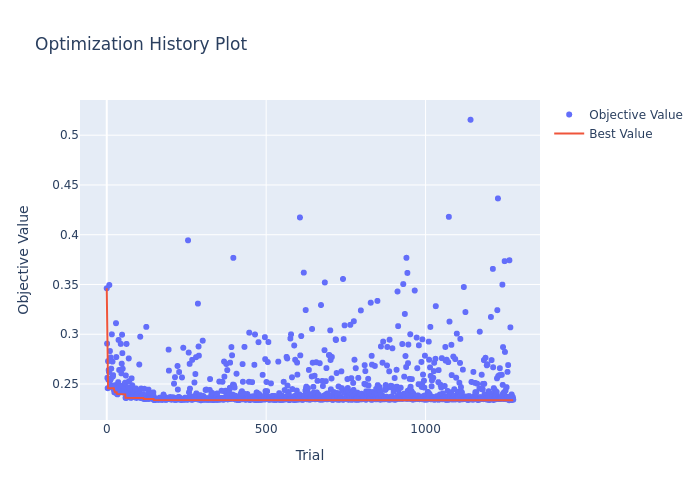

In [11]:
plot_optimization_history(study)

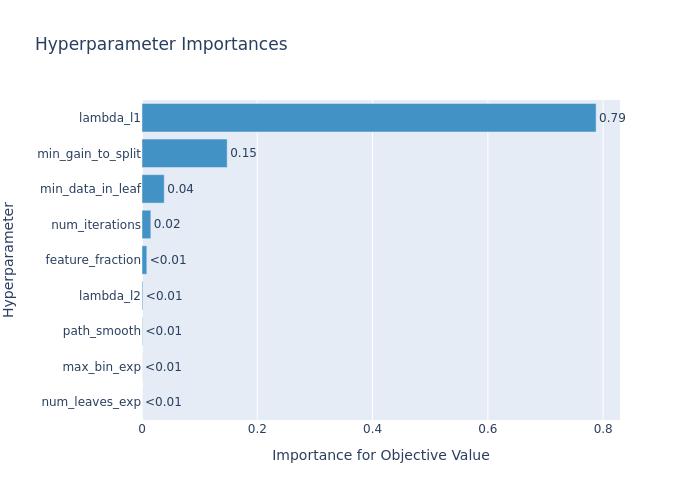

In [12]:
plot_param_importances(study)

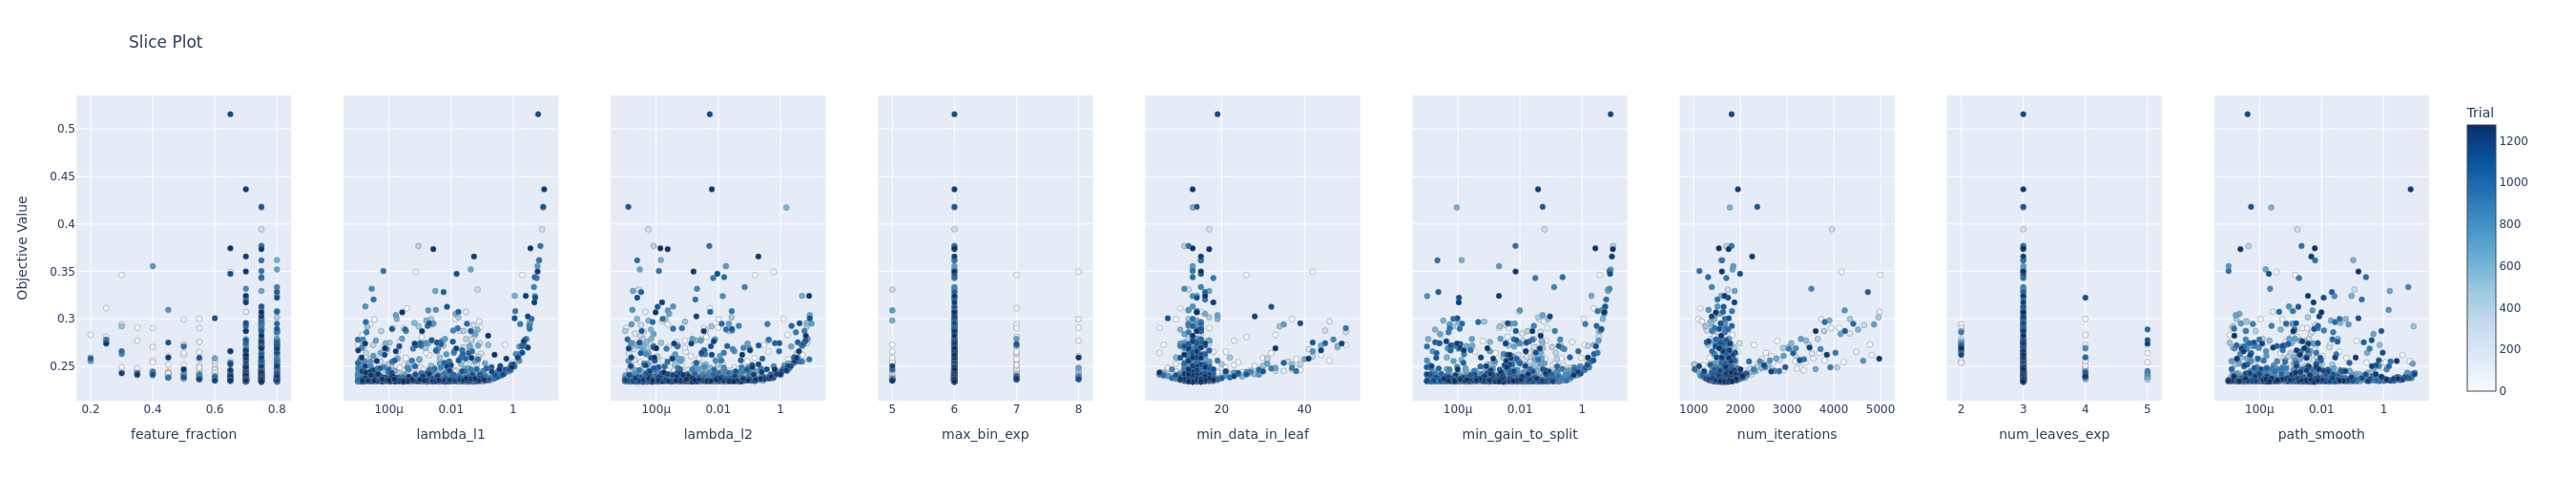

In [13]:
plot_slice(study)

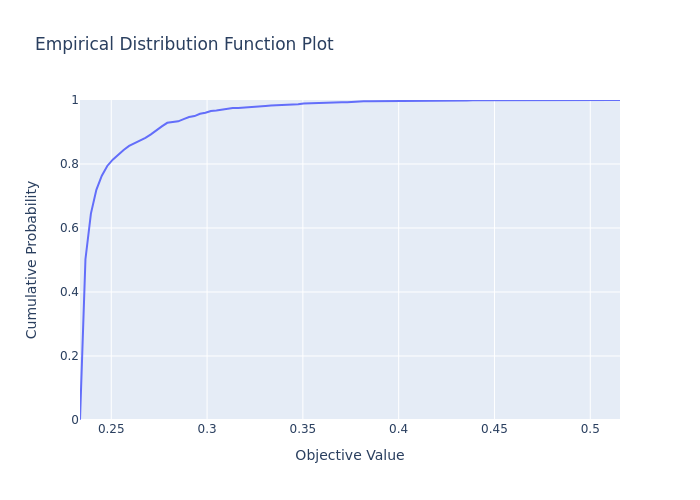

In [14]:
plot_edf(study)

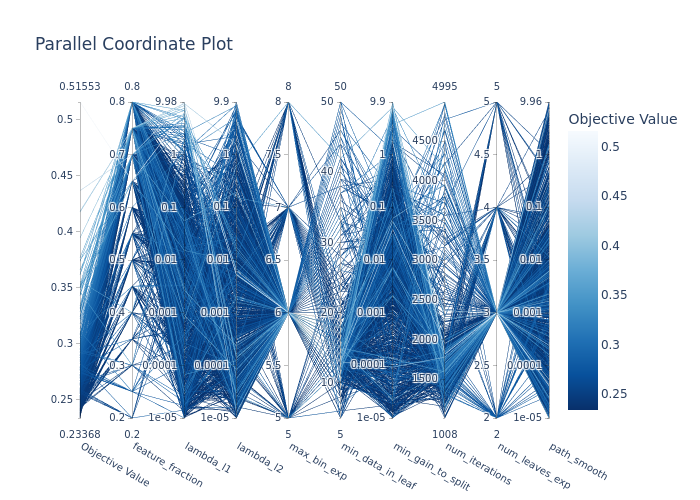

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'metric': 'None',
 'learning_rate': 0.005,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'feature_fraction': 0.8,
 'lambda_l1': 0.054300986061890794,
 'lambda_l2': 2.327614041477573e-05,
 'min_data_in_leaf': 15,
 'min_gain_to_split': 0.005379788209142758,
 'num_iterations': 1652,
 'path_smooth': 0.005489827348259758,
 'max_bin': 63,
 'num_leaves': 7}

***